In [1]:
import sys
import matplotlib.pyplot as plt
import h5py
from tqdm import tqdm
import librosa
import numpy as np
from keras.utils.np_utils import to_categorical
from sklearn.utils import shuffle
import cv2
import torch
import torchaudio

from tools import prepare, mixup, preprocess, noise, getCorrects

sys.path.append('../BAT/datasets/')

classes = {
    "Rhinolophus ferrumequinum": 0,
    "Rhinolophus hipposideros": 1,
    "Myotis daubentonii": 2,
    "Myotis brandtii": 3,
    "Myotis mystacinus": 4,
    "Myotis emarginatus": 5,
    "Myotis nattereri": 6,
    #"Myotis bechsteinii": 7,
    "Myotis myotis": 7,
    "Myotis dasycneme": 8,
    "Nyctalus noctula": 9,
    "Nyctalus leisleri": 10,
    "Pipistrellus pipistrellus": 11,
    "Pipistrellus nathusii": 12,
    "Pipistrellus kuhlii": 13,
    "Eptesicus serotinus": 14,
    "Eptesicus nilssonii": 15,
    #"Plecotus auritus": 16,
    #"Plecotus austriacus": 16,
    #"Barbastella barbastellus": 16,
    #"Tadarida teniotis": 16,
    "Miniopterus schreibersii": 16,
    #"Hypsugo savii": 18,
    "Vespertilio murinus": 17,
}

2022-11-14 10:59:17.391087: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-14 10:59:17.833746: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-14 10:59:20.728238: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ffundel/.local/lib:
2022-11-14 10:59:20.728526: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cann

# Dataset

In [2]:
num_bands = 257
max_len = 60
seq_len = (max_len + 1) * 2816      # = 250ms ~ 25ms (0.5 * 44 * (512 // 4))
seq_skip = int(max_len / 4) * 2816     # 15 patches = 15 * 0.25 * 22050 * 0.5
patch_len = 44
patch_skip = 22

data_path = "../BAT/datasets/prepared_signal.h5"
X_train, Y_train, X_test, Y_test, X_val, Y_val = prepare(data_path, classes, seq_len, seq_skip)

100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 20.49it/s]


In [3]:
print("Total sequences:", len(X_train) + len(X_test) + len(X_val))
print("Train sequences:", X_train.shape, Y_train.shape)
print("Test sequences:", X_test.shape, Y_test.shape)
print("Validation sequences:", X_val.shape, Y_val.shape)

Total sequences: 19194
Train sequences: (11323, 171776) (11323,)
Test sequences: (4980, 171776) (4980,)
Validation sequences: (2891, 171776) (2891,)


# Model

In [4]:
import time
import datetime
import torch
import torch.nn as nn
import math
from torch.cuda.amp import autocast
from torch.utils.data import TensorDataset, DataLoader

from torchsummary import summary
from torchmetrics.functional import f1_score

from SAM import SAM
from ASL import AsymmetricLoss
from BigBAT import BigBAT

/home/ffundel/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/ffundel/.local/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


In [5]:
batch_size = 64
epochs = 23
lr = .0005
warmup_epochs = 5
d_model = 64

nhead = 2
dim_feedforward = 32
num_layers = 2
dropout = 0.3
classifier_dropout = 0.3
num_classes = len(list(classes))

patch_embedding = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(5, 7), stride=(2, 3), padding=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            nn.Conv2d(16, 32, kernel_size=(3, 5), stride=(2, 3), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5, stride=2, padding=1),

            nn.Conv2d(32, 64, kernel_size=(3, 5), stride=(1, 2), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
    
model = BigBAT(
    max_len=max_len,
    patch_len=patch_len,
    patch_skip=patch_skip,
    d_model=d_model,
    num_classes=len(list(classes)),
    patch_embedding=patch_embedding,
    nhead=nhead,
    dim_feedforward=dim_feedforward,
    num_layers=num_layers,
    dropout=dropout,
    classifier_dropout=classifier_dropout,
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, device_ids=[0, 1])
    
model.to(device)
print(device)

cuda:0


In [6]:
freq_masking = torchaudio.transforms.FrequencyMasking(freq_mask_param=50)
time_masking = torchaudio.transforms.TimeMasking(time_mask_param=50)

In [7]:
train_len = batch_size * int(len(X_train) / batch_size)
test_len = batch_size * int(len(X_test) / batch_size)
val_len = batch_size * int(len(X_val) / batch_size)

train_data = TensorDataset(torch.Tensor(X_train[:train_len]), torch.from_numpy(Y_train[:train_len]))
test_data = TensorDataset(torch.Tensor(X_test[:test_len]), torch.from_numpy(Y_test[:test_len]))
val_data = TensorDataset(torch.Tensor(X_val[:val_len]), torch.from_numpy(Y_val[:val_len]))

train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

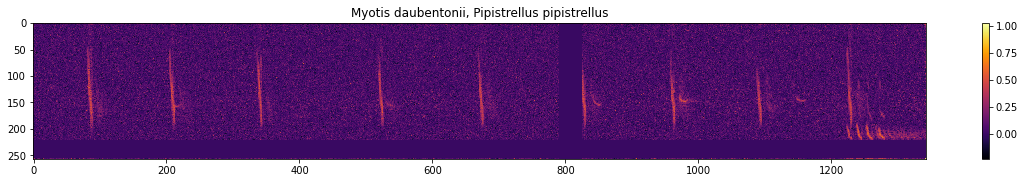

In [8]:
def plot_sequence(X, Y, k):
    plt.figure(figsize = (20, 2.5))
    x = X[k].cpu().detach().numpy()
    y = Y[k].cpu().detach().numpy()
    plt.imshow(np.rot90(x), interpolation='nearest', aspect='auto', cmap='inferno')
    plt.colorbar()
    label_list = []
    if(len(y.shape) > 0):
        for i in np.argwhere(y == 1)[:,0]:
            label_list.append(list(classes)[i])
        plt.title(", ".join(label_list))
    else:
        plt.title(list(classes)[y])

k = np.random.randint(0, batch_size)
X1, Y1 = next(iter(train_loader))
X1, Y1 = X1.cuda(), Y1.cuda()
X1, Y1 = mixup(X1, Y1, num_classes=num_classes, min_seq=1, max_seq=3)
X1 = preprocess(X1)
X1 = noise(X1)
X1 = freq_masking(X1)
X1 = time_masking(X1)
        
plot_sequence(X1, Y1, k)

In [9]:
criterion = AsymmetricLoss(gamma_neg=2, gamma_pos=1, clip=0)

base_optimizer = torch.optim.SGD
optimizer = SAM(model.parameters(), base_optimizer, lr=lr, momentum=0.9)
    
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=warmup_epochs)

min_val_loss = np.inf

torch.autograd.set_detect_anomaly(True)

In [10]:
def smoothen(y, num_classes, l=.02):
    return y * (1.0 - l) + (y.sum(dim=1, keepdim=True) * l / num_classes).repeat(1, num_classes)

def getSpeciesMasks(species):
    masks = torch.eye(len(species))
    for i, s in enumerate(species):
        genus = s.split(' ')[0]
        for k, ss in enumerate(species):
            if ss.startswith(genus):
                masks[i, k] = 1
        masks[i, i] = 0
    return masks

def speciesSmoothing(Y, masks, l=.1):
    ny = torch.zeros_like(Y)
    for i, y in enumerate(Y):
        lbl = torch.nonzero(y)
        ny[i] = y * (1.0 - l) + masks[lbl].sum(0) * (y.sum() * l / max(masks[lbl].sum(), 1))
    return ny

test_y = torch.zeros(3, num_classes).to(device)
test_y[0, 4] = 1
test_y[0, 5] = 1
test_y[1, 11] = 1
test_y[2, 4] = 1
test_y[2, 11] = 1
test_y[2, 17] = 1
print(test_y)
masks = getSpeciesMasks(list(classes)).to(device)
test_smooth = smoothen(test_y, num_classes)
test_specsmooth = speciesSmoothing(test_y, masks)
print(test_smooth, test_smooth.sum())
print(test_specsmooth, test_specsmooth.sum())

tensor([[0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.]],
       device='cuda:0')
tensor([[0.0022, 0.0022, 0.0022, 0.0022, 0.9822, 0.9822, 0.0022, 0.0022, 0.0022,
         0.0022, 0.0022, 0.0022, 0.0022, 0.0022, 0.0022, 0.0022, 0.0022, 0.0022],
        [0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
         0.0011, 0.0011, 0.9811, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011],
        [0.0033, 0.0033, 0.0033, 0.0033, 0.9833, 0.0033, 0.0033, 0.0033, 0.0033,
         0.0033, 0.0033, 0.9833, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.9833]],
       device='cuda:0') tensor(6., device='cuda:0')
tensor([[0.0000, 0.0000, 0.0333, 0.0333, 0.9167, 0.9167, 0.0333, 0.0333, 0.0333,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000,

In [11]:
def train_epoch(model, epoch, criterion, optimizer, scheduler, dataloader, device):
    model.train()
    
    running_loss = 0.0
    running_corrects = 0
    
    num_batches = len(dataloader)
    num_samples = len(dataloader.dataset)
    
    for batch, (inputs, labels) in enumerate(tqdm(dataloader)):
        # Transfer Data to GPU if available
        inputs, labels = inputs.to(device), labels.to(device)
        inputs, labels = mixup(inputs, labels, num_classes, min_seq=1, max_seq=3, p_min=0.3)
        inputs = preprocess(inputs)
        #inputs = noise(inputs)
        #inputs = freq_masking(inputs)
        #inputs = time_masking(inputs)
        #labels = smoothen(labels, num_classes)
        labels = speciesSmoothing(labels, masks)
        labels = smoothen(labels, num_classes)
         
        # Clear the gradients
        optimizer.zero_grad()
        
        # Forward Pass
        inputs[torch.isnan(inputs)] = 0
        outputs = model(inputs)

        # Compute Loss (ASL)
        labels[torch.isnan(labels)] = 0
        outputs[torch.isnan(outputs)] = 0
        loss = criterion(outputs, labels)
        
        # Calculate gradients
        loss.backward()
        
        # Update Weights (SAM)
        optimizer.first_step()
        criterion(model(inputs), labels).backward()
        optimizer.second_step()
        
        # Calculate Loss
        running_loss += loss.item() * inputs.size(0)
        running_corrects += getCorrects(outputs, labels)
    
        # Perform learning rate step
        scheduler.step(epoch + batch / num_batches)
            
    epoch_loss = running_loss / num_samples
    epoch_acc = running_corrects / num_samples
    
    return epoch_loss, epoch_acc

In [12]:
def test_epoch(model, epoch, criterion, optimizer, dataloader, device):
    model.eval()
    
    num_batches = len(dataloader)
    num_samples = len(dataloader.dataset)
    
    with torch.no_grad():
        running_loss = 0.0
        running_corrects = 0

        for batch, (inputs, labels) in enumerate(tqdm(dataloader)):
            # Transfer Data to GPU if available
            inputs, labels = inputs.to(device), labels.to(device)
            inputs, labels = mixup(inputs, labels, num_classes, min_seq=1, max_seq=3)
            inputs = preprocess(inputs)

            # Clear the gradients
            optimizer.zero_grad()

            # Forward Pass
            outputs = model(inputs)

            # Compute Loss
            loss = criterion(outputs, labels)

            # Calculate Loss
            running_loss += loss.item() * inputs.size(0)
            running_corrects += getCorrects(outputs, labels)

        epoch_loss = running_loss / num_samples
        epoch_acc = running_corrects / num_samples
    
    return epoch_loss, epoch_acc

# Training

In [13]:
import wandb

wandb_config = {
    "epochs": epochs,
    "lr": lr,
    "batch_size": batch_size,
    "warmup_epochs": warmup_epochs,
    "d_model": d_model,
    "nhead": nhead,
    "dim_feedforward": dim_feedforward,
    "num_layers": num_layers,
    "dropout": dropout,
    "classifier_dropout": classifier_dropout
}

wandb.init(project="BigBAT", entity="frankfundel", config=wandb_config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: frankfundel (use `wandb login --relogin` to force relogin)
2022-11-14 11:00:24.685667: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-14 11:00:25.125248: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-14 11:00:27.339128: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory

In [14]:
restart_scheduler = 5
s_epoch = 0
for epoch in range(epochs):
    end = time.time()
    print(f"==================== Starting at epoch {epoch} ====================", flush=True)
    
    train_loss, train_acc = train_epoch(model, s_epoch, criterion, optimizer, scheduler, train_loader, device)
    print('Training loss: {:.4f} Acc: {:.4f}'.format(train_loss, train_acc), flush=True)
    
    val_loss, val_acc = test_epoch(model, s_epoch, criterion, optimizer, val_loader, device)
    print('Validation loss: {:.4f} Acc: {:.4f}'.format(val_loss, val_acc), flush=True)
    
    wandb.log({
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
    })
    
    if min_val_loss > val_loss:
        print('val_loss decreased, saving model', flush=True)
        min_val_loss = val_loss
        
        # Saving State Dict
        torch.save(model.state_dict(), 'BigBAT.pth')
    
    if s_epoch == restart_scheduler:
        s_epoch = 0
    else:
        s_epoch += 1

# Load after training
model.load_state_dict(torch.load('BigBAT.pth'))

==================== Starting at epoch 0 ====================


  0%|                                                   | 0/176 [00:00<?, ?it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▏                                          | 1/176 [00:03<10:36,  3.64s/it]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▍                                          | 2/176 [00:04<08:04,  2.78s/it]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▋                                          | 3/176 [00:05<06:18,  2.19s/it]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▉                                          | 4/176 [00:05<05:03,  1.77s/it]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▏                                         | 5/176 [00:06<04:11,  1.47s/it]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▍                                         | 6/176 [00:07<03:35,  1.27s/it]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  4%|█▋                                         | 7/176 [00:08<03:09,  1.12s/it]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|█▉                                         | 8/176 [00:09<02:51,  1.02s/it]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|██▏                                        | 9/176 [00:09<02:38,  1.05it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▍                                       | 10/176 [00:10<02:29,  1.11it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▋                                       | 11/176 [00:11<02:22,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|██▊                                       | 12/176 [00:12<02:19,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|███                                       | 13/176 [00:13<02:15,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  8%|███▎                                      | 14/176 [00:13<02:12,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▌                                      | 15/176 [00:14<02:10,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▊                                      | 16/176 [00:15<02:08,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████                                      | 17/176 [00:16<02:06,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████▎                                     | 18/176 [00:17<02:06,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▌                                     | 19/176 [00:17<02:04,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▊                                     | 20/176 [00:18<02:03,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████                                     | 21/176 [00:19<02:03,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████▎                                    | 22/176 [00:20<02:01,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 13%|█████▍                                    | 23/176 [00:21<02:01,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▋                                    | 24/176 [00:21<02:00,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▉                                    | 25/176 [00:22<01:59,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▏                                   | 26/176 [00:23<01:58,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▍                                   | 27/176 [00:24<01:57,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▋                                   | 28/176 [00:24<01:56,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▉                                   | 29/176 [00:25<01:55,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 17%|███████▏                                  | 30/176 [00:26<01:54,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▍                                  | 31/176 [00:27<01:54,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▋                                  | 32/176 [00:28<01:54,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|███████▉                                  | 33/176 [00:28<01:53,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|████████                                  | 34/176 [00:29<01:52,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▎                                 | 35/176 [00:30<01:52,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▌                                 | 36/176 [00:31<01:51,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 21%|████████▊                                 | 37/176 [00:32<01:51,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████                                 | 38/176 [00:32<01:50,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████▎                                | 39/176 [00:33<01:50,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▌                                | 40/176 [00:34<01:49,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▊                                | 41/176 [00:35<01:49,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████                                | 42/176 [00:36<01:47,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████▎                               | 43/176 [00:36<01:47,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 25%|██████████▌                               | 44/176 [00:37<01:45,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▋                               | 45/176 [00:38<01:45,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▉                               | 46/176 [00:39<01:44,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▏                              | 47/176 [00:40<01:43,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▍                              | 48/176 [00:40<01:42,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▋                              | 49/176 [00:41<01:41,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▉                              | 50/176 [00:42<01:40,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 29%|████████████▏                             | 51/176 [00:43<01:40,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▍                             | 52/176 [00:44<01:40,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▋                             | 53/176 [00:45<01:39,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|████████████▉                             | 54/176 [00:45<01:40,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|█████████████▏                            | 55/176 [00:46<01:39,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▎                            | 56/176 [00:47<01:37,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▌                            | 57/176 [00:48<01:36,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 33%|█████████████▊                            | 58/176 [00:49<01:34,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████                            | 59/176 [00:49<01:34,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████▎                           | 60/176 [00:50<01:33,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▌                           | 61/176 [00:51<01:33,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▊                           | 62/176 [00:52<01:31,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████                           | 63/176 [00:53<01:30,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████▎                          | 64/176 [00:53<01:29,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 37%|███████████████▌                          | 65/176 [00:54<01:28,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▊                          | 66/176 [00:55<01:27,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▉                          | 67/176 [00:56<01:28,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▏                         | 68/176 [00:57<01:27,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▍                         | 69/176 [00:57<01:27,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▋                         | 70/176 [00:58<01:26,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▉                         | 71/176 [00:59<01:25,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▏                        | 72/176 [01:00<01:24,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▍                        | 73/176 [01:01<01:23,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 42%|█████████████████▋                        | 74/176 [01:02<01:23,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|█████████████████▉                        | 75/176 [01:02<01:21,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|██████████████████▏                       | 76/176 [01:03<01:20,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▍                       | 77/176 [01:04<01:18,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▌                       | 78/176 [01:05<01:17,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|██████████████████▊                       | 79/176 [01:05<01:16,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|███████████████████                       | 80/176 [01:06<01:15,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 46%|███████████████████▎                      | 81/176 [01:07<01:14,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▌                      | 82/176 [01:08<01:13,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▊                      | 83/176 [01:09<01:13,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████                      | 84/176 [01:09<01:12,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████▎                     | 85/176 [01:10<01:11,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▌                     | 86/176 [01:11<01:11,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▊                     | 87/176 [01:12<01:10,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 50%|█████████████████████                     | 88/176 [01:13<01:09,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▏                    | 89/176 [01:13<01:08,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▍                    | 90/176 [01:14<01:08,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▋                    | 91/176 [01:15<01:08,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▉                    | 92/176 [01:16<01:07,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▏                   | 93/176 [01:17<01:07,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▍                   | 94/176 [01:17<01:06,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 54%|██████████████████████▋                   | 95/176 [01:18<01:05,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|██████████████████████▉                   | 96/176 [01:19<01:04,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|███████████████████████▏                  | 97/176 [01:20<01:03,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▍                  | 98/176 [01:21<01:02,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▋                  | 99/176 [01:21<01:01,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▎                 | 100/176 [01:22<01:00,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▌                 | 101/176 [01:23<00:59,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 58%|███████████████████████▊                 | 102/176 [01:24<00:58,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|███████████████████████▉                 | 103/176 [01:25<00:57,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|████████████████████████▏                | 104/176 [01:25<00:56,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▍                | 105/176 [01:26<00:55,  1.28it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▋                | 106/176 [01:27<00:54,  1.28it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|████████████████████████▉                | 107/176 [01:28<00:54,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|█████████████████████████▏               | 108/176 [01:29<00:53,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▍               | 109/176 [01:29<00:52,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▋               | 110/176 [01:30<00:52,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 63%|█████████████████████████▊               | 111/176 [01:31<00:51,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████               | 112/176 [01:32<00:50,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████▎              | 113/176 [01:33<00:51,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▌              | 114/176 [01:33<00:49,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▊              | 115/176 [01:34<00:49,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████              | 116/176 [01:35<00:48,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████▎             | 117/176 [01:36<00:48,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 67%|███████████████████████████▍             | 118/176 [01:37<00:46,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▋             | 119/176 [01:37<00:46,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▉             | 120/176 [01:38<00:45,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▏            | 121/176 [01:39<00:44,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▍            | 122/176 [01:40<00:43,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▋            | 123/176 [01:41<00:42,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▉            | 124/176 [01:41<00:41,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 71%|█████████████████████████████            | 125/176 [01:42<00:41,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▎           | 126/176 [01:43<00:42,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▌           | 127/176 [01:44<00:40,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|█████████████████████████████▊           | 128/176 [01:45<00:39,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|██████████████████████████████           | 129/176 [01:46<00:38,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▎          | 130/176 [01:46<00:37,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▌          | 131/176 [01:47<00:36,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 75%|██████████████████████████████▊          | 132/176 [01:48<00:36,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|██████████████████████████████▉          | 133/176 [01:49<00:35,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|███████████████████████████████▏         | 134/176 [01:50<00:34,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▍         | 135/176 [01:50<00:33,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▋         | 136/176 [01:51<00:32,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|███████████████████████████████▉         | 137/176 [01:52<00:32,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|████████████████████████████████▏        | 138/176 [01:53<00:31,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 79%|████████████████████████████████▍        | 139/176 [01:54<00:30,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▌        | 140/176 [01:55<00:30,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▊        | 141/176 [01:55<00:28,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████        | 142/176 [01:56<00:28,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████▎       | 143/176 [01:57<00:27,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▌       | 144/176 [01:58<00:26,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▊       | 145/176 [01:59<00:25,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 83%|██████████████████████████████████       | 146/176 [02:00<00:24,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▏      | 147/176 [02:00<00:23,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▍      | 148/176 [02:01<00:22,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▋      | 149/176 [02:02<00:21,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▉      | 150/176 [02:03<00:20,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▏     | 151/176 [02:04<00:19,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▍     | 152/176 [02:04<00:19,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 87%|███████████████████████████████████▋     | 153/176 [02:05<00:20,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|███████████████████████████████████▉     | 154/176 [02:06<00:19,  1.13it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|████████████████████████████████████     | 155/176 [02:07<00:18,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▎    | 156/176 [02:08<00:16,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▌    | 157/176 [02:09<00:15,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|████████████████████████████████████▊    | 158/176 [02:09<00:14,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|█████████████████████████████████████    | 159/176 [02:10<00:13,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▎   | 160/176 [02:11<00:12,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▌   | 161/176 [02:12<00:12,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 92%|█████████████████████████████████████▋   | 162/176 [02:13<00:11,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|█████████████████████████████████████▉   | 163/176 [02:13<00:10,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|██████████████████████████████████████▏  | 164/176 [02:14<00:09,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▍  | 165/176 [02:15<00:08,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▋  | 166/176 [02:16<00:07,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|██████████████████████████████████████▉  | 167/176 [02:17<00:07,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|███████████████████████████████████████▏ | 168/176 [02:17<00:06,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 96%|███████████████████████████████████████▎ | 169/176 [02:18<00:05,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▌ | 170/176 [02:19<00:05,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▊ | 171/176 [02:20<00:04,  1.12it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████ | 172/176 [02:21<00:03,  1.07it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████▎| 173/176 [02:22<00:02,  1.05it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▌| 174/176 [02:23<00:01,  1.00it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▊| 175/176 [02:24<00:01,  1.01s/it]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


100%|█████████████████████████████████████████| 176/176 [02:25<00:00,  1.21it/s]

Training loss: 120.1843 Acc: 0.0182



100%|███████████████████████████████████████████| 45/45 [00:12<00:00,  3.49it/s]

Validation loss: 115.0485 Acc: 0.2140
val_loss decreased, saving model
==================== Starting at epoch 1 ====================



  0%|                                                   | 0/176 [00:00<?, ?it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▏                                          | 1/176 [00:00<02:22,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▍                                          | 2/176 [00:01<02:20,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▋                                          | 3/176 [00:02<02:18,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▉                                          | 4/176 [00:03<02:18,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▏                                         | 5/176 [00:04<02:17,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▍                                         | 6/176 [00:04<02:16,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  4%|█▋                                         | 7/176 [00:05<02:14,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|█▉                                         | 8/176 [00:06<02:13,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|██▏                                        | 9/176 [00:07<02:12,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▍                                       | 10/176 [00:07<02:11,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▋                                       | 11/176 [00:08<02:10,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|██▊                                       | 12/176 [00:09<02:10,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|███                                       | 13/176 [00:10<02:09,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  8%|███▎                                      | 14/176 [00:11<02:10,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▌                                      | 15/176 [00:11<02:09,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▊                                      | 16/176 [00:12<02:08,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████                                      | 17/176 [00:13<02:06,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████▎                                     | 18/176 [00:14<02:07,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▌                                     | 19/176 [00:15<02:07,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▊                                     | 20/176 [00:15<02:05,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████                                     | 21/176 [00:16<02:06,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████▎                                    | 22/176 [00:17<02:03,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 13%|█████▍                                    | 23/176 [00:18<02:02,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▋                                    | 24/176 [00:19<02:01,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▉                                    | 25/176 [00:19<02:00,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▏                                   | 26/176 [00:20<01:59,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▍                                   | 27/176 [00:21<01:58,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▋                                   | 28/176 [00:22<01:57,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▉                                   | 29/176 [00:23<01:56,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 17%|███████▏                                  | 30/176 [00:23<01:55,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▍                                  | 31/176 [00:24<01:55,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▋                                  | 32/176 [00:25<01:54,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|███████▉                                  | 33/176 [00:26<01:54,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|████████                                  | 34/176 [00:27<01:56,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▎                                 | 35/176 [00:28<02:04,  1.13it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▌                                 | 36/176 [00:29<02:09,  1.09it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 21%|████████▊                                 | 37/176 [00:30<02:03,  1.12it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████                                 | 38/176 [00:30<01:58,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████▎                                | 39/176 [00:31<02:03,  1.11it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▌                                | 40/176 [00:32<02:09,  1.05it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▊                                | 41/176 [00:33<02:09,  1.04it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████                                | 42/176 [00:34<02:08,  1.04it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████▎                               | 43/176 [00:35<02:00,  1.10it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 25%|██████████▌                               | 44/176 [00:36<01:55,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▋                               | 45/176 [00:37<01:50,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▉                               | 46/176 [00:38<01:47,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▏                              | 47/176 [00:38<01:45,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▍                              | 48/176 [00:39<01:42,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▋                              | 49/176 [00:40<01:42,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▉                              | 50/176 [00:41<01:44,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 29%|████████████▏                             | 51/176 [00:42<01:42,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▍                             | 52/176 [00:42<01:41,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▋                             | 53/176 [00:43<01:40,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|████████████▉                             | 54/176 [00:44<01:42,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|█████████████▏                            | 55/176 [00:45<01:39,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▎                            | 56/176 [00:46<01:39,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▌                            | 57/176 [00:47<01:39,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 33%|█████████████▊                            | 58/176 [00:47<01:38,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████                            | 59/176 [00:48<01:38,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████▎                           | 60/176 [00:49<01:36,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▌                           | 61/176 [00:50<01:33,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▊                           | 62/176 [00:51<01:33,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████                           | 63/176 [00:51<01:31,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████▎                          | 64/176 [00:52<01:29,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 37%|███████████████▌                          | 65/176 [00:53<01:28,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▊                          | 66/176 [00:54<01:27,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▉                          | 67/176 [00:55<01:27,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▏                         | 68/176 [00:55<01:26,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▍                         | 69/176 [00:56<01:25,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▋                         | 70/176 [00:57<01:24,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▉                         | 71/176 [00:58<01:23,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▏                        | 72/176 [00:59<01:22,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▍                        | 73/176 [00:59<01:22,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 42%|█████████████████▋                        | 74/176 [01:00<01:23,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|█████████████████▉                        | 75/176 [01:01<01:21,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|██████████████████▏                       | 76/176 [01:02<01:21,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▍                       | 77/176 [01:03<01:19,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▌                       | 78/176 [01:03<01:18,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|██████████████████▊                       | 79/176 [01:04<01:19,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|███████████████████                       | 80/176 [01:05<01:17,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 46%|███████████████████▎                      | 81/176 [01:06<01:16,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▌                      | 82/176 [01:07<01:15,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▊                      | 83/176 [01:08<01:14,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████                      | 84/176 [01:08<01:12,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████▎                     | 85/176 [01:09<01:12,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▌                     | 86/176 [01:10<01:11,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▊                     | 87/176 [01:11<01:10,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 50%|█████████████████████                     | 88/176 [01:11<01:09,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▏                    | 89/176 [01:12<01:08,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▍                    | 90/176 [01:13<01:07,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▋                    | 91/176 [01:14<01:07,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▉                    | 92/176 [01:15<01:06,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▏                   | 93/176 [01:15<01:05,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▍                   | 94/176 [01:16<01:05,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 54%|██████████████████████▋                   | 95/176 [01:17<01:04,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|██████████████████████▉                   | 96/176 [01:18<01:04,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|███████████████████████▏                  | 97/176 [01:19<01:05,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▍                  | 98/176 [01:20<01:03,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▋                  | 99/176 [01:20<01:03,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▎                 | 100/176 [01:21<01:01,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▌                 | 101/176 [01:22<01:00,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 58%|███████████████████████▊                 | 102/176 [01:23<01:00,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|███████████████████████▉                 | 103/176 [01:24<00:59,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|████████████████████████▏                | 104/176 [01:24<00:57,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▍                | 105/176 [01:25<00:56,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▋                | 106/176 [01:26<00:55,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|████████████████████████▉                | 107/176 [01:27<00:54,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|█████████████████████████▏               | 108/176 [01:27<00:53,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▍               | 109/176 [01:28<00:52,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▋               | 110/176 [01:29<00:51,  1.28it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 63%|█████████████████████████▊               | 111/176 [01:30<00:51,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████               | 112/176 [01:31<00:50,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████▎              | 113/176 [01:31<00:49,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▌              | 114/176 [01:32<00:49,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▊              | 115/176 [01:33<00:48,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████              | 116/176 [01:34<00:47,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████▎             | 117/176 [01:35<00:46,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 67%|███████████████████████████▍             | 118/176 [01:35<00:45,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▋             | 119/176 [01:36<00:45,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▉             | 120/176 [01:37<00:44,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▏            | 121/176 [01:38<00:45,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▍            | 122/176 [01:39<00:43,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▋            | 123/176 [01:39<00:42,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▉            | 124/176 [01:40<00:42,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 71%|█████████████████████████████            | 125/176 [01:41<00:41,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▎           | 126/176 [01:42<00:40,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▌           | 127/176 [01:43<00:39,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|█████████████████████████████▊           | 128/176 [01:43<00:38,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|██████████████████████████████           | 129/176 [01:44<00:37,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▎          | 130/176 [01:45<00:36,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▌          | 131/176 [01:46<00:35,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 75%|██████████████████████████████▊          | 132/176 [01:47<00:34,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|██████████████████████████████▉          | 133/176 [01:47<00:33,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|███████████████████████████████▏         | 134/176 [01:48<00:33,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▍         | 135/176 [01:49<00:32,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▋         | 136/176 [01:50<00:39,  1.02it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|███████████████████████████████▉         | 137/176 [01:51<00:36,  1.08it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|████████████████████████████████▏        | 138/176 [01:52<00:33,  1.12it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 79%|████████████████████████████████▍        | 139/176 [01:53<00:31,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▌        | 140/176 [01:54<00:30,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▊        | 141/176 [01:54<00:29,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████        | 142/176 [01:55<00:28,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████▎       | 143/176 [01:56<00:27,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▌       | 144/176 [01:57<00:26,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▊       | 145/176 [01:58<00:25,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 83%|██████████████████████████████████       | 146/176 [01:59<00:24,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▏      | 147/176 [01:59<00:23,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▍      | 148/176 [02:00<00:22,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▋      | 149/176 [02:01<00:21,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▉      | 150/176 [02:02<00:20,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▏     | 151/176 [02:03<00:19,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▍     | 152/176 [02:03<00:19,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 87%|███████████████████████████████████▋     | 153/176 [02:04<00:18,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|███████████████████████████████████▉     | 154/176 [02:05<00:17,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|████████████████████████████████████     | 155/176 [02:06<00:16,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▎    | 156/176 [02:06<00:15,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▌    | 157/176 [02:07<00:15,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|████████████████████████████████████▊    | 158/176 [02:08<00:14,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|█████████████████████████████████████    | 159/176 [02:09<00:13,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▎   | 160/176 [02:10<00:12,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▌   | 161/176 [02:10<00:11,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 92%|█████████████████████████████████████▋   | 162/176 [02:11<00:11,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|█████████████████████████████████████▉   | 163/176 [02:12<00:10,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|██████████████████████████████████████▏  | 164/176 [02:13<00:09,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▍  | 165/176 [02:14<00:09,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▋  | 166/176 [02:15<00:08,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|██████████████████████████████████████▉  | 167/176 [02:15<00:07,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|███████████████████████████████████████▏ | 168/176 [02:16<00:06,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 96%|███████████████████████████████████████▎ | 169/176 [02:17<00:05,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▌ | 170/176 [02:18<00:04,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▊ | 171/176 [02:19<00:03,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████ | 172/176 [02:19<00:03,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████▎| 173/176 [02:20<00:02,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▌| 174/176 [02:21<00:01,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▊| 175/176 [02:22<00:00,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


100%|█████████████████████████████████████████| 176/176 [02:23<00:00,  1.23it/s]

Training loss: 99.9217 Acc: 0.1552



100%|███████████████████████████████████████████| 45/45 [00:12<00:00,  3.69it/s]

Validation loss: 105.7860 Acc: 0.3524
val_loss decreased, saving model
==================== Starting at epoch 2 ====================



  0%|                                                   | 0/176 [00:00<?, ?it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▏                                          | 1/176 [00:00<02:22,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▍                                          | 2/176 [00:01<02:20,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▋                                          | 3/176 [00:02<02:19,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▉                                          | 4/176 [00:03<02:17,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▏                                         | 5/176 [00:03<02:16,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▍                                         | 6/176 [00:04<02:15,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  4%|█▋                                         | 7/176 [00:05<02:15,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|█▉                                         | 8/176 [00:06<02:14,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|██▏                                        | 9/176 [00:07<02:14,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▍                                       | 10/176 [00:08<02:13,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▋                                       | 11/176 [00:08<02:12,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|██▊                                       | 12/176 [00:09<02:12,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|███                                       | 13/176 [00:10<02:14,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  8%|███▎                                      | 14/176 [00:11<02:14,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▌                                      | 15/176 [00:12<02:11,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▊                                      | 16/176 [00:12<02:09,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████                                      | 17/176 [00:13<02:08,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████▎                                     | 18/176 [00:14<02:06,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▌                                     | 19/176 [00:15<02:06,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▊                                     | 20/176 [00:16<02:04,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████                                     | 21/176 [00:16<02:03,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████▎                                    | 22/176 [00:17<02:02,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 13%|█████▍                                    | 23/176 [00:18<02:01,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▋                                    | 24/176 [00:19<02:00,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▉                                    | 25/176 [00:20<01:59,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▏                                   | 26/176 [00:20<01:58,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▍                                   | 27/176 [00:21<01:58,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▋                                   | 28/176 [00:22<01:57,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▉                                   | 29/176 [00:23<01:57,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 17%|███████▏                                  | 30/176 [00:24<01:56,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▍                                  | 31/176 [00:24<01:56,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▋                                  | 32/176 [00:25<01:55,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|███████▉                                  | 33/176 [00:26<01:53,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|████████                                  | 34/176 [00:27<01:54,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▎                                 | 35/176 [00:28<01:52,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▌                                 | 36/176 [00:28<01:52,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 21%|████████▊                                 | 37/176 [00:29<01:50,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████                                 | 38/176 [00:30<01:49,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████▎                                | 39/176 [00:31<01:48,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▌                                | 40/176 [00:32<01:50,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▊                                | 41/176 [00:32<01:48,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████                                | 42/176 [00:33<01:47,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████▎                               | 43/176 [00:34<01:46,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 25%|██████████▌                               | 44/176 [00:35<01:44,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▋                               | 45/176 [00:36<01:43,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▉                               | 46/176 [00:36<01:42,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▏                              | 47/176 [00:37<01:41,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▍                              | 48/176 [00:38<01:40,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▋                              | 49/176 [00:39<01:40,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▉                              | 50/176 [00:39<01:39,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 29%|████████████▏                             | 51/176 [00:40<01:39,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▍                             | 52/176 [00:41<01:38,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▋                             | 53/176 [00:42<01:37,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|████████████▉                             | 54/176 [00:43<01:37,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|█████████████▏                            | 55/176 [00:43<01:37,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▎                            | 56/176 [00:44<01:37,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▌                            | 57/176 [00:45<01:38,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 33%|█████████████▊                            | 58/176 [00:46<01:37,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████                            | 59/176 [00:47<01:35,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████▎                           | 60/176 [00:48<01:33,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▌                           | 61/176 [00:48<01:32,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▊                           | 62/176 [00:49<01:34,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████                           | 63/176 [00:50<01:32,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████▎                          | 64/176 [00:51<01:31,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 37%|███████████████▌                          | 65/176 [00:52<01:30,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▊                          | 66/176 [00:52<01:29,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▉                          | 67/176 [00:53<01:27,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▏                         | 68/176 [00:54<01:26,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▍                         | 69/176 [00:55<01:25,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▋                         | 70/176 [00:56<01:24,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▉                         | 71/176 [00:56<01:23,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▏                        | 72/176 [00:57<01:23,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▍                        | 73/176 [00:58<01:22,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 42%|█████████████████▋                        | 74/176 [00:59<01:21,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|█████████████████▉                        | 75/176 [01:00<01:20,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|██████████████████▏                       | 76/176 [01:00<01:20,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▍                       | 77/176 [01:01<01:19,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▌                       | 78/176 [01:02<01:18,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|██████████████████▊                       | 79/176 [01:03<01:17,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|███████████████████                       | 80/176 [01:04<01:16,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 46%|███████████████████▎                      | 81/176 [01:05<01:16,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▌                      | 82/176 [01:05<01:17,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▊                      | 83/176 [01:06<01:16,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████                      | 84/176 [01:07<01:16,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████▎                     | 85/176 [01:08<01:14,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▌                     | 86/176 [01:09<01:13,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▊                     | 87/176 [01:09<01:12,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 50%|█████████████████████                     | 88/176 [01:10<01:12,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▏                    | 89/176 [01:11<01:11,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▍                    | 90/176 [01:12<01:10,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▋                    | 91/176 [01:13<01:08,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▉                    | 92/176 [01:14<01:08,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▏                   | 93/176 [01:14<01:06,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▍                   | 94/176 [01:15<01:05,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 54%|██████████████████████▋                   | 95/176 [01:16<01:04,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|██████████████████████▉                   | 96/176 [01:17<01:03,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|███████████████████████▏                  | 97/176 [01:17<01:03,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▍                  | 98/176 [01:18<01:02,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▋                  | 99/176 [01:19<01:01,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▎                 | 100/176 [01:20<01:01,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▌                 | 101/176 [01:21<01:00,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 58%|███████████████████████▊                 | 102/176 [01:22<00:59,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|███████████████████████▉                 | 103/176 [01:22<00:59,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|████████████████████████▏                | 104/176 [01:23<00:58,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▍                | 105/176 [01:24<00:59,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▋                | 106/176 [01:25<00:57,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|████████████████████████▉                | 107/176 [01:26<00:56,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|█████████████████████████▏               | 108/176 [01:27<00:56,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▍               | 109/176 [01:27<00:54,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▋               | 110/176 [01:28<00:53,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 63%|█████████████████████████▊               | 111/176 [01:29<00:53,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████               | 112/176 [01:30<00:52,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████▎              | 113/176 [01:31<00:51,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▌              | 114/176 [01:31<00:49,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▊              | 115/176 [01:32<00:48,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████              | 116/176 [01:33<00:47,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████▎             | 117/176 [01:34<00:47,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 67%|███████████████████████████▍             | 118/176 [01:35<00:46,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▋             | 119/176 [01:35<00:45,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▉             | 120/176 [01:36<00:44,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▏            | 121/176 [01:37<00:44,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▍            | 122/176 [01:38<00:43,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▋            | 123/176 [01:39<00:42,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▉            | 124/176 [01:39<00:41,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 71%|█████████████████████████████            | 125/176 [01:40<00:40,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▎           | 126/176 [01:41<00:41,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▌           | 127/176 [01:42<00:40,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|█████████████████████████████▊           | 128/176 [01:43<00:39,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|██████████████████████████████           | 129/176 [01:44<00:39,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▎          | 130/176 [01:44<00:37,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▌          | 131/176 [01:45<00:36,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 75%|██████████████████████████████▊          | 132/176 [01:46<00:35,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|██████████████████████████████▉          | 133/176 [01:47<00:35,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|███████████████████████████████▏         | 134/176 [01:48<00:33,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▍         | 135/176 [01:48<00:32,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▋         | 136/176 [01:49<00:32,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|███████████████████████████████▉         | 137/176 [01:50<00:31,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|████████████████████████████████▏        | 138/176 [01:51<00:30,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 79%|████████████████████████████████▍        | 139/176 [01:52<00:29,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▌        | 140/176 [01:52<00:28,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▊        | 141/176 [01:53<00:27,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████        | 142/176 [01:54<00:26,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████▎       | 143/176 [01:55<00:26,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▌       | 144/176 [01:56<00:25,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▊       | 145/176 [01:56<00:24,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 83%|██████████████████████████████████       | 146/176 [01:57<00:24,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▏      | 147/176 [01:58<00:23,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▍      | 148/176 [01:59<00:22,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▋      | 149/176 [02:00<00:21,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▉      | 150/176 [02:00<00:21,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▏     | 151/176 [02:01<00:20,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▍     | 152/176 [02:02<00:19,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 87%|███████████████████████████████████▋     | 153/176 [02:03<00:18,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|███████████████████████████████████▉     | 154/176 [02:04<00:17,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|████████████████████████████████████     | 155/176 [02:05<00:17,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▎    | 156/176 [02:05<00:16,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▌    | 157/176 [02:06<00:15,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|████████████████████████████████████▊    | 158/176 [02:07<00:14,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|█████████████████████████████████████    | 159/176 [02:08<00:13,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▎   | 160/176 [02:09<00:12,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▌   | 161/176 [02:09<00:12,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 92%|█████████████████████████████████████▋   | 162/176 [02:10<00:11,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|█████████████████████████████████████▉   | 163/176 [02:11<00:10,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|██████████████████████████████████████▏  | 164/176 [02:12<00:09,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▍  | 165/176 [02:13<00:08,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▋  | 166/176 [02:13<00:07,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|██████████████████████████████████████▉  | 167/176 [02:14<00:07,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|███████████████████████████████████████▏ | 168/176 [02:15<00:06,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 96%|███████████████████████████████████████▎ | 169/176 [02:16<00:05,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▌ | 170/176 [02:17<00:04,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▊ | 171/176 [02:17<00:04,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████ | 172/176 [02:18<00:03,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████▎| 173/176 [02:19<00:02,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▌| 174/176 [02:20<00:01,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▊| 175/176 [02:21<00:00,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


100%|█████████████████████████████████████████| 176/176 [02:22<00:00,  1.24it/s]

Training loss: 91.7390 Acc: 0.2176



100%|███████████████████████████████████████████| 45/45 [00:12<00:00,  3.73it/s]

Validation loss: 96.8140 Acc: 0.4167
val_loss decreased, saving model
==================== Starting at epoch 3 ====================



  0%|                                                   | 0/176 [00:00<?, ?it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▏                                          | 1/176 [00:00<02:29,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▍                                          | 2/176 [00:01<02:30,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▋                                          | 3/176 [00:02<02:27,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▉                                          | 4/176 [00:03<02:25,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▏                                         | 5/176 [00:04<02:21,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▍                                         | 6/176 [00:04<02:19,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  4%|█▋                                         | 7/176 [00:05<02:17,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|█▉                                         | 8/176 [00:06<02:15,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|██▏                                        | 9/176 [00:07<02:12,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▍                                       | 10/176 [00:08<02:11,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▋                                       | 11/176 [00:08<02:10,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|██▊                                       | 12/176 [00:09<02:10,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|███                                       | 13/176 [00:10<02:09,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  8%|███▎                                      | 14/176 [00:11<02:08,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▌                                      | 15/176 [00:12<02:07,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▊                                      | 16/176 [00:12<02:07,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████                                      | 17/176 [00:13<02:06,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████▎                                     | 18/176 [00:14<02:05,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▌                                     | 19/176 [00:15<02:06,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▊                                     | 20/176 [00:16<02:05,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████                                     | 21/176 [00:16<02:04,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████▎                                    | 22/176 [00:17<02:04,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 13%|█████▍                                    | 23/176 [00:18<02:02,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▋                                    | 24/176 [00:19<02:02,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▉                                    | 25/176 [00:20<02:04,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▏                                   | 26/176 [00:20<02:01,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▍                                   | 27/176 [00:21<02:00,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▋                                   | 28/176 [00:22<01:58,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▉                                   | 29/176 [00:23<01:57,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 17%|███████▏                                  | 30/176 [00:24<01:55,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▍                                  | 31/176 [00:24<01:54,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▋                                  | 32/176 [00:25<01:53,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|███████▉                                  | 33/176 [00:26<01:52,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|████████                                  | 34/176 [00:27<01:51,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▎                                 | 35/176 [00:28<01:51,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▌                                 | 36/176 [00:28<01:50,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 21%|████████▊                                 | 37/176 [00:29<01:49,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████                                 | 38/176 [00:30<01:49,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████▎                                | 39/176 [00:31<01:48,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▌                                | 40/176 [00:32<01:48,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▊                                | 41/176 [00:32<01:46,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████                                | 42/176 [00:33<01:46,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████▎                               | 43/176 [00:34<01:45,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 25%|██████████▌                               | 44/176 [00:35<01:47,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▋                               | 45/176 [00:36<01:46,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▉                               | 46/176 [00:36<01:44,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▏                              | 47/176 [00:37<01:44,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▍                              | 48/176 [00:38<01:44,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▋                              | 49/176 [00:39<01:44,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▉                              | 50/176 [00:40<01:43,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 29%|████████████▏                             | 51/176 [00:40<01:41,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▍                             | 52/176 [00:41<01:39,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▋                             | 53/176 [00:42<01:38,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|████████████▉                             | 54/176 [00:43<01:37,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|█████████████▏                            | 55/176 [00:44<01:36,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▎                            | 56/176 [00:44<01:35,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▌                            | 57/176 [00:45<01:34,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 33%|█████████████▊                            | 58/176 [00:46<01:33,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████                            | 59/176 [00:47<01:32,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████▎                           | 60/176 [00:48<01:31,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▌                           | 61/176 [00:48<01:31,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▊                           | 62/176 [00:49<01:30,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████                           | 63/176 [00:50<01:29,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████▎                          | 64/176 [00:51<01:31,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 37%|███████████████▌                          | 65/176 [00:52<01:31,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▊                          | 66/176 [00:52<01:29,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▉                          | 67/176 [00:53<01:28,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▏                         | 68/176 [00:54<01:27,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▍                         | 69/176 [00:55<01:26,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▋                         | 70/176 [00:56<01:25,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▉                         | 71/176 [00:57<01:25,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▏                        | 72/176 [00:57<01:24,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▍                        | 73/176 [00:58<01:23,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 42%|█████████████████▋                        | 74/176 [00:59<01:22,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|█████████████████▉                        | 75/176 [01:00<01:21,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|██████████████████▏                       | 76/176 [01:01<01:20,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▍                       | 77/176 [01:01<01:19,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▌                       | 78/176 [01:02<01:18,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|██████████████████▊                       | 79/176 [01:03<01:17,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|███████████████████                       | 80/176 [01:04<01:17,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 46%|███████████████████▎                      | 81/176 [01:05<01:16,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▌                      | 82/176 [01:05<01:15,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▊                      | 83/176 [01:06<01:14,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████                      | 84/176 [01:07<01:13,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████▎                     | 85/176 [01:08<01:13,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▌                     | 86/176 [01:09<01:12,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▊                     | 87/176 [01:09<01:13,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 50%|█████████████████████                     | 88/176 [01:10<01:14,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▏                    | 89/176 [01:11<01:12,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▍                    | 90/176 [01:12<01:11,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▋                    | 91/176 [01:13<01:10,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▉                    | 92/176 [01:14<01:09,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▏                   | 93/176 [01:14<01:08,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▍                   | 94/176 [01:15<01:06,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 54%|██████████████████████▋                   | 95/176 [01:16<01:05,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|██████████████████████▉                   | 96/176 [01:17<01:04,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|███████████████████████▏                  | 97/176 [01:18<01:03,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▍                  | 98/176 [01:18<01:02,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▋                  | 99/176 [01:19<01:01,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▎                 | 100/176 [01:20<01:00,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▌                 | 101/176 [01:21<01:00,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 58%|███████████████████████▊                 | 102/176 [01:22<00:59,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|███████████████████████▉                 | 103/176 [01:22<00:58,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|████████████████████████▏                | 104/176 [01:23<00:57,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▍                | 105/176 [01:24<00:56,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▋                | 106/176 [01:25<00:55,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|████████████████████████▉                | 107/176 [01:26<00:55,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|█████████████████████████▏               | 108/176 [01:26<00:55,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▍               | 109/176 [01:27<00:55,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▋               | 110/176 [01:28<00:54,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 63%|█████████████████████████▊               | 111/176 [01:29<00:53,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████               | 112/176 [01:30<00:52,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████▎              | 113/176 [01:31<00:51,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▌              | 114/176 [01:31<00:50,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▊              | 115/176 [01:32<00:49,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████              | 116/176 [01:33<00:48,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████▎             | 117/176 [01:34<00:47,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 67%|███████████████████████████▍             | 118/176 [01:35<00:46,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▋             | 119/176 [01:35<00:45,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▉             | 120/176 [01:36<00:44,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▏            | 121/176 [01:37<00:43,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▍            | 122/176 [01:38<00:43,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▋            | 123/176 [01:39<00:42,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▉            | 124/176 [01:39<00:41,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 71%|█████████████████████████████            | 125/176 [01:40<00:40,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▎           | 126/176 [01:41<00:39,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▌           | 127/176 [01:42<00:38,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|█████████████████████████████▊           | 128/176 [01:43<00:38,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|██████████████████████████████           | 129/176 [01:43<00:38,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▎          | 130/176 [01:44<00:38,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▌          | 131/176 [01:45<00:37,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 75%|██████████████████████████████▊          | 132/176 [01:46<00:36,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|██████████████████████████████▉          | 133/176 [01:47<00:38,  1.11it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|███████████████████████████████▏         | 134/176 [01:48<00:36,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▍         | 135/176 [01:49<00:34,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▋         | 136/176 [01:49<00:33,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|███████████████████████████████▉         | 137/176 [01:50<00:31,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|████████████████████████████████▏        | 138/176 [01:51<00:30,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 79%|████████████████████████████████▍        | 139/176 [01:52<00:29,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▌        | 140/176 [01:53<00:28,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▊        | 141/176 [01:53<00:27,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████        | 142/176 [01:54<00:27,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████▎       | 143/176 [01:55<00:27,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▌       | 144/176 [01:56<00:26,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▊       | 145/176 [01:57<00:25,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 83%|██████████████████████████████████       | 146/176 [01:58<00:24,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▏      | 147/176 [01:58<00:23,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▍      | 148/176 [01:59<00:22,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▋      | 149/176 [02:00<00:22,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▉      | 150/176 [02:01<00:21,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▏     | 151/176 [02:02<00:20,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▍     | 152/176 [02:03<00:19,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 87%|███████████████████████████████████▋     | 153/176 [02:03<00:18,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|███████████████████████████████████▉     | 154/176 [02:04<00:18,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|████████████████████████████████████     | 155/176 [02:05<00:17,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▎    | 156/176 [02:06<00:16,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▌    | 157/176 [02:07<00:15,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|████████████████████████████████████▊    | 158/176 [02:07<00:14,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|█████████████████████████████████████    | 159/176 [02:08<00:13,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▎   | 160/176 [02:09<00:12,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▌   | 161/176 [02:10<00:11,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 92%|█████████████████████████████████████▋   | 162/176 [02:11<00:11,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|█████████████████████████████████████▉   | 163/176 [02:11<00:10,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|██████████████████████████████████████▏  | 164/176 [02:12<00:09,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▍  | 165/176 [02:13<00:08,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▋  | 166/176 [02:14<00:08,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|██████████████████████████████████████▉  | 167/176 [02:15<00:07,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|███████████████████████████████████████▏ | 168/176 [02:16<00:06,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 96%|███████████████████████████████████████▎ | 169/176 [02:16<00:06,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▌ | 170/176 [02:17<00:05,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▊ | 171/176 [02:18<00:04,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████ | 172/176 [02:19<00:03,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████▎| 173/176 [02:20<00:02,  1.13it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▌| 174/176 [02:21<00:01,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▊| 175/176 [02:22<00:00,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


100%|█████████████████████████████████████████| 176/176 [02:23<00:00,  1.23it/s]

Training loss: 87.9245 Acc: 0.2500



100%|███████████████████████████████████████████| 45/45 [00:13<00:00,  3.30it/s]

Validation loss: 88.2800 Acc: 0.4464
val_loss decreased, saving model
==================== Starting at epoch 4 ====================



  0%|                                                   | 0/176 [00:00<?, ?it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▏                                          | 1/176 [00:00<02:37,  1.11it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▍                                          | 2/176 [00:01<02:33,  1.13it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▋                                          | 3/176 [00:02<02:28,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▉                                          | 4/176 [00:03<02:24,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▏                                         | 5/176 [00:04<02:21,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▍                                         | 6/176 [00:04<02:19,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  4%|█▋                                         | 7/176 [00:05<02:17,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|█▉                                         | 8/176 [00:06<02:16,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|██▏                                        | 9/176 [00:07<02:16,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▍                                       | 10/176 [00:08<02:14,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▋                                       | 11/176 [00:08<02:14,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|██▊                                       | 12/176 [00:09<02:14,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|███                                       | 13/176 [00:10<02:13,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  8%|███▎                                      | 14/176 [00:11<02:15,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▌                                      | 15/176 [00:12<02:14,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▊                                      | 16/176 [00:13<02:11,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████                                      | 17/176 [00:13<02:10,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████▎                                     | 18/176 [00:14<02:08,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▌                                     | 19/176 [00:15<02:06,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▊                                     | 20/176 [00:16<02:04,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████                                     | 21/176 [00:17<02:03,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████▎                                    | 22/176 [00:17<02:03,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 13%|█████▍                                    | 23/176 [00:18<02:02,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▋                                    | 24/176 [00:19<02:01,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▉                                    | 25/176 [00:20<02:01,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▏                                   | 26/176 [00:21<02:00,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▍                                   | 27/176 [00:21<01:59,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▋                                   | 28/176 [00:22<02:01,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▉                                   | 29/176 [00:23<01:59,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 17%|███████▏                                  | 30/176 [00:24<02:00,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▍                                  | 31/176 [00:25<01:59,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▋                                  | 32/176 [00:26<01:58,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|███████▉                                  | 33/176 [00:26<01:56,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|████████                                  | 34/176 [00:27<01:54,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▎                                 | 35/176 [00:28<01:54,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▌                                 | 36/176 [00:29<01:54,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 21%|████████▊                                 | 37/176 [00:30<01:52,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████                                 | 38/176 [00:30<01:51,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████▎                                | 39/176 [00:31<01:49,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▌                                | 40/176 [00:32<01:48,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▊                                | 41/176 [00:33<01:47,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████                                | 42/176 [00:34<01:46,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████▎                               | 43/176 [00:34<01:45,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 25%|██████████▌                               | 44/176 [00:35<01:44,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▋                               | 45/176 [00:36<01:44,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▉                               | 46/176 [00:37<01:43,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▏                              | 47/176 [00:38<01:42,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▍                              | 48/176 [00:38<01:42,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▋                              | 49/176 [00:39<01:41,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▉                              | 50/176 [00:40<01:41,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 29%|████████████▏                             | 51/176 [00:41<01:40,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▍                             | 52/176 [00:42<01:39,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▋                             | 53/176 [00:42<01:40,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|████████████▉                             | 54/176 [00:43<01:41,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|█████████████▏                            | 55/176 [00:44<01:40,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▎                            | 56/176 [00:45<01:38,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▌                            | 57/176 [00:46<01:37,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 33%|█████████████▊                            | 58/176 [00:47<01:35,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████                            | 59/176 [00:47<01:34,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████▎                           | 60/176 [00:48<01:34,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▌                           | 61/176 [00:49<01:33,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▊                           | 62/176 [00:50<01:32,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████                           | 63/176 [00:51<01:30,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████▎                          | 64/176 [00:51<01:28,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 37%|███████████████▌                          | 65/176 [00:52<01:27,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▊                          | 66/176 [00:53<01:26,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▉                          | 67/176 [00:54<01:26,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▏                         | 68/176 [00:54<01:25,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▍                         | 69/176 [00:55<01:24,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▋                         | 70/176 [00:56<01:23,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▉                         | 71/176 [00:57<01:23,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▏                        | 72/176 [00:58<01:22,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▍                        | 73/176 [00:58<01:21,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 42%|█████████████████▋                        | 74/176 [00:59<01:21,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|█████████████████▉                        | 75/176 [01:00<01:20,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|██████████████████▏                       | 76/176 [01:01<01:19,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▍                       | 77/176 [01:02<01:18,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▌                       | 78/176 [01:02<01:18,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|██████████████████▊                       | 79/176 [01:03<01:18,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|███████████████████                       | 80/176 [01:04<01:18,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 46%|███████████████████▎                      | 81/176 [01:05<01:17,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▌                      | 82/176 [01:06<01:16,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▊                      | 83/176 [01:07<01:14,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████                      | 84/176 [01:07<01:13,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████▎                     | 85/176 [01:08<01:13,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▌                     | 86/176 [01:09<01:12,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▊                     | 87/176 [01:10<01:11,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 50%|█████████████████████                     | 88/176 [01:10<01:09,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▏                    | 89/176 [01:11<01:09,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▍                    | 90/176 [01:12<01:08,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▋                    | 91/176 [01:13<01:07,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▉                    | 92/176 [01:14<01:06,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▏                   | 93/176 [01:14<01:05,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▍                   | 94/176 [01:15<01:04,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 54%|██████████████████████▋                   | 95/176 [01:16<01:03,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|██████████████████████▉                   | 96/176 [01:17<01:03,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|███████████████████████▏                  | 97/176 [01:18<01:03,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▍                  | 98/176 [01:18<01:02,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▋                  | 99/176 [01:19<01:01,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▎                 | 100/176 [01:20<01:00,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▌                 | 101/176 [01:21<01:00,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 58%|███████████████████████▊                 | 102/176 [01:22<01:00,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|███████████████████████▉                 | 103/176 [01:23<01:00,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|████████████████████████▏                | 104/176 [01:23<00:59,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▍                | 105/176 [01:24<00:58,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▋                | 106/176 [01:25<00:56,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|████████████████████████▉                | 107/176 [01:26<00:55,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|█████████████████████████▏               | 108/176 [01:27<00:54,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▍               | 109/176 [01:27<00:54,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▋               | 110/176 [01:28<00:53,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 63%|█████████████████████████▊               | 111/176 [01:29<00:52,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████               | 112/176 [01:30<00:51,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████▎              | 113/176 [01:31<00:50,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▌              | 114/176 [01:31<00:48,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▊              | 115/176 [01:32<00:47,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████              | 116/176 [01:33<00:47,  1.28it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████▎             | 117/176 [01:34<00:46,  1.28it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 67%|███████████████████████████▍             | 118/176 [01:34<00:45,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▋             | 119/176 [01:35<00:44,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▉             | 120/176 [01:36<00:44,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▏            | 121/176 [01:37<00:44,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▍            | 122/176 [01:38<00:43,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▋            | 123/176 [01:38<00:42,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▉            | 124/176 [01:39<00:42,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 71%|█████████████████████████████            | 125/176 [01:40<00:41,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▎           | 126/176 [01:41<00:41,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▌           | 127/176 [01:42<00:41,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|█████████████████████████████▊           | 128/176 [01:43<00:39,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|██████████████████████████████           | 129/176 [01:43<00:38,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▎          | 130/176 [01:44<00:37,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▌          | 131/176 [01:45<00:36,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 75%|██████████████████████████████▊          | 132/176 [01:46<00:35,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|██████████████████████████████▉          | 133/176 [01:47<00:34,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|███████████████████████████████▏         | 134/176 [01:47<00:33,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▍         | 135/176 [01:48<00:32,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▋         | 136/176 [01:49<00:31,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|███████████████████████████████▉         | 137/176 [01:50<00:31,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|████████████████████████████████▏        | 138/176 [01:51<00:30,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 79%|████████████████████████████████▍        | 139/176 [01:52<00:29,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▌        | 140/176 [01:52<00:29,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▊        | 141/176 [01:53<00:28,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████        | 142/176 [01:54<00:27,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████▎       | 143/176 [01:55<00:26,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▌       | 144/176 [01:56<00:25,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▊       | 145/176 [01:56<00:25,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 83%|██████████████████████████████████       | 146/176 [01:57<00:24,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▏      | 147/176 [01:58<00:23,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▍      | 148/176 [01:59<00:23,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▋      | 149/176 [02:00<00:22,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▉      | 150/176 [02:01<00:21,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▏     | 151/176 [02:01<00:20,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▍     | 152/176 [02:02<00:19,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 87%|███████████████████████████████████▋     | 153/176 [02:03<00:18,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|███████████████████████████████████▉     | 154/176 [02:04<00:17,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|████████████████████████████████████     | 155/176 [02:05<00:16,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▎    | 156/176 [02:05<00:16,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▌    | 157/176 [02:06<00:15,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|████████████████████████████████████▊    | 158/176 [02:07<00:14,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|█████████████████████████████████████    | 159/176 [02:08<00:13,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▎   | 160/176 [02:09<00:12,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▌   | 161/176 [02:09<00:11,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 92%|█████████████████████████████████████▋   | 162/176 [02:10<00:11,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|█████████████████████████████████████▉   | 163/176 [02:11<00:10,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|██████████████████████████████████████▏  | 164/176 [02:12<00:09,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▍  | 165/176 [02:13<00:08,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▋  | 166/176 [02:13<00:08,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|██████████████████████████████████████▉  | 167/176 [02:14<00:07,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|███████████████████████████████████████▏ | 168/176 [02:15<00:06,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 96%|███████████████████████████████████████▎ | 169/176 [02:16<00:05,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▌ | 170/176 [02:17<00:05,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▊ | 171/176 [02:18<00:04,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████ | 172/176 [02:18<00:03,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████▎| 173/176 [02:19<00:02,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▌| 174/176 [02:20<00:01,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▊| 175/176 [02:21<00:00,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


100%|█████████████████████████████████████████| 176/176 [02:21<00:00,  1.24it/s]

Training loss: 86.4695 Acc: 0.2603



100%|███████████████████████████████████████████| 45/45 [00:13<00:00,  3.41it/s]

Validation loss: 88.6284 Acc: 0.4481
==================== Starting at epoch 5 ====================



  0%|                                                   | 0/176 [00:00<?, ?it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▏                                          | 1/176 [00:00<02:33,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▍                                          | 2/176 [00:01<02:31,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▋                                          | 3/176 [00:02<02:30,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▉                                          | 4/176 [00:03<02:29,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▏                                         | 5/176 [00:04<02:28,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▍                                         | 6/176 [00:05<02:30,  1.13it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  4%|█▋                                         | 7/176 [00:06<02:27,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|█▉                                         | 8/176 [00:06<02:26,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|██▏                                        | 9/176 [00:07<02:25,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▍                                       | 10/176 [00:08<02:25,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▋                                       | 11/176 [00:09<02:23,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|██▊                                       | 12/176 [00:10<02:23,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|███                                       | 13/176 [00:11<02:24,  1.13it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  8%|███▎                                      | 14/176 [00:12<02:24,  1.12it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▌                                      | 15/176 [00:13<02:23,  1.12it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▊                                      | 16/176 [00:14<02:23,  1.12it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████                                      | 17/176 [00:14<02:21,  1.13it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████▎                                     | 18/176 [00:15<02:19,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▌                                     | 19/176 [00:16<02:17,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▊                                     | 20/176 [00:17<02:16,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████                                     | 21/176 [00:18<02:15,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████▎                                    | 22/176 [00:19<02:14,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 13%|█████▍                                    | 23/176 [00:20<02:12,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▋                                    | 24/176 [00:21<02:12,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▉                                    | 25/176 [00:21<02:12,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▏                                   | 26/176 [00:22<02:11,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▍                                   | 27/176 [00:23<02:10,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▋                                   | 28/176 [00:24<02:09,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▉                                   | 29/176 [00:25<02:08,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 17%|███████▏                                  | 30/176 [00:26<02:07,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▍                                  | 31/176 [00:27<02:10,  1.11it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▋                                  | 32/176 [00:28<02:08,  1.12it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|███████▉                                  | 33/176 [00:28<02:06,  1.13it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|████████                                  | 34/176 [00:29<02:06,  1.12it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▎                                 | 35/176 [00:30<02:05,  1.12it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▌                                 | 36/176 [00:31<02:05,  1.12it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 21%|████████▊                                 | 37/176 [00:32<02:03,  1.12it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████                                 | 38/176 [00:33<02:02,  1.13it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████▎                                | 39/176 [00:34<02:00,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▌                                | 40/176 [00:35<01:59,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▊                                | 41/176 [00:36<01:57,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████                                | 42/176 [00:36<01:56,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████▎                               | 43/176 [00:37<01:55,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 25%|██████████▌                               | 44/176 [00:38<01:54,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▋                               | 45/176 [00:39<01:53,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▉                               | 46/176 [00:40<01:53,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▏                              | 47/176 [00:41<01:52,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▍                              | 48/176 [00:42<01:51,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▋                              | 49/176 [00:42<01:50,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▉                              | 50/176 [00:43<01:49,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 29%|████████████▏                             | 51/176 [00:44<01:49,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▍                             | 52/176 [00:45<01:50,  1.12it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▋                             | 53/176 [00:46<01:49,  1.12it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|████████████▉                             | 54/176 [00:47<01:48,  1.12it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|█████████████▏                            | 55/176 [00:48<01:47,  1.12it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▎                            | 56/176 [00:49<01:46,  1.13it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▌                            | 57/176 [00:50<01:47,  1.11it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 33%|█████████████▊                            | 58/176 [00:51<01:45,  1.12it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████                            | 59/176 [00:51<01:43,  1.13it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████▎                           | 60/176 [00:52<01:42,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▌                           | 61/176 [00:53<01:40,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▊                           | 62/176 [00:54<01:39,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████                           | 63/176 [00:55<01:38,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████▎                          | 64/176 [00:56<01:37,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 37%|███████████████▌                          | 65/176 [00:57<01:36,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▊                          | 66/176 [00:57<01:35,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▉                          | 67/176 [00:58<01:33,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▏                         | 68/176 [00:59<01:31,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▍                         | 69/176 [01:00<01:30,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▋                         | 70/176 [01:01<01:28,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▉                         | 71/176 [01:02<01:27,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▏                        | 72/176 [01:03<01:29,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▍                        | 73/176 [01:03<01:27,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 42%|█████████████████▋                        | 74/176 [01:04<01:26,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|█████████████████▉                        | 75/176 [01:05<01:25,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|██████████████████▏                       | 76/176 [01:06<01:23,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▍                       | 77/176 [01:07<01:24,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▌                       | 78/176 [01:08<01:24,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|██████████████████▊                       | 79/176 [01:08<01:23,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|███████████████████                       | 80/176 [01:09<01:22,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 46%|███████████████████▎                      | 81/176 [01:10<01:21,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▌                      | 82/176 [01:11<01:20,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▊                      | 83/176 [01:12<01:19,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████                      | 84/176 [01:13<01:19,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████▎                     | 85/176 [01:14<01:18,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▌                     | 86/176 [01:15<01:17,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▊                     | 87/176 [01:15<01:16,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 50%|█████████████████████                     | 88/176 [01:16<01:18,  1.13it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▏                    | 89/176 [01:17<01:16,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▍                    | 90/176 [01:18<01:13,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▋                    | 91/176 [01:19<01:12,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▉                    | 92/176 [01:20<01:11,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▏                   | 93/176 [01:20<01:09,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▍                   | 94/176 [01:21<01:07,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 54%|██████████████████████▋                   | 95/176 [01:22<01:05,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|██████████████████████▉                   | 96/176 [01:23<01:04,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|███████████████████████▏                  | 97/176 [01:24<01:03,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▍                  | 98/176 [01:24<01:02,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▋                  | 99/176 [01:25<01:01,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▎                 | 100/176 [01:26<01:01,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▌                 | 101/176 [01:27<01:00,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 58%|███████████████████████▊                 | 102/176 [01:28<00:59,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|███████████████████████▉                 | 103/176 [01:28<00:58,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|████████████████████████▏                | 104/176 [01:29<00:57,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▍                | 105/176 [01:30<00:56,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▋                | 106/176 [01:31<00:57,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|████████████████████████▉                | 107/176 [01:32<00:57,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|█████████████████████████▏               | 108/176 [01:33<00:56,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▍               | 109/176 [01:33<00:55,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▋               | 110/176 [01:34<00:54,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 63%|█████████████████████████▊               | 111/176 [01:35<00:54,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████               | 112/176 [01:36<00:52,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████▎              | 113/176 [01:37<00:51,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▌              | 114/176 [01:37<00:49,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▊              | 115/176 [01:38<00:48,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████              | 116/176 [01:39<00:48,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████▎             | 117/176 [01:40<00:47,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 67%|███████████████████████████▍             | 118/176 [01:41<00:46,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▋             | 119/176 [01:41<00:45,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▉             | 120/176 [01:42<00:44,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▏            | 121/176 [01:43<00:44,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▍            | 122/176 [01:44<00:43,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▋            | 123/176 [01:45<00:42,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▉            | 124/176 [01:45<00:41,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 71%|█████████████████████████████            | 125/176 [01:46<00:41,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▎           | 126/176 [01:47<00:40,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▌           | 127/176 [01:48<00:40,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|█████████████████████████████▊           | 128/176 [01:49<00:39,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|██████████████████████████████           | 129/176 [01:50<00:38,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▎          | 130/176 [01:50<00:37,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▌          | 131/176 [01:51<00:36,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 75%|██████████████████████████████▊          | 132/176 [01:52<00:35,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|██████████████████████████████▉          | 133/176 [01:53<00:34,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|███████████████████████████████▏         | 134/176 [01:54<00:33,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▍         | 135/176 [01:54<00:32,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▋         | 136/176 [01:55<00:31,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|███████████████████████████████▉         | 137/176 [01:56<00:30,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|████████████████████████████████▏        | 138/176 [01:57<00:30,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 79%|████████████████████████████████▍        | 139/176 [01:58<00:29,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▌        | 140/176 [01:58<00:28,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▊        | 141/176 [01:59<00:27,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████        | 142/176 [02:00<00:27,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████▎       | 143/176 [02:01<00:26,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▌       | 144/176 [02:02<00:25,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▊       | 145/176 [02:02<00:24,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 83%|██████████████████████████████████       | 146/176 [02:03<00:24,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▏      | 147/176 [02:04<00:23,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▍      | 148/176 [02:05<00:23,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▋      | 149/176 [02:06<00:21,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▉      | 150/176 [02:06<00:21,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▏     | 151/176 [02:07<00:20,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▍     | 152/176 [02:08<00:19,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 87%|███████████████████████████████████▋     | 153/176 [02:09<00:18,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|███████████████████████████████████▉     | 154/176 [02:10<00:17,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|████████████████████████████████████     | 155/176 [02:11<00:17,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▎    | 156/176 [02:11<00:16,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▌    | 157/176 [02:12<00:15,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|████████████████████████████████████▊    | 158/176 [02:13<00:14,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|█████████████████████████████████████    | 159/176 [02:14<00:13,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▎   | 160/176 [02:15<00:12,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▌   | 161/176 [02:15<00:12,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 92%|█████████████████████████████████████▋   | 162/176 [02:16<00:11,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|█████████████████████████████████████▉   | 163/176 [02:17<00:10,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|██████████████████████████████████████▏  | 164/176 [02:18<00:09,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▍  | 165/176 [02:19<00:08,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▋  | 166/176 [02:19<00:08,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|██████████████████████████████████████▉  | 167/176 [02:20<00:07,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|███████████████████████████████████████▏ | 168/176 [02:21<00:06,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 96%|███████████████████████████████████████▎ | 169/176 [02:22<00:05,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▌ | 170/176 [02:23<00:04,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▊ | 171/176 [02:23<00:04,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████ | 172/176 [02:24<00:03,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████▎| 173/176 [02:25<00:02,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▌| 174/176 [02:26<00:01,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▊| 175/176 [02:27<00:00,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


100%|█████████████████████████████████████████| 176/176 [02:28<00:00,  1.19it/s]

Training loss: 85.4809 Acc: 0.2898



100%|███████████████████████████████████████████| 45/45 [00:12<00:00,  3.64it/s]

Validation loss: 83.7886 Acc: 0.5122
val_loss decreased, saving model
==================== Starting at epoch 6 ====================



  0%|                                                   | 0/176 [00:00<?, ?it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▏                                          | 1/176 [00:00<02:25,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▍                                          | 2/176 [00:01<02:22,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▋                                          | 3/176 [00:02<02:20,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▉                                          | 4/176 [00:03<02:19,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▏                                         | 5/176 [00:04<02:17,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▍                                         | 6/176 [00:04<02:16,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  4%|█▋                                         | 7/176 [00:05<02:15,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|█▉                                         | 8/176 [00:06<02:14,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|██▏                                        | 9/176 [00:07<02:16,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▍                                       | 10/176 [00:08<02:14,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▋                                       | 11/176 [00:08<02:13,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|██▊                                       | 12/176 [00:09<02:12,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|███                                       | 13/176 [00:10<02:11,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  8%|███▎                                      | 14/176 [00:11<02:10,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▌                                      | 15/176 [00:12<02:11,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▊                                      | 16/176 [00:12<02:10,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████                                      | 17/176 [00:13<02:10,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████▎                                     | 18/176 [00:14<02:09,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▌                                     | 19/176 [00:15<02:09,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▊                                     | 20/176 [00:16<02:09,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████                                     | 21/176 [00:17<02:08,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████▎                                    | 22/176 [00:17<02:07,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 13%|█████▍                                    | 23/176 [00:18<02:05,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▋                                    | 24/176 [00:19<02:03,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▉                                    | 25/176 [00:20<02:02,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▏                                   | 26/176 [00:21<02:01,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▍                                   | 27/176 [00:21<01:59,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▋                                   | 28/176 [00:22<01:59,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▉                                   | 29/176 [00:23<01:58,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 17%|███████▏                                  | 30/176 [00:24<01:56,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▍                                  | 31/176 [00:25<01:57,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▋                                  | 32/176 [00:25<01:56,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|███████▉                                  | 33/176 [00:26<01:55,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|████████                                  | 34/176 [00:27<01:55,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▎                                 | 35/176 [00:28<01:53,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▌                                 | 36/176 [00:29<01:55,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 21%|████████▊                                 | 37/176 [00:30<01:53,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████                                 | 38/176 [00:30<01:56,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████▎                                | 39/176 [00:31<01:56,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▌                                | 40/176 [00:32<01:56,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▊                                | 41/176 [00:33<01:56,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████                                | 42/176 [00:34<01:56,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████▎                               | 43/176 [00:35<01:54,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 25%|██████████▌                               | 44/176 [00:36<01:54,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▋                               | 45/176 [00:37<01:52,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▉                               | 46/176 [00:37<01:51,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▏                              | 47/176 [00:38<01:49,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▍                              | 48/176 [00:39<01:47,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▋                              | 49/176 [00:40<01:45,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▉                              | 50/176 [00:41<01:43,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 29%|████████████▏                             | 51/176 [00:41<01:41,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▍                             | 52/176 [00:42<01:40,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▋                             | 53/176 [00:43<01:39,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|████████████▉                             | 54/176 [00:44<01:38,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|█████████████▏                            | 55/176 [00:45<01:37,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▎                            | 56/176 [00:45<01:36,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▌                            | 57/176 [00:46<01:35,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 33%|█████████████▊                            | 58/176 [00:47<01:35,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████                            | 59/176 [00:48<01:35,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████▎                           | 60/176 [00:49<01:37,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▌                           | 61/176 [00:50<01:40,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▊                           | 62/176 [00:52<02:22,  1.25s/it]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████                           | 63/176 [00:53<02:05,  1.11s/it]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████▎                          | 64/176 [00:53<01:54,  1.02s/it]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 37%|███████████████▌                          | 65/176 [00:54<01:45,  1.05it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▊                          | 66/176 [00:55<01:39,  1.11it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▉                          | 67/176 [00:56<01:34,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▏                         | 68/176 [00:57<01:31,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▍                         | 69/176 [00:57<01:28,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▋                         | 70/176 [00:58<01:26,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▉                         | 71/176 [00:59<01:25,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▏                        | 72/176 [01:00<01:24,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▍                        | 73/176 [01:01<01:23,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 42%|█████████████████▋                        | 74/176 [01:01<01:22,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|█████████████████▉                        | 75/176 [01:02<01:21,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|██████████████████▏                       | 76/176 [01:03<01:22,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▍                       | 77/176 [01:04<01:24,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▌                       | 78/176 [01:05<01:21,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|██████████████████▊                       | 79/176 [01:06<01:20,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|███████████████████                       | 80/176 [01:06<01:18,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 46%|███████████████████▎                      | 81/176 [01:07<01:17,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▌                      | 82/176 [01:08<01:17,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▊                      | 83/176 [01:09<01:16,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████                      | 84/176 [01:10<01:15,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████▎                     | 85/176 [01:10<01:13,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▌                     | 86/176 [01:11<01:12,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▊                     | 87/176 [01:12<01:11,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 50%|█████████████████████                     | 88/176 [01:13<01:10,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▏                    | 89/176 [01:14<01:09,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▍                    | 90/176 [01:14<01:08,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▋                    | 91/176 [01:15<01:07,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▉                    | 92/176 [01:16<01:07,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▏                   | 93/176 [01:17<01:08,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▍                   | 94/176 [01:18<01:06,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 54%|██████████████████████▋                   | 95/176 [01:19<01:05,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|██████████████████████▉                   | 96/176 [01:19<01:05,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|███████████████████████▏                  | 97/176 [01:20<01:06,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▍                  | 98/176 [01:21<01:06,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▋                  | 99/176 [01:22<01:05,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▎                 | 100/176 [01:23<01:03,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▌                 | 101/176 [01:24<01:02,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 58%|███████████████████████▊                 | 102/176 [01:24<01:01,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|███████████████████████▉                 | 103/176 [01:25<01:00,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|████████████████████████▏                | 104/176 [01:26<00:59,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▍                | 105/176 [01:27<00:58,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▋                | 106/176 [01:28<00:57,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|████████████████████████▉                | 107/176 [01:28<00:55,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|█████████████████████████▏               | 108/176 [01:29<00:55,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▍               | 109/176 [01:30<00:53,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▋               | 110/176 [01:31<00:53,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 63%|█████████████████████████▊               | 111/176 [01:32<00:52,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████               | 112/176 [01:33<00:51,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████▎              | 113/176 [01:33<00:50,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▌              | 114/176 [01:34<00:49,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▊              | 115/176 [01:35<00:49,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████              | 116/176 [01:36<00:49,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████▎             | 117/176 [01:37<00:48,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 67%|███████████████████████████▍             | 118/176 [01:37<00:48,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▋             | 119/176 [01:38<00:47,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▉             | 120/176 [01:39<00:45,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▏            | 121/176 [01:40<00:44,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▍            | 122/176 [01:41<00:44,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▋            | 123/176 [01:42<00:43,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▉            | 124/176 [01:42<00:41,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 71%|█████████████████████████████            | 125/176 [01:43<00:41,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▎           | 126/176 [01:44<00:40,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▌           | 127/176 [01:45<00:39,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|█████████████████████████████▊           | 128/176 [01:46<00:38,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|██████████████████████████████           | 129/176 [01:46<00:37,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▎          | 130/176 [01:47<00:36,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▌          | 131/176 [01:48<00:36,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 75%|██████████████████████████████▊          | 132/176 [01:49<00:35,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|██████████████████████████████▉          | 133/176 [01:50<00:34,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|███████████████████████████████▏         | 134/176 [01:50<00:33,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▍         | 135/176 [01:51<00:32,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▋         | 136/176 [01:52<00:32,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|███████████████████████████████▉         | 137/176 [01:53<00:31,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|████████████████████████████████▏        | 138/176 [01:54<00:31,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 79%|████████████████████████████████▍        | 139/176 [01:54<00:30,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▌        | 140/176 [01:55<00:29,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▊        | 141/176 [01:56<00:29,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████        | 142/176 [01:57<00:28,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████▎       | 143/176 [01:58<00:27,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▌       | 144/176 [01:59<00:25,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▊       | 145/176 [01:59<00:24,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 83%|██████████████████████████████████       | 146/176 [02:00<00:23,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▏      | 147/176 [02:01<00:23,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▍      | 148/176 [02:02<00:22,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▋      | 149/176 [02:02<00:21,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▉      | 150/176 [02:03<00:20,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▏     | 151/176 [02:04<00:19,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▍     | 152/176 [02:05<00:19,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 87%|███████████████████████████████████▋     | 153/176 [02:06<00:18,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|███████████████████████████████████▉     | 154/176 [02:06<00:17,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|████████████████████████████████████     | 155/176 [02:07<00:16,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▎    | 156/176 [02:08<00:16,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▌    | 157/176 [02:09<00:15,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|████████████████████████████████████▊    | 158/176 [02:10<00:14,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|█████████████████████████████████████    | 159/176 [02:11<00:13,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▎   | 160/176 [02:11<00:12,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▌   | 161/176 [02:12<00:12,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 92%|█████████████████████████████████████▋   | 162/176 [02:13<00:11,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|█████████████████████████████████████▉   | 163/176 [02:14<00:10,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|██████████████████████████████████████▏  | 164/176 [02:15<00:10,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▍  | 165/176 [02:16<00:09,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▋  | 166/176 [02:16<00:08,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|██████████████████████████████████████▉  | 167/176 [02:17<00:07,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|███████████████████████████████████████▏ | 168/176 [02:18<00:06,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 96%|███████████████████████████████████████▎ | 169/176 [02:19<00:05,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▌ | 170/176 [02:20<00:04,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▊ | 171/176 [02:20<00:04,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████ | 172/176 [02:21<00:03,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████▎| 173/176 [02:22<00:02,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▌| 174/176 [02:23<00:01,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▊| 175/176 [02:24<00:00,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


100%|█████████████████████████████████████████| 176/176 [02:24<00:00,  1.22it/s]

Training loss: 78.9543 Acc: 0.3454



100%|███████████████████████████████████████████| 45/45 [00:12<00:00,  3.62it/s]

Validation loss: 86.4997 Acc: 0.5297
==================== Starting at epoch 7 ====================



  0%|                                                   | 0/176 [00:00<?, ?it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▏                                          | 1/176 [00:00<02:25,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▍                                          | 2/176 [00:01<02:23,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▋                                          | 3/176 [00:02<02:21,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▉                                          | 4/176 [00:03<02:20,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▏                                         | 5/176 [00:04<02:19,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▍                                         | 6/176 [00:04<02:17,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  4%|█▋                                         | 7/176 [00:05<02:16,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|█▉                                         | 8/176 [00:06<02:16,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|██▏                                        | 9/176 [00:07<02:15,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▍                                       | 10/176 [00:08<02:13,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▋                                       | 11/176 [00:08<02:12,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|██▊                                       | 12/176 [00:09<02:12,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|███                                       | 13/176 [00:10<02:11,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  8%|███▎                                      | 14/176 [00:11<02:11,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▌                                      | 15/176 [00:12<02:09,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▊                                      | 16/176 [00:12<02:08,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████                                      | 17/176 [00:13<02:09,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████▎                                     | 18/176 [00:14<02:11,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▌                                     | 19/176 [00:15<02:09,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▊                                     | 20/176 [00:16<02:07,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████                                     | 21/176 [00:17<02:05,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████▎                                    | 22/176 [00:17<02:04,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 13%|█████▍                                    | 23/176 [00:18<02:02,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▋                                    | 24/176 [00:19<02:01,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▉                                    | 25/176 [00:20<02:00,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▏                                   | 26/176 [00:21<01:59,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▍                                   | 27/176 [00:21<01:59,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▋                                   | 28/176 [00:22<01:58,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▉                                   | 29/176 [00:23<01:58,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 17%|███████▏                                  | 30/176 [00:24<01:57,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▍                                  | 31/176 [00:25<01:56,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▋                                  | 32/176 [00:25<01:55,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|███████▉                                  | 33/176 [00:26<01:56,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|████████                                  | 34/176 [00:27<01:58,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▎                                 | 35/176 [00:28<01:58,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▌                                 | 36/176 [00:29<01:57,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 21%|████████▊                                 | 37/176 [00:30<01:55,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████                                 | 38/176 [00:30<01:53,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████▎                                | 39/176 [00:31<01:51,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▌                                | 40/176 [00:32<01:54,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▊                                | 41/176 [00:33<01:53,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████                                | 42/176 [00:34<01:52,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████▎                               | 43/176 [00:35<01:49,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 25%|██████████▌                               | 44/176 [00:35<01:46,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▋                               | 45/176 [00:36<01:45,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▉                               | 46/176 [00:37<01:44,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▏                              | 47/176 [00:38<01:44,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▍                              | 48/176 [00:39<01:42,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▋                              | 49/176 [00:39<01:43,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▉                              | 50/176 [00:40<01:43,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 29%|████████████▏                             | 51/176 [00:41<01:43,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▍                             | 52/176 [00:42<01:42,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▋                             | 53/176 [00:43<01:40,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|████████████▉                             | 54/176 [00:44<01:42,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|█████████████▏                            | 55/176 [00:44<01:40,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▎                            | 56/176 [00:45<01:38,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▌                            | 57/176 [00:46<01:36,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 33%|█████████████▊                            | 58/176 [00:47<01:34,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████                            | 59/176 [00:47<01:33,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████▎                           | 60/176 [00:48<01:32,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▌                           | 61/176 [00:49<01:31,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▊                           | 62/176 [00:50<01:31,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████                           | 63/176 [00:51<01:30,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████▎                          | 64/176 [00:51<01:29,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 37%|███████████████▌                          | 65/176 [00:52<01:28,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▊                          | 66/176 [00:53<01:27,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▉                          | 67/176 [00:54<01:26,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▏                         | 68/176 [00:55<01:25,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▍                         | 69/176 [00:55<01:24,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▋                         | 70/176 [00:56<01:26,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▉                         | 71/176 [00:57<01:26,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▏                        | 72/176 [00:58<01:25,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▍                        | 73/176 [00:59<01:24,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 42%|█████████████████▋                        | 74/176 [01:00<01:22,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|█████████████████▉                        | 75/176 [01:00<01:22,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|██████████████████▏                       | 76/176 [01:01<01:21,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▍                       | 77/176 [01:02<01:20,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▌                       | 78/176 [01:03<01:18,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|██████████████████▊                       | 79/176 [01:04<01:17,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|███████████████████                       | 80/176 [01:04<01:16,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 46%|███████████████████▎                      | 81/176 [01:05<01:15,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▌                      | 82/176 [01:06<01:14,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▊                      | 83/176 [01:07<01:13,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████                      | 84/176 [01:08<01:12,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████▎                     | 85/176 [01:08<01:11,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▌                     | 86/176 [01:09<01:10,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▊                     | 87/176 [01:10<01:10,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 50%|█████████████████████                     | 88/176 [01:11<01:09,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▏                    | 89/176 [01:12<01:09,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▍                    | 90/176 [01:12<01:09,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▋                    | 91/176 [01:13<01:08,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▉                    | 92/176 [01:14<01:08,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▏                   | 93/176 [01:15<01:07,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▍                   | 94/176 [01:16<01:07,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 54%|██████████████████████▋                   | 95/176 [01:16<01:06,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|██████████████████████▉                   | 96/176 [01:17<01:07,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|███████████████████████▏                  | 97/176 [01:18<01:05,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▍                  | 98/176 [01:19<01:04,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▋                  | 99/176 [01:20<01:02,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▎                 | 100/176 [01:21<01:01,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▌                 | 101/176 [01:21<01:01,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 58%|███████████████████████▊                 | 102/176 [01:22<01:00,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|███████████████████████▉                 | 103/176 [01:23<00:58,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|████████████████████████▏                | 104/176 [01:24<00:57,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▍                | 105/176 [01:25<00:56,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▋                | 106/176 [01:25<00:55,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|████████████████████████▉                | 107/176 [01:26<00:55,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|█████████████████████████▏               | 108/176 [01:27<00:53,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▍               | 109/176 [01:28<00:53,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▋               | 110/176 [01:29<00:52,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 63%|█████████████████████████▊               | 111/176 [01:29<00:52,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████               | 112/176 [01:30<00:51,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████▎              | 113/176 [01:31<00:50,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▌              | 114/176 [01:32<00:50,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▊              | 115/176 [01:33<00:50,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████              | 116/176 [01:33<00:48,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████▎             | 117/176 [01:34<00:48,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 67%|███████████████████████████▍             | 118/176 [01:35<00:47,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▋             | 119/176 [01:36<00:46,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▉             | 120/176 [01:37<00:45,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▏            | 121/176 [01:38<00:45,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▍            | 122/176 [01:38<00:43,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▋            | 123/176 [01:39<00:42,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▉            | 124/176 [01:40<00:41,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 71%|█████████████████████████████            | 125/176 [01:41<00:40,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▎           | 126/176 [01:42<00:39,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▌           | 127/176 [01:42<00:39,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|█████████████████████████████▊           | 128/176 [01:43<00:38,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|██████████████████████████████           | 129/176 [01:44<00:37,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▎          | 130/176 [01:45<00:36,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▌          | 131/176 [01:46<00:36,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 75%|██████████████████████████████▊          | 132/176 [01:46<00:35,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|██████████████████████████████▉          | 133/176 [01:47<00:34,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|███████████████████████████████▏         | 134/176 [01:48<00:33,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▍         | 135/176 [01:49<00:33,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▋         | 136/176 [01:50<00:32,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|███████████████████████████████▉         | 137/176 [01:50<00:31,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|████████████████████████████████▏        | 138/176 [01:51<00:31,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 79%|████████████████████████████████▍        | 139/176 [01:52<00:30,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▌        | 140/176 [01:53<00:29,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▊        | 141/176 [01:54<00:28,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████        | 142/176 [01:55<00:27,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████▎       | 143/176 [01:55<00:26,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▌       | 144/176 [01:56<00:25,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▊       | 145/176 [01:57<00:24,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 83%|██████████████████████████████████       | 146/176 [01:58<00:23,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▏      | 147/176 [01:59<00:23,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▍      | 148/176 [01:59<00:22,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▋      | 149/176 [02:00<00:21,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▉      | 150/176 [02:01<00:20,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▏     | 151/176 [02:02<00:19,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▍     | 152/176 [02:02<00:19,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 87%|███████████████████████████████████▋     | 153/176 [02:03<00:18,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|███████████████████████████████████▉     | 154/176 [02:04<00:17,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|████████████████████████████████████     | 155/176 [02:05<00:16,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▎    | 156/176 [02:06<00:16,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▌    | 157/176 [02:06<00:15,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|████████████████████████████████████▊    | 158/176 [02:07<00:14,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|█████████████████████████████████████    | 159/176 [02:08<00:13,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▎   | 160/176 [02:09<00:13,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▌   | 161/176 [02:10<00:12,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 92%|█████████████████████████████████████▋   | 162/176 [02:11<00:11,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|█████████████████████████████████████▉   | 163/176 [02:11<00:10,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|██████████████████████████████████████▏  | 164/176 [02:12<00:09,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▍  | 165/176 [02:13<00:08,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▋  | 166/176 [02:14<00:08,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|██████████████████████████████████████▉  | 167/176 [02:15<00:07,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|███████████████████████████████████████▏ | 168/176 [02:15<00:06,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 96%|███████████████████████████████████████▎ | 169/176 [02:16<00:05,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▌ | 170/176 [02:17<00:04,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▊ | 171/176 [02:18<00:03,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████ | 172/176 [02:19<00:03,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████▎| 173/176 [02:19<00:02,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▌| 174/176 [02:20<00:01,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▊| 175/176 [02:21<00:00,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


100%|█████████████████████████████████████████| 176/176 [02:22<00:00,  1.24it/s]

Training loss: 74.8440 Acc: 0.3813



100%|███████████████████████████████████████████| 45/45 [00:13<00:00,  3.42it/s]

Validation loss: 79.1666 Acc: 0.5810
val_loss decreased, saving model
==================== Starting at epoch 8 ====================



  0%|                                                   | 0/176 [00:00<?, ?it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▏                                          | 1/176 [00:00<02:37,  1.11it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▍                                          | 2/176 [00:01<02:33,  1.13it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▋                                          | 3/176 [00:02<02:32,  1.13it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▉                                          | 4/176 [00:03<02:31,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▏                                         | 5/176 [00:04<02:28,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▍                                         | 6/176 [00:05<02:31,  1.12it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  4%|█▋                                         | 7/176 [00:06<02:30,  1.12it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|█▉                                         | 8/176 [00:07<02:28,  1.13it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|██▏                                        | 9/176 [00:07<02:26,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▍                                       | 10/176 [00:08<02:24,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▋                                       | 11/176 [00:09<02:22,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|██▊                                       | 12/176 [00:10<02:20,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|███                                       | 13/176 [00:11<02:19,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  8%|███▎                                      | 14/176 [00:12<02:17,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▌                                      | 15/176 [00:12<02:17,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▊                                      | 16/176 [00:13<02:16,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████                                      | 17/176 [00:14<02:15,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████▎                                     | 18/176 [00:15<02:14,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▌                                     | 19/176 [00:16<02:13,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▊                                     | 20/176 [00:17<02:12,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████                                     | 21/176 [00:18<02:11,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████▎                                    | 22/176 [00:18<02:12,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 13%|█████▍                                    | 23/176 [00:19<02:13,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▋                                    | 24/176 [00:20<02:11,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▉                                    | 25/176 [00:21<02:11,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▏                                   | 26/176 [00:22<02:09,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▍                                   | 27/176 [00:23<02:09,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▋                                   | 28/176 [00:24<02:11,  1.13it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▉                                   | 29/176 [00:25<02:08,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 17%|███████▏                                  | 30/176 [00:25<02:06,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▍                                  | 31/176 [00:26<02:04,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▋                                  | 32/176 [00:27<02:03,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|███████▉                                  | 33/176 [00:28<02:02,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|████████                                  | 34/176 [00:29<02:01,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▎                                 | 35/176 [00:30<01:59,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▌                                 | 36/176 [00:31<01:58,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 21%|████████▊                                 | 37/176 [00:31<01:58,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████                                 | 38/176 [00:32<01:57,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████▎                                | 39/176 [00:33<01:57,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▌                                | 40/176 [00:34<01:56,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▊                                | 41/176 [00:35<01:56,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████                                | 42/176 [00:36<01:58,  1.13it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████▎                               | 43/176 [00:37<01:58,  1.13it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 25%|██████████▌                               | 44/176 [00:38<01:55,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▋                               | 45/176 [00:38<01:56,  1.12it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▉                               | 46/176 [00:39<01:55,  1.12it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▏                              | 47/176 [00:40<01:54,  1.13it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▍                              | 48/176 [00:41<01:51,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▋                              | 49/176 [00:42<01:50,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▉                              | 50/176 [00:43<01:49,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 29%|████████████▏                             | 51/176 [00:44<01:46,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▍                             | 52/176 [00:44<01:44,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▋                             | 53/176 [00:45<01:42,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|████████████▉                             | 54/176 [00:46<01:41,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|█████████████▏                            | 55/176 [00:47<01:42,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▎                            | 56/176 [00:48<01:40,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▌                            | 57/176 [00:49<01:38,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 33%|█████████████▊                            | 58/176 [00:49<01:37,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████                            | 59/176 [00:50<01:36,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████▎                           | 60/176 [00:51<01:34,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▌                           | 61/176 [00:52<01:33,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▊                           | 62/176 [00:53<01:31,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████                           | 63/176 [00:53<01:30,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████▎                          | 64/176 [00:54<01:29,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 37%|███████████████▌                          | 65/176 [00:55<01:28,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▊                          | 66/176 [00:56<01:27,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▉                          | 67/176 [00:57<01:27,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▏                         | 68/176 [00:57<01:25,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▍                         | 69/176 [00:58<01:25,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▋                         | 70/176 [00:59<01:24,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▉                         | 71/176 [01:00<01:23,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▏                        | 72/176 [01:01<01:22,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▍                        | 73/176 [01:01<01:24,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 42%|█████████████████▋                        | 74/176 [01:02<01:25,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|█████████████████▉                        | 75/176 [01:03<01:23,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|██████████████████▏                       | 76/176 [01:04<01:23,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▍                       | 77/176 [01:05<01:22,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▌                       | 78/176 [01:06<01:20,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|██████████████████▊                       | 79/176 [01:06<01:18,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|███████████████████                       | 80/176 [01:07<01:17,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 46%|███████████████████▎                      | 81/176 [01:08<01:16,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▌                      | 82/176 [01:09<01:15,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▊                      | 83/176 [01:10<01:14,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████                      | 84/176 [01:10<01:13,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████▎                     | 85/176 [01:11<01:12,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▌                     | 86/176 [01:12<01:11,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▊                     | 87/176 [01:13<01:11,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 50%|█████████████████████                     | 88/176 [01:14<01:10,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▏                    | 89/176 [01:14<01:09,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▍                    | 90/176 [01:15<01:09,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▋                    | 91/176 [01:16<01:08,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▉                    | 92/176 [01:17<01:07,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▏                   | 93/176 [01:18<01:07,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▍                   | 94/176 [01:18<01:06,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 54%|██████████████████████▋                   | 95/176 [01:19<01:06,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|██████████████████████▉                   | 96/176 [01:20<01:05,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|███████████████████████▏                  | 97/176 [01:21<01:04,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▍                  | 98/176 [01:22<01:03,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▋                  | 99/176 [01:22<01:02,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▎                 | 100/176 [01:23<01:01,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▌                 | 101/176 [01:24<01:01,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 58%|███████████████████████▊                 | 102/176 [01:25<00:59,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|███████████████████████▉                 | 103/176 [01:26<00:58,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|████████████████████████▏                | 104/176 [01:26<00:57,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▍                | 105/176 [01:27<00:56,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▋                | 106/176 [01:28<00:55,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|████████████████████████▉                | 107/176 [01:29<00:54,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|█████████████████████████▏               | 108/176 [01:30<00:53,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▍               | 109/176 [01:30<00:53,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▋               | 110/176 [01:31<00:52,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 63%|█████████████████████████▊               | 111/176 [01:32<00:51,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████               | 112/176 [01:33<00:51,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████▎              | 113/176 [01:34<00:50,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▌              | 114/176 [01:34<00:49,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▊              | 115/176 [01:35<00:48,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████              | 116/176 [01:36<00:48,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████▎             | 117/176 [01:37<00:49,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 67%|███████████████████████████▍             | 118/176 [01:38<00:48,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▋             | 119/176 [01:39<00:47,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▉             | 120/176 [01:39<00:45,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▏            | 121/176 [01:40<00:44,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▍            | 122/176 [01:41<00:44,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▋            | 123/176 [01:42<00:42,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▉            | 124/176 [01:43<00:41,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 71%|█████████████████████████████            | 125/176 [01:43<00:40,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▎           | 126/176 [01:44<00:39,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▌           | 127/176 [01:45<00:39,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|█████████████████████████████▊           | 128/176 [01:46<00:38,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|██████████████████████████████           | 129/176 [01:47<00:37,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▎          | 130/176 [01:47<00:36,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▌          | 131/176 [01:48<00:35,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 75%|██████████████████████████████▊          | 132/176 [01:49<00:35,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|██████████████████████████████▉          | 133/176 [01:50<00:34,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|███████████████████████████████▏         | 134/176 [01:51<00:33,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▍         | 135/176 [01:51<00:32,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▋         | 136/176 [01:52<00:31,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|███████████████████████████████▉         | 137/176 [01:53<00:31,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|████████████████████████████████▏        | 138/176 [01:54<00:31,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 79%|████████████████████████████████▍        | 139/176 [01:55<00:30,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▌        | 140/176 [01:56<00:29,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▊        | 141/176 [01:56<00:28,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████        | 142/176 [01:57<00:27,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████▎       | 143/176 [01:58<00:26,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▌       | 144/176 [01:59<00:26,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▊       | 145/176 [02:00<00:25,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 83%|██████████████████████████████████       | 146/176 [02:00<00:24,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▏      | 147/176 [02:01<00:23,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▍      | 148/176 [02:02<00:22,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▋      | 149/176 [02:03<00:21,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▉      | 150/176 [02:04<00:20,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▏     | 151/176 [02:04<00:19,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▍     | 152/176 [02:05<00:19,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 87%|███████████████████████████████████▋     | 153/176 [02:06<00:18,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|███████████████████████████████████▉     | 154/176 [02:07<00:17,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|████████████████████████████████████     | 155/176 [02:08<00:16,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▎    | 156/176 [02:08<00:15,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▌    | 157/176 [02:09<00:15,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|████████████████████████████████████▊    | 158/176 [02:10<00:14,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|█████████████████████████████████████    | 159/176 [02:11<00:13,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▎   | 160/176 [02:12<00:12,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▌   | 161/176 [02:12<00:12,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 92%|█████████████████████████████████████▋   | 162/176 [02:13<00:11,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|█████████████████████████████████████▉   | 163/176 [02:14<00:10,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|██████████████████████████████████████▏  | 164/176 [02:15<00:10,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▍  | 165/176 [02:16<00:09,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▋  | 166/176 [02:17<00:08,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|██████████████████████████████████████▉  | 167/176 [02:17<00:07,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|███████████████████████████████████████▏ | 168/176 [02:18<00:06,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 96%|███████████████████████████████████████▎ | 169/176 [02:19<00:05,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▌ | 170/176 [02:20<00:04,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▊ | 171/176 [02:21<00:03,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████ | 172/176 [02:21<00:03,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████▎| 173/176 [02:22<00:02,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▌| 174/176 [02:23<00:01,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▊| 175/176 [02:24<00:00,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


100%|█████████████████████████████████████████| 176/176 [02:25<00:00,  1.21it/s]

Training loss: 71.4127 Acc: 0.4117



100%|███████████████████████████████████████████| 45/45 [00:12<00:00,  3.67it/s]

Validation loss: 70.2584 Acc: 0.6268
val_loss decreased, saving model
==================== Starting at epoch 9 ====================



  0%|                                                   | 0/176 [00:00<?, ?it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▏                                          | 1/176 [00:00<02:25,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▍                                          | 2/176 [00:01<02:23,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▋                                          | 3/176 [00:02<02:21,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▉                                          | 4/176 [00:03<02:20,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▏                                         | 5/176 [00:04<02:18,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▍                                         | 6/176 [00:04<02:17,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  4%|█▋                                         | 7/176 [00:05<02:16,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|█▉                                         | 8/176 [00:06<02:18,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|██▏                                        | 9/176 [00:07<02:16,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▍                                       | 10/176 [00:08<02:16,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▋                                       | 11/176 [00:08<02:14,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|██▊                                       | 12/176 [00:09<02:17,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|███                                       | 13/176 [00:10<02:15,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  8%|███▎                                      | 14/176 [00:11<02:12,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▌                                      | 15/176 [00:12<02:10,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▊                                      | 16/176 [00:13<02:08,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████                                      | 17/176 [00:13<02:07,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████▎                                     | 18/176 [00:14<02:06,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▌                                     | 19/176 [00:15<02:04,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▊                                     | 20/176 [00:16<02:03,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████                                     | 21/176 [00:16<02:02,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████▎                                    | 22/176 [00:17<02:02,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 13%|█████▍                                    | 23/176 [00:18<02:01,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▋                                    | 24/176 [00:19<02:01,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▉                                    | 25/176 [00:20<02:01,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▏                                   | 26/176 [00:21<02:00,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▍                                   | 27/176 [00:21<01:58,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▋                                   | 28/176 [00:22<01:58,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▉                                   | 29/176 [00:23<01:57,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 17%|███████▏                                  | 30/176 [00:24<02:01,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▍                                  | 31/176 [00:25<02:00,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▋                                  | 32/176 [00:25<01:58,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|███████▉                                  | 33/176 [00:26<01:57,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|████████                                  | 34/176 [00:27<01:55,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▎                                 | 35/176 [00:28<01:57,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▌                                 | 36/176 [00:29<01:54,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 21%|████████▊                                 | 37/176 [00:30<01:52,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████                                 | 38/176 [00:30<01:51,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████▎                                | 39/176 [00:31<01:49,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▌                                | 40/176 [00:32<01:48,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▊                                | 41/176 [00:33<01:47,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████                                | 42/176 [00:34<01:47,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████▎                               | 43/176 [00:34<01:46,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 25%|██████████▌                               | 44/176 [00:35<01:45,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▋                               | 45/176 [00:36<01:44,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▉                               | 46/176 [00:37<01:44,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▏                              | 47/176 [00:38<01:44,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▍                              | 48/176 [00:38<01:43,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▋                              | 49/176 [00:39<01:42,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▉                              | 50/176 [00:40<01:42,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 29%|████████████▏                             | 51/176 [00:41<01:41,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▍                             | 52/176 [00:42<01:41,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▋                             | 53/176 [00:42<01:39,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|████████████▉                             | 54/176 [00:43<01:38,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|█████████████▏                            | 55/176 [00:44<01:37,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▎                            | 56/176 [00:45<01:36,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▌                            | 57/176 [00:46<01:38,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 33%|█████████████▊                            | 58/176 [00:46<01:36,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████                            | 59/176 [00:47<01:34,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████▎                           | 60/176 [00:48<01:33,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▌                           | 61/176 [00:49<01:32,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▊                           | 62/176 [00:50<01:31,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████                           | 63/176 [00:50<01:30,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████▎                          | 64/176 [00:51<01:29,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 37%|███████████████▌                          | 65/176 [00:52<01:28,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▊                          | 66/176 [00:53<01:27,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▉                          | 67/176 [00:54<01:27,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▏                         | 68/176 [00:54<01:26,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▍                         | 69/176 [00:55<01:25,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▋                         | 70/176 [00:56<01:25,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▉                         | 71/176 [00:57<01:24,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▏                        | 72/176 [00:58<01:25,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▍                        | 73/176 [00:59<01:25,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 42%|█████████████████▋                        | 74/176 [00:59<01:24,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|█████████████████▉                        | 75/176 [01:00<01:23,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|██████████████████▏                       | 76/176 [01:01<01:21,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▍                       | 77/176 [01:02<01:21,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▌                       | 78/176 [01:03<01:20,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|██████████████████▊                       | 79/176 [01:03<01:18,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|███████████████████                       | 80/176 [01:04<01:17,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 46%|███████████████████▎                      | 81/176 [01:05<01:16,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▌                      | 82/176 [01:06<01:14,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▊                      | 83/176 [01:07<01:13,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████                      | 84/176 [01:07<01:12,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████▎                     | 85/176 [01:08<01:12,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▌                     | 86/176 [01:09<01:11,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▊                     | 87/176 [01:10<01:10,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 50%|█████████████████████                     | 88/176 [01:11<01:10,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▏                    | 89/176 [01:11<01:09,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▍                    | 90/176 [01:12<01:08,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▋                    | 91/176 [01:13<01:08,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▉                    | 92/176 [01:14<01:07,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▏                   | 93/176 [01:15<01:06,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▍                   | 94/176 [01:15<01:05,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 54%|██████████████████████▋                   | 95/176 [01:16<01:04,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|██████████████████████▉                   | 96/176 [01:17<01:04,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|███████████████████████▏                  | 97/176 [01:18<01:04,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▍                  | 98/176 [01:19<01:02,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▋                  | 99/176 [01:19<01:02,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▎                 | 100/176 [01:20<01:02,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▌                 | 101/176 [01:21<01:01,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 58%|███████████████████████▊                 | 102/176 [01:22<01:00,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|███████████████████████▉                 | 103/176 [01:23<00:59,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|████████████████████████▏                | 104/176 [01:24<00:58,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▍                | 105/176 [01:24<00:57,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▋                | 106/176 [01:25<00:57,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|████████████████████████▉                | 107/176 [01:26<00:56,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|█████████████████████████▏               | 108/176 [01:27<00:54,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▍               | 109/176 [01:28<00:54,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▋               | 110/176 [01:28<00:53,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 63%|█████████████████████████▊               | 111/176 [01:29<00:52,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████               | 112/176 [01:30<00:51,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████▎              | 113/176 [01:31<00:50,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▌              | 114/176 [01:32<00:49,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▊              | 115/176 [01:32<00:49,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████              | 116/176 [01:33<00:48,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████▎             | 117/176 [01:34<00:47,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 67%|███████████████████████████▍             | 118/176 [01:35<00:46,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▋             | 119/176 [01:36<00:45,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▉             | 120/176 [01:36<00:45,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▏            | 121/176 [01:37<00:44,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▍            | 122/176 [01:38<00:45,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▋            | 123/176 [01:39<00:43,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▉            | 124/176 [01:40<00:43,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 71%|█████████████████████████████            | 125/176 [01:41<00:42,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▎           | 126/176 [01:41<00:40,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▌           | 127/176 [01:42<00:39,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|█████████████████████████████▊           | 128/176 [01:43<00:39,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|██████████████████████████████           | 129/176 [01:44<00:38,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▎          | 130/176 [01:45<00:37,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▌          | 131/176 [01:45<00:36,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 75%|██████████████████████████████▊          | 132/176 [01:46<00:35,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|██████████████████████████████▉          | 133/176 [01:47<00:34,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|███████████████████████████████▏         | 134/176 [01:48<00:33,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▍         | 135/176 [01:49<00:32,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▋         | 136/176 [01:49<00:31,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|███████████████████████████████▉         | 137/176 [01:50<00:31,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|████████████████████████████████▏        | 138/176 [01:51<00:30,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 79%|████████████████████████████████▍        | 139/176 [01:52<00:29,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▌        | 140/176 [01:53<00:28,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▊        | 141/176 [01:53<00:28,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████        | 142/176 [01:54<00:27,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████▎       | 143/176 [01:55<00:26,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▌       | 144/176 [01:56<00:25,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▊       | 145/176 [01:57<00:24,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 83%|██████████████████████████████████       | 146/176 [01:57<00:24,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▏      | 147/176 [01:58<00:23,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▍      | 148/176 [01:59<00:23,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▋      | 149/176 [02:00<00:22,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▉      | 150/176 [02:01<00:21,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▏     | 151/176 [02:02<00:20,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▍     | 152/176 [02:02<00:19,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 87%|███████████████████████████████████▋     | 153/176 [02:03<00:18,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|███████████████████████████████████▉     | 154/176 [02:04<00:17,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|████████████████████████████████████     | 155/176 [02:05<00:17,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▎    | 156/176 [02:06<00:16,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▌    | 157/176 [02:06<00:15,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|████████████████████████████████████▊    | 158/176 [02:07<00:14,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|█████████████████████████████████████    | 159/176 [02:08<00:13,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▎   | 160/176 [02:09<00:12,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▌   | 161/176 [02:10<00:11,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 92%|█████████████████████████████████████▋   | 162/176 [02:10<00:11,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|█████████████████████████████████████▉   | 163/176 [02:11<00:10,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|██████████████████████████████████████▏  | 164/176 [02:12<00:09,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▍  | 165/176 [02:13<00:08,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▋  | 166/176 [02:14<00:08,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|██████████████████████████████████████▉  | 167/176 [02:14<00:07,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|███████████████████████████████████████▏ | 168/176 [02:15<00:06,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 96%|███████████████████████████████████████▎ | 169/176 [02:16<00:05,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▌ | 170/176 [02:17<00:04,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▊ | 171/176 [02:18<00:04,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████ | 172/176 [02:19<00:03,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████▎| 173/176 [02:19<00:02,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▌| 174/176 [02:20<00:01,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▊| 175/176 [02:21<00:00,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


100%|█████████████████████████████████████████| 176/176 [02:22<00:00,  1.24it/s]

Training loss: 68.5320 Acc: 0.4443



100%|███████████████████████████████████████████| 45/45 [00:12<00:00,  3.60it/s]

Validation loss: 68.1935 Acc: 0.6106
val_loss decreased, saving model
==================== Starting at epoch 10 ====================



  0%|                                                   | 0/176 [00:00<?, ?it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▏                                          | 1/176 [00:00<02:25,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▍                                          | 2/176 [00:01<02:22,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▋                                          | 3/176 [00:02<02:20,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▉                                          | 4/176 [00:03<02:19,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▏                                         | 5/176 [00:04<02:29,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▍                                         | 6/176 [00:05<02:25,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  4%|█▋                                         | 7/176 [00:05<02:22,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|█▉                                         | 8/176 [00:06<02:19,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|██▏                                        | 9/176 [00:07<02:19,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▍                                       | 10/176 [00:08<02:16,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▋                                       | 11/176 [00:09<02:16,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|██▊                                       | 12/176 [00:09<02:15,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|███                                       | 13/176 [00:10<02:13,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  8%|███▎                                      | 14/176 [00:11<02:15,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▌                                      | 15/176 [00:12<02:14,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▊                                      | 16/176 [00:13<02:12,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████                                      | 17/176 [00:14<02:10,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████▎                                     | 18/176 [00:14<02:08,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▌                                     | 19/176 [00:15<02:06,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▊                                     | 20/176 [00:16<02:05,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████                                     | 21/176 [00:17<02:04,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████▎                                    | 22/176 [00:18<02:04,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 13%|█████▍                                    | 23/176 [00:18<02:03,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▋                                    | 24/176 [00:19<02:02,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▉                                    | 25/176 [00:20<02:00,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▏                                   | 26/176 [00:21<01:59,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▍                                   | 27/176 [00:22<01:58,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▋                                   | 28/176 [00:22<01:58,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▉                                   | 29/176 [00:23<01:58,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 17%|███████▏                                  | 30/176 [00:24<01:58,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▍                                  | 31/176 [00:25<01:58,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▋                                  | 32/176 [00:26<01:57,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|███████▉                                  | 33/176 [00:26<01:55,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|████████                                  | 34/176 [00:27<01:54,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▎                                 | 35/176 [00:28<01:54,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▌                                 | 36/176 [00:29<01:52,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 21%|████████▊                                 | 37/176 [00:30<01:52,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████                                 | 38/176 [00:30<01:50,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████▎                                | 39/176 [00:31<01:49,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▌                                | 40/176 [00:32<01:49,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▊                                | 41/176 [00:33<01:49,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████                                | 42/176 [00:34<01:47,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████▎                               | 43/176 [00:34<01:46,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 25%|██████████▌                               | 44/176 [00:35<01:44,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▋                               | 45/176 [00:36<01:44,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▉                               | 46/176 [00:37<01:43,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▏                              | 47/176 [00:38<01:44,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▍                              | 48/176 [00:39<01:43,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▋                              | 49/176 [00:39<01:42,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▉                              | 50/176 [00:40<01:41,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 29%|████████████▏                             | 51/176 [00:41<01:42,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▍                             | 52/176 [00:42<01:44,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▋                             | 53/176 [00:43<01:42,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|████████████▉                             | 54/176 [00:43<01:40,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|█████████████▏                            | 55/176 [00:44<01:39,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▎                            | 56/176 [00:45<01:40,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▌                            | 57/176 [00:46<01:39,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 33%|█████████████▊                            | 58/176 [00:47<01:36,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████                            | 59/176 [00:48<01:35,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████▎                           | 60/176 [00:48<01:33,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▌                           | 61/176 [00:49<01:32,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▊                           | 62/176 [00:50<01:31,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████                           | 63/176 [00:51<01:30,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████▎                          | 64/176 [00:52<01:29,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 37%|███████████████▌                          | 65/176 [00:52<01:28,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▊                          | 66/176 [00:53<01:28,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▉                          | 67/176 [00:54<01:27,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▏                         | 68/176 [00:55<01:26,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▍                         | 69/176 [00:56<01:26,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▋                         | 70/176 [00:56<01:25,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▉                         | 71/176 [00:57<01:24,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▏                        | 72/176 [00:58<01:26,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▍                        | 73/176 [00:59<01:25,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 42%|█████████████████▋                        | 74/176 [01:00<01:24,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|█████████████████▉                        | 75/176 [01:01<01:23,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|██████████████████▏                       | 76/176 [01:01<01:21,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▍                       | 77/176 [01:02<01:20,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▌                       | 78/176 [01:03<01:20,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|██████████████████▊                       | 79/176 [01:04<01:19,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|███████████████████                       | 80/176 [01:05<01:17,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 46%|███████████████████▎                      | 81/176 [01:05<01:16,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▌                      | 82/176 [01:06<01:15,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▊                      | 83/176 [01:07<01:14,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████                      | 84/176 [01:08<01:13,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████▎                     | 85/176 [01:09<01:12,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▌                     | 86/176 [01:09<01:12,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▊                     | 87/176 [01:10<01:11,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 50%|█████████████████████                     | 88/176 [01:11<01:10,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▏                    | 89/176 [01:12<01:10,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▍                    | 90/176 [01:13<01:09,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▋                    | 91/176 [01:13<01:08,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▉                    | 92/176 [01:14<01:07,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▏                   | 93/176 [01:15<01:07,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▍                   | 94/176 [01:16<01:06,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 54%|██████████████████████▋                   | 95/176 [01:17<01:06,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|██████████████████████▉                   | 96/176 [01:18<01:07,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|███████████████████████▏                  | 97/176 [01:18<01:05,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▍                  | 98/176 [01:19<01:04,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▋                  | 99/176 [01:20<01:02,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▎                 | 100/176 [01:21<01:01,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▌                 | 101/176 [01:22<01:01,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 58%|███████████████████████▊                 | 102/176 [01:23<01:00,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|███████████████████████▉                 | 103/176 [01:23<00:59,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|████████████████████████▏                | 104/176 [01:24<00:58,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▍                | 105/176 [01:25<00:57,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▋                | 106/176 [01:26<00:55,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|████████████████████████▉                | 107/176 [01:26<00:55,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|█████████████████████████▏               | 108/176 [01:27<00:54,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▍               | 109/176 [01:28<00:53,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▋               | 110/176 [01:29<00:52,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 63%|█████████████████████████▊               | 111/176 [01:30<00:51,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████               | 112/176 [01:30<00:51,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████▎              | 113/176 [01:31<00:50,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▌              | 114/176 [01:32<00:49,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▊              | 115/176 [01:33<00:48,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████              | 116/176 [01:34<00:48,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████▎             | 117/176 [01:35<00:47,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 67%|███████████████████████████▍             | 118/176 [01:35<00:46,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▋             | 119/176 [01:36<00:45,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▉             | 120/176 [01:37<00:45,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▏            | 121/176 [01:38<00:46,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▍            | 122/176 [01:39<00:45,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▋            | 123/176 [01:39<00:43,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▉            | 124/176 [01:40<00:42,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 71%|█████████████████████████████            | 125/176 [01:41<00:41,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▎           | 126/176 [01:42<00:40,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▌           | 127/176 [01:43<00:40,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|█████████████████████████████▊           | 128/176 [01:44<00:39,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|██████████████████████████████           | 129/176 [01:44<00:37,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▎          | 130/176 [01:45<00:36,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▌          | 131/176 [01:46<00:35,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 75%|██████████████████████████████▊          | 132/176 [01:47<00:35,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|██████████████████████████████▉          | 133/176 [01:48<00:34,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|███████████████████████████████▏         | 134/176 [01:48<00:33,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▍         | 135/176 [01:49<00:32,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▋         | 136/176 [01:50<00:31,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|███████████████████████████████▉         | 137/176 [01:51<00:30,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|████████████████████████████████▏        | 138/176 [01:51<00:30,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 79%|████████████████████████████████▍        | 139/176 [01:52<00:29,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▌        | 140/176 [01:53<00:28,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▊        | 141/176 [01:54<00:27,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████        | 142/176 [01:55<00:26,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████▎       | 143/176 [01:55<00:26,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▌       | 144/176 [01:56<00:25,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▊       | 145/176 [01:57<00:24,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 83%|██████████████████████████████████       | 146/176 [01:58<00:24,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▏      | 147/176 [01:59<00:23,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▍      | 148/176 [02:00<00:22,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▋      | 149/176 [02:00<00:22,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▉      | 150/176 [02:01<00:21,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▏     | 151/176 [02:02<00:20,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▍     | 152/176 [02:03<00:19,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 87%|███████████████████████████████████▋     | 153/176 [02:04<00:18,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|███████████████████████████████████▉     | 154/176 [02:04<00:17,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|████████████████████████████████████     | 155/176 [02:05<00:16,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▎    | 156/176 [02:06<00:15,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▌    | 157/176 [02:07<00:15,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|████████████████████████████████████▊    | 158/176 [02:07<00:14,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|█████████████████████████████████████    | 159/176 [02:08<00:13,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▎   | 160/176 [02:09<00:12,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▌   | 161/176 [02:10<00:11,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 92%|█████████████████████████████████████▋   | 162/176 [02:11<00:11,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|█████████████████████████████████████▉   | 163/176 [02:11<00:10,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|██████████████████████████████████████▏  | 164/176 [02:12<00:09,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▍  | 165/176 [02:13<00:08,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▋  | 166/176 [02:14<00:07,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|██████████████████████████████████████▉  | 167/176 [02:15<00:07,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|███████████████████████████████████████▏ | 168/176 [02:15<00:06,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 96%|███████████████████████████████████████▎ | 169/176 [02:16<00:05,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▌ | 170/176 [02:17<00:04,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▊ | 171/176 [02:18<00:04,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████ | 172/176 [02:19<00:03,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████▎| 173/176 [02:20<00:02,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▌| 174/176 [02:20<00:01,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▊| 175/176 [02:21<00:00,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


100%|█████████████████████████████████████████| 176/176 [02:22<00:00,  1.23it/s]

Training loss: 66.3027 Acc: 0.4578



100%|███████████████████████████████████████████| 45/45 [00:12<00:00,  3.69it/s]

Validation loss: 67.9016 Acc: 0.6202
val_loss decreased, saving model
==================== Starting at epoch 11 ====================



  0%|                                                   | 0/176 [00:00<?, ?it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▏                                          | 1/176 [00:00<02:28,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▍                                          | 2/176 [00:01<02:24,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▋                                          | 3/176 [00:02<02:21,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▉                                          | 4/176 [00:03<02:18,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▏                                         | 5/176 [00:03<02:16,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▍                                         | 6/176 [00:04<02:15,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  4%|█▋                                         | 7/176 [00:05<02:13,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|█▉                                         | 8/176 [00:06<02:12,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|██▏                                        | 9/176 [00:07<02:12,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▍                                       | 10/176 [00:07<02:11,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▋                                       | 11/176 [00:08<02:12,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|██▊                                       | 12/176 [00:09<02:11,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|███                                       | 13/176 [00:10<02:10,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  8%|███▎                                      | 14/176 [00:11<02:10,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▌                                      | 15/176 [00:11<02:10,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▊                                      | 16/176 [00:12<02:11,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████                                      | 17/176 [00:13<02:10,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████▎                                     | 18/176 [00:14<02:08,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▌                                     | 19/176 [00:15<02:07,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▊                                     | 20/176 [00:16<02:07,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████                                     | 21/176 [00:16<02:07,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████▎                                    | 22/176 [00:17<02:07,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 13%|█████▍                                    | 23/176 [00:18<02:05,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▋                                    | 24/176 [00:19<02:03,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▉                                    | 25/176 [00:20<02:01,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▏                                   | 26/176 [00:20<02:00,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▍                                   | 27/176 [00:21<01:59,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▋                                   | 28/176 [00:22<01:57,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▉                                   | 29/176 [00:23<01:56,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 17%|███████▏                                  | 30/176 [00:24<01:55,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▍                                  | 31/176 [00:24<01:55,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▋                                  | 32/176 [00:25<01:54,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|███████▉                                  | 33/176 [00:26<01:53,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|████████                                  | 34/176 [00:27<01:53,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▎                                 | 35/176 [00:28<01:53,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▌                                 | 36/176 [00:28<01:52,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 21%|████████▊                                 | 37/176 [00:29<01:52,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████                                 | 38/176 [00:30<01:51,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████▎                                | 39/176 [00:31<01:52,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▌                                | 40/176 [00:32<01:51,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▊                                | 41/176 [00:33<01:49,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████                                | 42/176 [00:33<01:49,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████▎                               | 43/176 [00:34<01:47,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 25%|██████████▌                               | 44/176 [00:35<01:48,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▋                               | 45/176 [00:36<01:46,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▉                               | 46/176 [00:37<01:44,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▏                              | 47/176 [00:37<01:43,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▍                              | 48/176 [00:38<01:42,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▋                              | 49/176 [00:39<01:41,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▉                              | 50/176 [00:40<01:39,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 29%|████████████▏                             | 51/176 [00:41<01:40,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▍                             | 52/176 [00:41<01:39,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▋                             | 53/176 [00:42<01:38,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|████████████▉                             | 54/176 [00:43<01:38,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|█████████████▏                            | 55/176 [00:44<01:37,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▎                            | 56/176 [00:45<01:36,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▌                            | 57/176 [00:45<01:35,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 33%|█████████████▊                            | 58/176 [00:46<01:35,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████                            | 59/176 [00:47<01:35,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████▎                           | 60/176 [00:48<01:35,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▌                           | 61/176 [00:49<01:34,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▊                           | 62/176 [00:50<01:33,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████                           | 63/176 [00:50<01:31,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████▎                          | 64/176 [00:51<01:30,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 37%|███████████████▌                          | 65/176 [00:52<01:30,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▊                          | 66/176 [00:53<01:30,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▉                          | 67/176 [00:54<01:28,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▏                         | 68/176 [00:55<01:32,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▍                         | 69/176 [00:55<01:29,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▋                         | 70/176 [00:56<01:27,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▉                         | 71/176 [00:57<01:25,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▏                        | 72/176 [00:58<01:24,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▍                        | 73/176 [00:59<01:22,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 42%|█████████████████▋                        | 74/176 [00:59<01:22,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|█████████████████▉                        | 75/176 [01:00<01:23,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|██████████████████▏                       | 76/176 [01:01<01:21,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▍                       | 77/176 [01:02<01:20,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▌                       | 78/176 [01:03<01:20,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|██████████████████▊                       | 79/176 [01:03<01:19,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|███████████████████                       | 80/176 [01:04<01:19,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 46%|███████████████████▎                      | 81/176 [01:05<01:17,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▌                      | 82/176 [01:06<01:17,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▊                      | 83/176 [01:07<01:15,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████                      | 84/176 [01:08<01:13,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████▎                     | 85/176 [01:08<01:12,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▌                     | 86/176 [01:09<01:11,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▊                     | 87/176 [01:10<01:10,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 50%|█████████████████████                     | 88/176 [01:11<01:10,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▏                    | 89/176 [01:12<01:09,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▍                    | 90/176 [01:12<01:08,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▋                    | 91/176 [01:13<01:08,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▉                    | 92/176 [01:14<01:10,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▏                   | 93/176 [01:15<01:08,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▍                   | 94/176 [01:16<01:07,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 54%|██████████████████████▋                   | 95/176 [01:16<01:06,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|██████████████████████▉                   | 96/176 [01:17<01:05,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|███████████████████████▏                  | 97/176 [01:18<01:04,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▍                  | 98/176 [01:19<01:03,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▋                  | 99/176 [01:20<01:02,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▎                 | 100/176 [01:20<01:00,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▌                 | 101/176 [01:21<00:59,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 58%|███████████████████████▊                 | 102/176 [01:22<00:58,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|███████████████████████▉                 | 103/176 [01:23<00:57,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|████████████████████████▏                | 104/176 [01:24<00:57,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▍                | 105/176 [01:25<00:59,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▋                | 106/176 [01:25<00:59,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|████████████████████████▉                | 107/176 [01:26<00:57,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|█████████████████████████▏               | 108/176 [01:27<00:56,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▍               | 109/176 [01:28<00:54,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▋               | 110/176 [01:29<00:54,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 63%|█████████████████████████▊               | 111/176 [01:30<00:54,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████               | 112/176 [01:30<00:53,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████▎              | 113/176 [01:31<00:52,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▌              | 114/176 [01:32<00:51,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▊              | 115/176 [01:33<00:49,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████              | 116/176 [01:34<00:49,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████▎             | 117/176 [01:34<00:48,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 67%|███████████████████████████▍             | 118/176 [01:35<00:46,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▋             | 119/176 [01:36<00:45,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▉             | 120/176 [01:37<00:44,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▏            | 121/176 [01:38<00:43,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▍            | 122/176 [01:38<00:43,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▋            | 123/176 [01:39<00:42,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▉            | 124/176 [01:40<00:41,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 71%|█████████████████████████████            | 125/176 [01:41<00:40,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▎           | 126/176 [01:42<00:40,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▌           | 127/176 [01:42<00:39,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|█████████████████████████████▊           | 128/176 [01:43<00:38,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|██████████████████████████████           | 129/176 [01:44<00:37,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▎          | 130/176 [01:45<00:38,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▌          | 131/176 [01:46<00:37,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 75%|██████████████████████████████▊          | 132/176 [01:47<00:36,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|██████████████████████████████▉          | 133/176 [01:47<00:35,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|███████████████████████████████▏         | 134/176 [01:48<00:34,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▍         | 135/176 [01:49<00:33,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▋         | 136/176 [01:50<00:32,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|███████████████████████████████▉         | 137/176 [01:51<00:31,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|████████████████████████████████▏        | 138/176 [01:52<00:30,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 79%|████████████████████████████████▍        | 139/176 [01:52<00:29,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▌        | 140/176 [01:53<00:28,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▊        | 141/176 [01:54<00:27,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████        | 142/176 [01:55<00:27,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████▎       | 143/176 [01:56<00:26,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▌       | 144/176 [01:56<00:25,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▊       | 145/176 [01:57<00:24,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 83%|██████████████████████████████████       | 146/176 [01:58<00:24,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▏      | 147/176 [01:59<00:23,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▍      | 148/176 [02:00<00:22,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▋      | 149/176 [02:00<00:21,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▉      | 150/176 [02:01<00:20,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▏     | 151/176 [02:02<00:20,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▍     | 152/176 [02:03<00:19,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 87%|███████████████████████████████████▋     | 153/176 [02:04<00:18,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|███████████████████████████████████▉     | 154/176 [02:04<00:18,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|████████████████████████████████████     | 155/176 [02:05<00:17,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▎    | 156/176 [02:06<00:16,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▌    | 157/176 [02:07<00:15,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|████████████████████████████████████▊    | 158/176 [02:08<00:14,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|█████████████████████████████████████    | 159/176 [02:09<00:13,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▎   | 160/176 [02:09<00:13,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▌   | 161/176 [02:10<00:12,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 92%|█████████████████████████████████████▋   | 162/176 [02:11<00:11,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|█████████████████████████████████████▉   | 163/176 [02:12<00:10,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|██████████████████████████████████████▏  | 164/176 [02:13<00:09,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▍  | 165/176 [02:13<00:08,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▋  | 166/176 [02:14<00:07,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|██████████████████████████████████████▉  | 167/176 [02:15<00:07,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|███████████████████████████████████████▏ | 168/176 [02:16<00:06,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 96%|███████████████████████████████████████▎ | 169/176 [02:16<00:05,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▌ | 170/176 [02:17<00:04,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▊ | 171/176 [02:18<00:03,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████ | 172/176 [02:19<00:03,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████▎| 173/176 [02:20<00:02,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▌| 174/176 [02:20<00:01,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▊| 175/176 [02:21<00:00,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


100%|█████████████████████████████████████████| 176/176 [02:22<00:00,  1.23it/s]

Training loss: 69.6575 Acc: 0.4458



100%|███████████████████████████████████████████| 45/45 [00:12<00:00,  3.71it/s]

Validation loss: 85.0959 Acc: 0.5294
==================== Starting at epoch 12 ====================



  0%|                                                   | 0/176 [00:00<?, ?it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▏                                          | 1/176 [00:00<02:26,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▍                                          | 2/176 [00:01<02:23,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▋                                          | 3/176 [00:02<02:22,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▉                                          | 4/176 [00:03<02:26,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▏                                         | 5/176 [00:04<02:21,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▍                                         | 6/176 [00:04<02:21,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  4%|█▋                                         | 7/176 [00:05<02:18,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|█▉                                         | 8/176 [00:06<02:15,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|██▏                                        | 9/176 [00:07<02:14,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▍                                       | 10/176 [00:08<02:12,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▋                                       | 11/176 [00:08<02:11,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|██▊                                       | 12/176 [00:09<02:09,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|███                                       | 13/176 [00:10<02:08,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  8%|███▎                                      | 14/176 [00:11<02:07,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▌                                      | 15/176 [00:12<02:06,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▊                                      | 16/176 [00:12<02:07,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████                                      | 17/176 [00:13<02:06,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████▎                                     | 18/176 [00:14<02:07,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▌                                     | 19/176 [00:15<02:07,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▊                                     | 20/176 [00:16<02:07,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████                                     | 21/176 [00:17<02:09,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████▎                                    | 22/176 [00:17<02:06,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 13%|█████▍                                    | 23/176 [00:18<02:05,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▋                                    | 24/176 [00:19<02:04,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▉                                    | 25/176 [00:20<02:02,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▏                                   | 26/176 [00:21<02:02,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▍                                   | 27/176 [00:21<02:02,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▋                                   | 28/176 [00:22<02:01,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▉                                   | 29/176 [00:23<02:00,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 17%|███████▏                                  | 30/176 [00:24<01:58,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▍                                  | 31/176 [00:25<01:56,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▋                                  | 32/176 [00:25<01:55,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|███████▉                                  | 33/176 [00:26<01:54,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|████████                                  | 34/176 [00:27<01:53,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▎                                 | 35/176 [00:28<01:52,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▌                                 | 36/176 [00:29<01:51,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 21%|████████▊                                 | 37/176 [00:29<01:51,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████                                 | 38/176 [00:30<01:50,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████▎                                | 39/176 [00:31<01:50,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▌                                | 40/176 [00:32<01:49,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▊                                | 41/176 [00:33<01:48,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████                                | 42/176 [00:33<01:47,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████▎                               | 43/176 [00:34<01:47,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 25%|██████████▌                               | 44/176 [00:35<01:46,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▋                               | 45/176 [00:36<01:49,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▉                               | 46/176 [00:37<01:49,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▏                              | 47/176 [00:38<01:47,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▍                              | 48/176 [00:38<01:45,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▋                              | 49/176 [00:39<01:43,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▉                              | 50/176 [00:40<01:45,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 29%|████████████▏                             | 51/176 [00:41<01:43,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▍                             | 52/176 [00:42<01:41,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▋                             | 53/176 [00:43<01:39,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|████████████▉                             | 54/176 [00:43<01:38,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|█████████████▏                            | 55/176 [00:44<01:36,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▎                            | 56/176 [00:45<01:36,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▌                            | 57/176 [00:46<01:35,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 33%|█████████████▊                            | 58/176 [00:47<01:34,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████                            | 59/176 [00:47<01:33,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████▎                           | 60/176 [00:48<01:32,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▌                           | 61/176 [00:49<01:32,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▊                           | 62/176 [00:50<01:31,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████                           | 63/176 [00:51<01:31,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████▎                          | 64/176 [00:51<01:30,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 37%|███████████████▌                          | 65/176 [00:52<01:30,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▊                          | 66/176 [00:53<01:30,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▉                          | 67/176 [00:54<01:28,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▏                         | 68/176 [00:55<01:32,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▍                         | 69/176 [00:56<01:29,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▋                         | 70/176 [00:56<01:27,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▉                         | 71/176 [00:57<01:26,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▏                        | 72/176 [00:58<01:26,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▍                        | 73/176 [00:59<01:25,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 42%|█████████████████▋                        | 74/176 [01:00<01:23,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|█████████████████▉                        | 75/176 [01:00<01:21,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|██████████████████▏                       | 76/176 [01:01<01:20,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▍                       | 77/176 [01:02<01:19,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▌                       | 78/176 [01:03<01:18,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|██████████████████▊                       | 79/176 [01:04<01:18,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|███████████████████                       | 80/176 [01:04<01:17,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 46%|███████████████████▎                      | 81/176 [01:05<01:16,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▌                      | 82/176 [01:06<01:15,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▊                      | 83/176 [01:07<01:16,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████                      | 84/176 [01:08<01:14,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████▎                     | 85/176 [01:09<01:14,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▌                     | 86/176 [01:09<01:13,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▊                     | 87/176 [01:10<01:12,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 50%|█████████████████████                     | 88/176 [01:11<01:11,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▏                    | 89/176 [01:12<01:11,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▍                    | 90/176 [01:13<01:12,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▋                    | 91/176 [01:13<01:10,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▉                    | 92/176 [01:14<01:09,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▏                   | 93/176 [01:15<01:08,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▍                   | 94/176 [01:16<01:08,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 54%|██████████████████████▋                   | 95/176 [01:17<01:07,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|██████████████████████▉                   | 96/176 [01:18<01:05,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|███████████████████████▏                  | 97/176 [01:18<01:04,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▍                  | 98/176 [01:19<01:02,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▋                  | 99/176 [01:20<01:01,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▎                 | 100/176 [01:21<01:00,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▌                 | 101/176 [01:22<01:00,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 58%|███████████████████████▊                 | 102/176 [01:22<00:59,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|███████████████████████▉                 | 103/176 [01:23<00:58,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|████████████████████████▏                | 104/176 [01:24<00:57,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▍                | 105/176 [01:25<00:57,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▋                | 106/176 [01:26<00:56,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|████████████████████████▉                | 107/176 [01:26<00:55,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|█████████████████████████▏               | 108/176 [01:27<00:54,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▍               | 109/176 [01:28<00:54,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▋               | 110/176 [01:29<00:55,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 63%|█████████████████████████▊               | 111/176 [01:30<00:54,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████               | 112/176 [01:31<00:53,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████▎              | 113/176 [01:31<00:51,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▌              | 114/176 [01:32<00:50,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▊              | 115/176 [01:33<00:49,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████              | 116/176 [01:34<00:48,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████▎             | 117/176 [01:35<00:47,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 67%|███████████████████████████▍             | 118/176 [01:35<00:46,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▋             | 119/176 [01:36<00:45,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▉             | 120/176 [01:37<00:44,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▏            | 121/176 [01:38<00:43,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▍            | 122/176 [01:39<00:43,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▋            | 123/176 [01:39<00:42,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▉            | 124/176 [01:40<00:41,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 71%|█████████████████████████████            | 125/176 [01:41<00:40,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▎           | 126/176 [01:42<00:40,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▌           | 127/176 [01:43<00:39,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|█████████████████████████████▊           | 128/176 [01:43<00:38,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|██████████████████████████████           | 129/176 [01:44<00:37,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▎          | 130/176 [01:45<00:36,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▌          | 131/176 [01:46<00:36,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 75%|██████████████████████████████▊          | 132/176 [01:47<00:35,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|██████████████████████████████▉          | 133/176 [01:47<00:34,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|███████████████████████████████▏         | 134/176 [01:48<00:34,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▍         | 135/176 [01:49<00:34,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▋         | 136/176 [01:50<00:32,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|███████████████████████████████▉         | 137/176 [01:51<00:31,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|████████████████████████████████▏        | 138/176 [01:52<00:30,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 79%|████████████████████████████████▍        | 139/176 [01:52<00:30,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▌        | 140/176 [01:53<00:29,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▊        | 141/176 [01:54<00:28,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████        | 142/176 [01:55<00:27,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████▎       | 143/176 [01:56<00:26,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▌       | 144/176 [01:56<00:25,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▊       | 145/176 [01:57<00:24,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 83%|██████████████████████████████████       | 146/176 [01:58<00:23,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▏      | 147/176 [01:59<00:23,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▍      | 148/176 [02:00<00:23,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▋      | 149/176 [02:00<00:22,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▉      | 150/176 [02:01<00:21,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▏     | 151/176 [02:02<00:20,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▍     | 152/176 [02:03<00:19,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 87%|███████████████████████████████████▋     | 153/176 [02:04<00:18,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|███████████████████████████████████▉     | 154/176 [02:05<00:18,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|████████████████████████████████████     | 155/176 [02:05<00:17,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▎    | 156/176 [02:06<00:16,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▌    | 157/176 [02:07<00:15,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|████████████████████████████████████▊    | 158/176 [02:08<00:14,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|█████████████████████████████████████    | 159/176 [02:09<00:13,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▎   | 160/176 [02:09<00:12,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▌   | 161/176 [02:10<00:11,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 92%|█████████████████████████████████████▋   | 162/176 [02:11<00:11,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|█████████████████████████████████████▉   | 163/176 [02:12<00:10,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|██████████████████████████████████████▏  | 164/176 [02:13<00:09,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▍  | 165/176 [02:13<00:08,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▋  | 166/176 [02:14<00:07,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|██████████████████████████████████████▉  | 167/176 [02:15<00:07,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|███████████████████████████████████████▏ | 168/176 [02:16<00:06,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 96%|███████████████████████████████████████▎ | 169/176 [02:17<00:05,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▌ | 170/176 [02:17<00:04,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▊ | 171/176 [02:18<00:03,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████ | 172/176 [02:19<00:03,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████▎| 173/176 [02:20<00:02,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▌| 174/176 [02:20<00:01,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▊| 175/176 [02:21<00:00,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


100%|█████████████████████████████████████████| 176/176 [02:22<00:00,  1.23it/s]

Training loss: 68.5765 Acc: 0.4645



100%|███████████████████████████████████████████| 45/45 [00:12<00:00,  3.74it/s]

Validation loss: 76.5824 Acc: 0.6036
==================== Starting at epoch 13 ====================



  0%|                                                   | 0/176 [00:00<?, ?it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▏                                          | 1/176 [00:00<02:30,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▍                                          | 2/176 [00:01<02:25,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▋                                          | 3/176 [00:02<02:26,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▉                                          | 4/176 [00:03<02:24,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▏                                         | 5/176 [00:04<02:20,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▍                                         | 6/176 [00:04<02:19,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  4%|█▋                                         | 7/176 [00:05<02:18,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|█▉                                         | 8/176 [00:06<02:15,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|██▏                                        | 9/176 [00:07<02:14,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▍                                       | 10/176 [00:08<02:12,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▋                                       | 11/176 [00:08<02:10,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|██▊                                       | 12/176 [00:09<02:09,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|███                                       | 13/176 [00:10<02:08,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  8%|███▎                                      | 14/176 [00:11<02:07,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▌                                      | 15/176 [00:12<02:07,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▊                                      | 16/176 [00:12<02:07,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████                                      | 17/176 [00:13<02:06,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████▎                                     | 18/176 [00:14<02:05,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▌                                     | 19/176 [00:15<02:05,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▊                                     | 20/176 [00:16<02:05,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████                                     | 21/176 [00:16<02:06,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████▎                                    | 22/176 [00:17<02:04,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 13%|█████▍                                    | 23/176 [00:18<02:03,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▋                                    | 24/176 [00:19<02:01,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▉                                    | 25/176 [00:20<02:01,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▏                                   | 26/176 [00:20<02:00,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▍                                   | 27/176 [00:21<02:01,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▋                                   | 28/176 [00:22<02:01,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▉                                   | 29/176 [00:23<01:58,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 17%|███████▏                                  | 30/176 [00:24<02:00,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▍                                  | 31/176 [00:24<01:57,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▋                                  | 32/176 [00:25<01:56,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|███████▉                                  | 33/176 [00:26<01:55,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|████████                                  | 34/176 [00:27<01:56,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▎                                 | 35/176 [00:28<01:56,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▌                                 | 36/176 [00:29<01:57,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 21%|████████▊                                 | 37/176 [00:30<01:57,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████                                 | 38/176 [00:30<01:56,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████▎                                | 39/176 [00:31<01:56,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▌                                | 40/176 [00:32<01:56,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▊                                | 41/176 [00:33<01:55,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████                                | 42/176 [00:34<01:55,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████▎                               | 43/176 [00:35<01:56,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 25%|██████████▌                               | 44/176 [00:36<01:56,  1.13it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▋                               | 45/176 [00:36<01:54,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▉                               | 46/176 [00:37<01:53,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▏                              | 47/176 [00:38<01:51,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▍                              | 48/176 [00:39<01:51,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▋                              | 49/176 [00:40<01:50,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▉                              | 50/176 [00:41<01:48,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 29%|████████████▏                             | 51/176 [00:42<01:48,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▍                             | 52/176 [00:43<01:47,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▋                             | 53/176 [00:43<01:46,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|████████████▉                             | 54/176 [00:44<01:44,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|█████████████▏                            | 55/176 [00:45<01:43,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▎                            | 56/176 [00:46<01:42,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▌                            | 57/176 [00:47<01:41,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 33%|█████████████▊                            | 58/176 [00:48<01:40,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████                            | 59/176 [00:48<01:39,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████▎                           | 60/176 [00:49<01:38,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▌                           | 61/176 [00:50<01:38,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▊                           | 62/176 [00:51<01:37,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████                           | 63/176 [00:52<01:37,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████▎                          | 64/176 [00:53<01:37,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 37%|███████████████▌                          | 65/176 [00:54<01:37,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▊                          | 66/176 [00:55<01:35,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▉                          | 67/176 [00:55<01:35,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▏                         | 68/176 [00:56<01:33,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▍                         | 69/176 [00:57<01:32,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▋                         | 70/176 [00:58<01:29,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▉                         | 71/176 [00:59<01:29,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▏                        | 72/176 [01:00<01:28,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▍                        | 73/176 [01:00<01:26,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 42%|█████████████████▋                        | 74/176 [01:01<01:24,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|█████████████████▉                        | 75/176 [01:02<01:22,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|██████████████████▏                       | 76/176 [01:03<01:21,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▍                       | 77/176 [01:04<01:20,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▌                       | 78/176 [01:04<01:19,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|██████████████████▊                       | 79/176 [01:05<01:18,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|███████████████████                       | 80/176 [01:06<01:17,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 46%|███████████████████▎                      | 81/176 [01:07<01:16,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▌                      | 82/176 [01:08<01:15,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▊                      | 83/176 [01:08<01:14,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████                      | 84/176 [01:09<01:13,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████▎                     | 85/176 [01:10<01:12,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▌                     | 86/176 [01:11<01:11,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▊                     | 87/176 [01:12<01:12,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 50%|█████████████████████                     | 88/176 [01:13<01:10,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▏                    | 89/176 [01:13<01:09,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▍                    | 90/176 [01:14<01:09,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▋                    | 91/176 [01:15<01:09,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▉                    | 92/176 [01:16<01:09,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▏                   | 93/176 [01:17<01:09,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▍                   | 94/176 [01:17<01:07,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 54%|██████████████████████▋                   | 95/176 [01:18<01:06,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|██████████████████████▉                   | 96/176 [01:19<01:05,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|███████████████████████▏                  | 97/176 [01:20<01:04,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▍                  | 98/176 [01:21<01:17,  1.01it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▋                  | 99/176 [01:22<01:11,  1.07it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▎                 | 100/176 [01:23<01:07,  1.13it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▌                 | 101/176 [01:24<01:04,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 58%|███████████████████████▊                 | 102/176 [01:24<01:01,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|███████████████████████▉                 | 103/176 [01:25<01:00,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|████████████████████████▏                | 104/176 [01:26<00:58,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▍                | 105/176 [01:27<00:57,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▋                | 106/176 [01:28<00:56,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|████████████████████████▉                | 107/176 [01:28<00:55,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|█████████████████████████▏               | 108/176 [01:29<00:54,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▍               | 109/176 [01:30<00:53,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▋               | 110/176 [01:31<00:53,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 63%|█████████████████████████▊               | 111/176 [01:32<00:52,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████               | 112/176 [01:33<00:52,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████▎              | 113/176 [01:33<00:50,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▌              | 114/176 [01:34<00:49,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▊              | 115/176 [01:35<00:50,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████              | 116/176 [01:36<00:49,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████▎             | 117/176 [01:37<00:48,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 67%|███████████████████████████▍             | 118/176 [01:37<00:47,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▋             | 119/176 [01:38<00:46,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▉             | 120/176 [01:39<00:45,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▏            | 121/176 [01:40<00:44,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▍            | 122/176 [01:41<00:43,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▋            | 123/176 [01:41<00:42,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▉            | 124/176 [01:42<00:41,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 71%|█████████████████████████████            | 125/176 [01:43<00:40,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▎           | 126/176 [01:44<00:39,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▌           | 127/176 [01:45<00:38,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|█████████████████████████████▊           | 128/176 [01:45<00:38,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|██████████████████████████████           | 129/176 [01:46<00:37,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▎          | 130/176 [01:47<00:36,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▌          | 131/176 [01:48<00:35,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 75%|██████████████████████████████▊          | 132/176 [01:49<00:35,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|██████████████████████████████▉          | 133/176 [01:49<00:34,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|███████████████████████████████▏         | 134/176 [01:50<00:33,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▍         | 135/176 [01:51<00:32,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▋         | 136/176 [01:52<00:32,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|███████████████████████████████▉         | 137/176 [01:53<00:32,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|████████████████████████████████▏        | 138/176 [01:54<00:31,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 79%|████████████████████████████████▍        | 139/176 [01:54<00:30,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▌        | 140/176 [01:55<00:29,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▊        | 141/176 [01:56<00:28,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████        | 142/176 [01:57<00:27,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████▎       | 143/176 [01:58<00:26,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▌       | 144/176 [01:58<00:26,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▊       | 145/176 [01:59<00:25,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 83%|██████████████████████████████████       | 146/176 [02:00<00:24,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▏      | 147/176 [02:01<00:23,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▍      | 148/176 [02:02<00:22,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▋      | 149/176 [02:02<00:21,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▉      | 150/176 [02:03<00:20,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▏     | 151/176 [02:04<00:20,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▍     | 152/176 [02:05<00:19,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 87%|███████████████████████████████████▋     | 153/176 [02:06<00:18,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|███████████████████████████████████▉     | 154/176 [02:06<00:17,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|████████████████████████████████████     | 155/176 [02:07<00:16,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▎    | 156/176 [02:08<00:16,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▌    | 157/176 [02:09<00:15,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|████████████████████████████████████▊    | 158/176 [02:10<00:14,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|█████████████████████████████████████    | 159/176 [02:11<00:14,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▎   | 160/176 [02:11<00:13,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▌   | 161/176 [02:12<00:12,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 92%|█████████████████████████████████████▋   | 162/176 [02:13<00:11,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|█████████████████████████████████████▉   | 163/176 [02:14<00:10,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|██████████████████████████████████████▏  | 164/176 [02:15<00:10,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▍  | 165/176 [02:16<00:09,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▋  | 166/176 [02:16<00:08,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|██████████████████████████████████████▉  | 167/176 [02:17<00:07,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|███████████████████████████████████████▏ | 168/176 [02:18<00:06,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 96%|███████████████████████████████████████▎ | 169/176 [02:19<00:05,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▌ | 170/176 [02:20<00:04,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▊ | 171/176 [02:20<00:04,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████ | 172/176 [02:21<00:03,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████▎| 173/176 [02:22<00:02,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▌| 174/176 [02:23<00:01,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▊| 175/176 [02:24<00:00,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


100%|█████████████████████████████████████████| 176/176 [02:25<00:00,  1.21it/s]

Training loss: 65.6501 Acc: 0.4954



100%|███████████████████████████████████████████| 45/45 [00:12<00:00,  3.65it/s]

Validation loss: 73.3404 Acc: 0.6517
==================== Starting at epoch 14 ====================



  0%|                                                   | 0/176 [00:00<?, ?it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▏                                          | 1/176 [00:00<02:36,  1.11it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▍                                          | 2/176 [00:01<02:33,  1.13it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▋                                          | 3/176 [00:02<02:32,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▉                                          | 4/176 [00:03<02:30,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▏                                         | 5/176 [00:04<02:28,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▍                                         | 6/176 [00:05<02:27,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  4%|█▋                                         | 7/176 [00:06<02:27,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|█▉                                         | 8/176 [00:06<02:25,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|██▏                                        | 9/176 [00:07<02:24,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▍                                       | 10/176 [00:08<02:26,  1.13it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▋                                       | 11/176 [00:09<02:23,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|██▊                                       | 12/176 [00:10<02:23,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|███                                       | 13/176 [00:11<02:22,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  8%|███▎                                      | 14/176 [00:12<02:19,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▌                                      | 15/176 [00:13<02:18,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▊                                      | 16/176 [00:13<02:16,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████                                      | 17/176 [00:14<02:15,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████▎                                     | 18/176 [00:15<02:14,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▌                                     | 19/176 [00:16<02:13,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▊                                     | 20/176 [00:17<02:12,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████                                     | 21/176 [00:18<02:10,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████▎                                    | 22/176 [00:18<02:08,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 13%|█████▍                                    | 23/176 [00:19<02:09,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▋                                    | 24/176 [00:20<02:07,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▉                                    | 25/176 [00:21<02:05,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▏                                   | 26/176 [00:22<02:04,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▍                                   | 27/176 [00:23<02:02,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▋                                   | 28/176 [00:23<02:00,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▉                                   | 29/176 [00:24<02:03,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 17%|███████▏                                  | 30/176 [00:25<01:59,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▍                                  | 31/176 [00:26<01:56,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▋                                  | 32/176 [00:27<01:55,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|███████▉                                  | 33/176 [00:27<01:53,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|████████                                  | 34/176 [00:28<01:52,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▎                                 | 35/176 [00:29<01:50,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▌                                 | 36/176 [00:30<01:50,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 21%|████████▊                                 | 37/176 [00:30<01:50,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████                                 | 38/176 [00:31<01:49,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████▎                                | 39/176 [00:32<01:48,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▌                                | 40/176 [00:33<01:47,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▊                                | 41/176 [00:34<01:47,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████                                | 42/176 [00:34<01:48,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████▎                               | 43/176 [00:35<01:49,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 25%|██████████▌                               | 44/176 [00:36<01:47,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▋                               | 45/176 [00:37<01:46,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▉                               | 46/176 [00:38<01:44,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▏                              | 47/176 [00:39<01:45,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▍                              | 48/176 [00:39<01:44,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▋                              | 49/176 [00:40<01:44,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▉                              | 50/176 [00:41<01:42,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 29%|████████████▏                             | 51/176 [00:42<01:40,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▍                             | 52/176 [00:43<01:39,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▋                             | 53/176 [00:43<01:38,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|████████████▉                             | 54/176 [00:44<01:37,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|█████████████▏                            | 55/176 [00:45<01:36,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▎                            | 56/176 [00:46<01:35,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▌                            | 57/176 [00:47<01:34,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 33%|█████████████▊                            | 58/176 [00:47<01:33,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████                            | 59/176 [00:48<01:34,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████▎                           | 60/176 [00:49<01:33,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▌                           | 61/176 [00:50<01:32,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▊                           | 62/176 [00:51<01:31,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████                           | 63/176 [00:51<01:30,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████▎                          | 64/176 [00:52<01:31,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 37%|███████████████▌                          | 65/176 [00:53<01:31,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▊                          | 66/176 [00:54<01:30,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▉                          | 67/176 [00:55<01:30,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▏                         | 68/176 [00:56<01:28,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▍                         | 69/176 [00:56<01:26,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▋                         | 70/176 [00:57<01:25,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▉                         | 71/176 [00:58<01:25,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▏                        | 72/176 [00:59<01:24,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▍                        | 73/176 [01:00<01:23,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 42%|█████████████████▋                        | 74/176 [01:00<01:21,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|█████████████████▉                        | 75/176 [01:01<01:20,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|██████████████████▏                       | 76/176 [01:02<01:19,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▍                       | 77/176 [01:03<01:18,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▌                       | 78/176 [01:04<01:17,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|██████████████████▊                       | 79/176 [01:04<01:16,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|███████████████████                       | 80/176 [01:05<01:15,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 46%|███████████████████▎                      | 81/176 [01:06<01:14,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▌                      | 82/176 [01:07<01:14,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▊                      | 83/176 [01:07<01:13,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████                      | 84/176 [01:08<01:13,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████▎                     | 85/176 [01:09<01:12,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▌                     | 86/176 [01:10<01:11,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▊                     | 87/176 [01:11<01:10,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 50%|█████████████████████                     | 88/176 [01:11<01:09,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▏                    | 89/176 [01:12<01:11,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▍                    | 90/176 [01:13<01:09,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▋                    | 91/176 [01:14<01:09,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▉                    | 92/176 [01:15<01:08,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▏                   | 93/176 [01:16<01:07,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▍                   | 94/176 [01:16<01:05,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 54%|██████████████████████▋                   | 95/176 [01:17<01:05,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|██████████████████████▉                   | 96/176 [01:18<01:04,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|███████████████████████▏                  | 97/176 [01:19<01:03,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▍                  | 98/176 [01:20<01:02,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▋                  | 99/176 [01:20<01:00,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▎                 | 100/176 [01:21<00:59,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▌                 | 101/176 [01:22<00:58,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 58%|███████████████████████▊                 | 102/176 [01:23<00:57,  1.28it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|███████████████████████▉                 | 103/176 [01:23<00:57,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|████████████████████████▏                | 104/176 [01:24<00:56,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▍                | 105/176 [01:25<00:56,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▋                | 106/176 [01:26<00:55,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|████████████████████████▉                | 107/176 [01:27<00:54,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|█████████████████████████▏               | 108/176 [01:27<00:53,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▍               | 109/176 [01:28<00:52,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▋               | 110/176 [01:29<00:52,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 63%|█████████████████████████▊               | 111/176 [01:30<00:52,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████               | 112/176 [01:31<00:52,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████▎              | 113/176 [01:31<00:51,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▌              | 114/176 [01:32<00:50,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▊              | 115/176 [01:33<00:49,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████              | 116/176 [01:34<00:48,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████▎             | 117/176 [01:35<00:48,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 67%|███████████████████████████▍             | 118/176 [01:36<00:47,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▋             | 119/176 [01:36<00:45,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▉             | 120/176 [01:37<00:44,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▏            | 121/176 [01:38<00:43,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▍            | 122/176 [01:39<00:42,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▋            | 123/176 [01:39<00:42,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▉            | 124/176 [01:40<00:41,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 71%|█████████████████████████████            | 125/176 [01:41<00:40,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▎           | 126/176 [01:42<00:42,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▌           | 127/176 [01:43<00:41,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|█████████████████████████████▊           | 128/176 [01:44<00:39,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|██████████████████████████████           | 129/176 [01:45<00:38,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▎          | 130/176 [01:45<00:38,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▌          | 131/176 [01:46<00:37,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 75%|██████████████████████████████▊          | 132/176 [01:47<00:36,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|██████████████████████████████▉          | 133/176 [01:48<00:35,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|███████████████████████████████▏         | 134/176 [01:49<00:34,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▍         | 135/176 [01:49<00:33,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▋         | 136/176 [01:50<00:32,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|███████████████████████████████▉         | 137/176 [01:51<00:31,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|████████████████████████████████▏        | 138/176 [01:52<00:30,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 79%|████████████████████████████████▍        | 139/176 [01:53<00:29,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▌        | 140/176 [01:53<00:28,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▊        | 141/176 [01:54<00:27,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████        | 142/176 [01:55<00:27,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████▎       | 143/176 [01:56<00:26,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▌       | 144/176 [01:57<00:25,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▊       | 145/176 [01:57<00:24,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 83%|██████████████████████████████████       | 146/176 [01:58<00:24,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▏      | 147/176 [01:59<00:23,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▍      | 148/176 [02:00<00:22,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▋      | 149/176 [02:01<00:21,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▉      | 150/176 [02:01<00:20,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▏     | 151/176 [02:02<00:20,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▍     | 152/176 [02:03<00:19,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 87%|███████████████████████████████████▋     | 153/176 [02:04<00:18,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|███████████████████████████████████▉     | 154/176 [02:05<00:17,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|████████████████████████████████████     | 155/176 [02:05<00:16,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▎    | 156/176 [02:06<00:16,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▌    | 157/176 [02:07<00:15,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|████████████████████████████████████▊    | 158/176 [02:08<00:14,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|█████████████████████████████████████    | 159/176 [02:09<00:13,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▎   | 160/176 [02:09<00:12,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▌   | 161/176 [02:10<00:11,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 92%|█████████████████████████████████████▋   | 162/176 [02:11<00:11,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|█████████████████████████████████████▉   | 163/176 [02:12<00:10,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|██████████████████████████████████████▏  | 164/176 [02:13<00:09,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▍  | 165/176 [02:13<00:08,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▋  | 166/176 [02:14<00:07,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|██████████████████████████████████████▉  | 167/176 [02:15<00:07,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|███████████████████████████████████████▏ | 168/176 [02:16<00:06,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 96%|███████████████████████████████████████▎ | 169/176 [02:17<00:05,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▌ | 170/176 [02:17<00:04,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▊ | 171/176 [02:18<00:04,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████ | 172/176 [02:19<00:03,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████▎| 173/176 [02:20<00:02,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▌| 174/176 [02:21<00:01,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▊| 175/176 [02:22<00:00,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


100%|█████████████████████████████████████████| 176/176 [02:22<00:00,  1.23it/s]

Training loss: 63.3021 Acc: 0.5230



100%|███████████████████████████████████████████| 45/45 [00:12<00:00,  3.67it/s]

Validation loss: 68.6583 Acc: 0.6700
==================== Starting at epoch 15 ====================



  0%|                                                   | 0/176 [00:00<?, ?it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▏                                          | 1/176 [00:00<02:35,  1.12it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▍                                          | 2/176 [00:01<02:29,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▋                                          | 3/176 [00:02<02:24,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▉                                          | 4/176 [00:03<02:21,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▏                                         | 5/176 [00:04<02:18,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▍                                         | 6/176 [00:04<02:16,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  4%|█▋                                         | 7/176 [00:05<02:15,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|█▉                                         | 8/176 [00:06<02:13,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|██▏                                        | 9/176 [00:07<02:12,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▍                                       | 10/176 [00:07<02:11,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▋                                       | 11/176 [00:08<02:10,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|██▊                                       | 12/176 [00:09<02:09,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|███                                       | 13/176 [00:10<02:09,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  8%|███▎                                      | 14/176 [00:11<02:08,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▌                                      | 15/176 [00:11<02:07,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▊                                      | 16/176 [00:12<02:06,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████                                      | 17/176 [00:13<02:05,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████▎                                     | 18/176 [00:14<02:04,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▌                                     | 19/176 [00:15<02:07,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▊                                     | 20/176 [00:15<02:06,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████                                     | 21/176 [00:16<02:06,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████▎                                    | 22/176 [00:17<02:05,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 13%|█████▍                                    | 23/176 [00:18<02:07,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▋                                    | 24/176 [00:19<02:07,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▉                                    | 25/176 [00:20<02:04,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▏                                   | 26/176 [00:20<02:02,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▍                                   | 27/176 [00:21<02:00,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▋                                   | 28/176 [00:22<01:59,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▉                                   | 29/176 [00:23<01:58,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 17%|███████▏                                  | 30/176 [00:24<01:56,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▍                                  | 31/176 [00:24<01:56,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▋                                  | 32/176 [00:25<01:55,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|███████▉                                  | 33/176 [00:26<01:54,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|████████                                  | 34/176 [00:27<01:53,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▎                                 | 35/176 [00:28<01:53,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▌                                 | 36/176 [00:28<01:53,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 21%|████████▊                                 | 37/176 [00:29<01:52,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████                                 | 38/176 [00:30<01:51,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████▎                                | 39/176 [00:31<01:50,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▌                                | 40/176 [00:32<01:59,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▊                                | 41/176 [00:33<01:57,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████                                | 42/176 [00:34<01:55,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████▎                               | 43/176 [00:34<01:51,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 25%|██████████▌                               | 44/176 [00:35<01:49,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▋                               | 45/176 [00:36<01:47,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▉                               | 46/176 [00:37<01:47,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▏                              | 47/176 [00:38<01:48,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▍                              | 48/176 [00:39<01:46,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▋                              | 49/176 [00:39<01:43,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▉                              | 50/176 [00:40<01:42,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 29%|████████████▏                             | 51/176 [00:41<01:40,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▍                             | 52/176 [00:42<01:39,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▋                             | 53/176 [00:42<01:38,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|████████████▉                             | 54/176 [00:43<01:37,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|█████████████▏                            | 55/176 [00:44<01:36,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▎                            | 56/176 [00:45<01:37,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▌                            | 57/176 [00:46<01:38,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 33%|█████████████▊                            | 58/176 [00:47<01:38,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████                            | 59/176 [00:48<01:38,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████▎                           | 60/176 [00:48<01:40,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▌                           | 61/176 [00:49<01:41,  1.13it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▊                           | 62/176 [00:50<01:40,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████                           | 63/176 [00:51<01:39,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████▎                          | 64/176 [00:52<01:39,  1.13it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 37%|███████████████▌                          | 65/176 [00:53<01:37,  1.13it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▊                          | 66/176 [00:54<01:34,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▉                          | 67/176 [00:54<01:31,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▏                         | 68/176 [00:55<01:29,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▍                         | 69/176 [00:56<01:27,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▋                         | 70/176 [00:57<01:25,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▉                         | 71/176 [00:58<01:24,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▏                        | 72/176 [00:58<01:23,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▍                        | 73/176 [00:59<01:22,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 42%|█████████████████▋                        | 74/176 [01:00<01:22,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|█████████████████▉                        | 75/176 [01:01<01:21,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|██████████████████▏                       | 76/176 [01:02<01:20,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▍                       | 77/176 [01:02<01:19,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▌                       | 78/176 [01:03<01:18,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|██████████████████▊                       | 79/176 [01:04<01:21,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|███████████████████                       | 80/176 [01:05<01:19,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 46%|███████████████████▎                      | 81/176 [01:06<01:18,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▌                      | 82/176 [01:07<01:18,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▊                      | 83/176 [01:07<01:16,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████                      | 84/176 [01:08<01:18,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████▎                     | 85/176 [01:09<01:16,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▌                     | 86/176 [01:10<01:15,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▊                     | 87/176 [01:11<01:13,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 50%|█████████████████████                     | 88/176 [01:12<01:11,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▏                    | 89/176 [01:12<01:10,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▍                    | 90/176 [01:13<01:08,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▋                    | 91/176 [01:14<01:07,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▉                    | 92/176 [01:15<01:06,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▏                   | 93/176 [01:16<01:05,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▍                   | 94/176 [01:16<01:04,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 54%|██████████████████████▋                   | 95/176 [01:17<01:04,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|██████████████████████▉                   | 96/176 [01:18<01:03,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|███████████████████████▏                  | 97/176 [01:19<01:02,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▍                  | 98/176 [01:20<01:02,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▋                  | 99/176 [01:20<01:02,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▎                 | 100/176 [01:21<01:01,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▌                 | 101/176 [01:22<01:02,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 58%|███████████████████████▊                 | 102/176 [01:23<01:01,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|███████████████████████▉                 | 103/176 [01:24<01:00,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|████████████████████████▏                | 104/176 [01:25<00:59,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▍                | 105/176 [01:25<00:58,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▋                | 106/176 [01:26<00:57,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|████████████████████████▉                | 107/176 [01:27<00:56,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|█████████████████████████▏               | 108/176 [01:28<00:55,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▍               | 109/176 [01:29<00:55,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▋               | 110/176 [01:29<00:54,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 63%|█████████████████████████▊               | 111/176 [01:30<00:53,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████               | 112/176 [01:31<00:52,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████▎              | 113/176 [01:32<00:51,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▌              | 114/176 [01:33<00:50,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▊              | 115/176 [01:33<00:49,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████              | 116/176 [01:34<00:48,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████▎             | 117/176 [01:35<00:48,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 67%|███████████████████████████▍             | 118/176 [01:36<00:47,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▋             | 119/176 [01:37<00:46,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▉             | 120/176 [01:38<00:46,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▏            | 121/176 [01:38<00:45,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▍            | 122/176 [01:39<00:44,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▋            | 123/176 [01:40<00:43,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▉            | 124/176 [01:41<00:43,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 71%|█████████████████████████████            | 125/176 [01:42<00:43,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▎           | 126/176 [01:43<00:42,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▌           | 127/176 [01:44<00:41,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|█████████████████████████████▊           | 128/176 [01:44<00:40,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|██████████████████████████████           | 129/176 [01:45<00:39,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▎          | 130/176 [01:46<00:38,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▌          | 131/176 [01:47<00:37,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 75%|██████████████████████████████▊          | 132/176 [01:48<00:37,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|██████████████████████████████▉          | 133/176 [01:49<00:36,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|███████████████████████████████▏         | 134/176 [01:49<00:34,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▍         | 135/176 [01:50<00:33,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▋         | 136/176 [01:51<00:32,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|███████████████████████████████▉         | 137/176 [01:52<00:31,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|████████████████████████████████▏        | 138/176 [01:53<00:30,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 79%|████████████████████████████████▍        | 139/176 [01:53<00:30,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▌        | 140/176 [01:54<00:29,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▊        | 141/176 [01:55<00:28,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████        | 142/176 [01:56<00:27,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████▎       | 143/176 [01:57<00:27,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▌       | 144/176 [01:58<00:26,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▊       | 145/176 [01:58<00:25,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 83%|██████████████████████████████████       | 146/176 [01:59<00:24,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▏      | 147/176 [02:00<00:24,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▍      | 148/176 [02:01<00:23,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▋      | 149/176 [02:02<00:22,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▉      | 150/176 [02:03<00:22,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▏     | 151/176 [02:03<00:21,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▍     | 152/176 [02:04<00:20,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 87%|███████████████████████████████████▋     | 153/176 [02:05<00:19,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|███████████████████████████████████▉     | 154/176 [02:06<00:18,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|████████████████████████████████████     | 155/176 [02:07<00:17,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▎    | 156/176 [02:08<00:16,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▌    | 157/176 [02:08<00:15,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|████████████████████████████████████▊    | 158/176 [02:09<00:14,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|█████████████████████████████████████    | 159/176 [02:10<00:13,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▎   | 160/176 [02:11<00:13,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▌   | 161/176 [02:12<00:12,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 92%|█████████████████████████████████████▋   | 162/176 [02:13<00:11,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|█████████████████████████████████████▉   | 163/176 [02:13<00:10,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|██████████████████████████████████████▏  | 164/176 [02:14<00:09,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▍  | 165/176 [02:15<00:09,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▋  | 166/176 [02:16<00:08,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|██████████████████████████████████████▉  | 167/176 [02:17<00:07,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|███████████████████████████████████████▏ | 168/176 [02:17<00:06,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 96%|███████████████████████████████████████▎ | 169/176 [02:18<00:05,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▌ | 170/176 [02:19<00:04,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▊ | 171/176 [02:20<00:04,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████ | 172/176 [02:21<00:03,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████▎| 173/176 [02:22<00:02,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▌| 174/176 [02:22<00:01,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▊| 175/176 [02:23<00:00,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


100%|█████████████████████████████████████████| 176/176 [02:24<00:00,  1.22it/s]

Training loss: 61.2186 Acc: 0.5427



100%|███████████████████████████████████████████| 45/45 [00:12<00:00,  3.63it/s]

Validation loss: 62.0700 Acc: 0.6657
val_loss decreased, saving model
==================== Starting at epoch 16 ====================



  0%|                                                   | 0/176 [00:00<?, ?it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▏                                          | 1/176 [00:00<02:25,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▍                                          | 2/176 [00:01<02:23,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▋                                          | 3/176 [00:02<02:21,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▉                                          | 4/176 [00:03<02:19,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▏                                         | 5/176 [00:04<02:18,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▍                                         | 6/176 [00:04<02:17,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  4%|█▋                                         | 7/176 [00:05<02:16,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|█▉                                         | 8/176 [00:06<02:16,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|██▏                                        | 9/176 [00:07<02:14,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▍                                       | 10/176 [00:08<02:13,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▋                                       | 11/176 [00:08<02:13,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|██▊                                       | 12/176 [00:09<02:12,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|███                                       | 13/176 [00:10<02:10,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  8%|███▎                                      | 14/176 [00:11<02:11,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▌                                      | 15/176 [00:12<02:12,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▊                                      | 16/176 [00:12<02:10,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████                                      | 17/176 [00:13<02:09,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████▎                                     | 18/176 [00:14<02:09,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▌                                     | 19/176 [00:15<02:11,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▊                                     | 20/176 [00:16<02:08,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████                                     | 21/176 [00:17<02:07,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████▎                                    | 22/176 [00:17<02:05,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 13%|█████▍                                    | 23/176 [00:18<02:04,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▋                                    | 24/176 [00:19<02:02,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▉                                    | 25/176 [00:20<02:00,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▏                                   | 26/176 [00:21<01:59,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▍                                   | 27/176 [00:21<01:59,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▋                                   | 28/176 [00:22<01:58,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▉                                   | 29/176 [00:23<02:00,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 17%|███████▏                                  | 30/176 [00:24<02:01,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▍                                  | 31/176 [00:25<02:01,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▋                                  | 32/176 [00:26<02:01,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|███████▉                                  | 33/176 [00:27<02:05,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|████████                                  | 34/176 [00:27<02:06,  1.13it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▎                                 | 35/176 [00:28<02:04,  1.13it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▌                                 | 36/176 [00:29<02:03,  1.13it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 21%|████████▊                                 | 37/176 [00:30<02:04,  1.11it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████                                 | 38/176 [00:31<02:02,  1.13it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████▎                                | 39/176 [00:32<02:00,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▌                                | 40/176 [00:33<01:58,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▊                                | 41/176 [00:34<01:56,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████                                | 42/176 [00:34<01:55,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████▎                               | 43/176 [00:35<01:54,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 25%|██████████▌                               | 44/176 [00:36<01:54,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▋                               | 45/176 [00:37<01:55,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▉                               | 46/176 [00:38<01:53,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▏                              | 47/176 [00:39<01:52,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▍                              | 48/176 [00:40<01:52,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▋                              | 49/176 [00:41<01:52,  1.13it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▉                              | 50/176 [00:41<01:50,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 29%|████████████▏                             | 51/176 [00:42<01:49,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▍                             | 52/176 [00:43<01:48,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▋                             | 53/176 [00:44<01:46,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|████████████▉                             | 54/176 [00:45<01:48,  1.12it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|█████████████▏                            | 55/176 [00:46<01:46,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▎                            | 56/176 [00:47<01:44,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▌                            | 57/176 [00:48<01:42,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 33%|█████████████▊                            | 58/176 [00:48<01:41,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████                            | 59/176 [00:49<01:39,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████▎                           | 60/176 [00:50<01:38,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▌                           | 61/176 [00:51<01:38,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▊                           | 62/176 [00:52<01:37,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████                           | 63/176 [00:53<01:36,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████▎                          | 64/176 [00:54<01:36,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 37%|███████████████▌                          | 65/176 [00:54<01:35,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▊                          | 66/176 [00:55<01:34,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▉                          | 67/176 [00:56<01:33,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▏                         | 68/176 [00:57<01:32,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▍                         | 69/176 [00:58<01:34,  1.13it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▋                         | 70/176 [00:59<01:32,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▉                         | 71/176 [01:00<01:31,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▏                        | 72/176 [01:01<01:30,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▍                        | 73/176 [01:01<01:29,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 42%|█████████████████▋                        | 74/176 [01:02<01:27,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|█████████████████▉                        | 75/176 [01:03<01:27,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|██████████████████▏                       | 76/176 [01:04<01:27,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▍                       | 77/176 [01:05<01:26,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▌                       | 78/176 [01:06<01:24,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|██████████████████▊                       | 79/176 [01:07<01:23,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|███████████████████                       | 80/176 [01:07<01:22,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 46%|███████████████████▎                      | 81/176 [01:08<01:21,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▌                      | 82/176 [01:09<01:20,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▊                      | 83/176 [01:10<01:19,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████                      | 84/176 [01:11<01:18,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████▎                     | 85/176 [01:12<01:18,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▌                     | 86/176 [01:13<01:17,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▊                     | 87/176 [01:13<01:16,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 50%|█████████████████████                     | 88/176 [01:14<01:15,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▏                    | 89/176 [01:15<01:15,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▍                    | 90/176 [01:16<01:15,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▋                    | 91/176 [01:17<01:15,  1.13it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▉                    | 92/176 [01:18<01:14,  1.13it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▏                   | 93/176 [01:19<01:13,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▍                   | 94/176 [01:20<01:11,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 54%|██████████████████████▋                   | 95/176 [01:20<01:10,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|██████████████████████▉                   | 96/176 [01:21<01:10,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|███████████████████████▏                  | 97/176 [01:22<01:09,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▍                  | 98/176 [01:23<01:07,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▋                  | 99/176 [01:24<01:06,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▎                 | 100/176 [01:25<01:05,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▌                 | 101/176 [01:26<01:04,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 58%|███████████████████████▊                 | 102/176 [01:26<01:03,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|███████████████████████▉                 | 103/176 [01:27<01:02,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|████████████████████████▏                | 104/176 [01:28<01:01,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▍                | 105/176 [01:29<01:01,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▋                | 106/176 [01:30<01:00,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|████████████████████████▉                | 107/176 [01:31<00:59,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|█████████████████████████▏               | 108/176 [01:32<00:58,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▍               | 109/176 [01:32<00:57,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▋               | 110/176 [01:33<00:58,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 63%|█████████████████████████▊               | 111/176 [01:34<00:56,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████               | 112/176 [01:35<00:56,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████▎              | 113/176 [01:36<00:56,  1.12it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▌              | 114/176 [01:37<00:54,  1.13it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▊              | 115/176 [01:38<00:53,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████              | 116/176 [01:39<00:52,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████▎             | 117/176 [01:40<00:51,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 67%|███████████████████████████▍             | 118/176 [01:40<00:50,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▋             | 119/176 [01:41<00:49,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▉             | 120/176 [01:42<00:48,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▏            | 121/176 [01:43<00:46,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▍            | 122/176 [01:44<00:45,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▋            | 123/176 [01:45<00:45,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▉            | 124/176 [01:45<00:44,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 71%|█████████████████████████████            | 125/176 [01:46<00:43,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▎           | 126/176 [01:47<00:42,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▌           | 127/176 [01:48<00:41,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|█████████████████████████████▊           | 128/176 [01:49<00:41,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|██████████████████████████████           | 129/176 [01:50<00:40,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▎          | 130/176 [01:51<00:39,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▌          | 131/176 [01:51<00:38,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 75%|██████████████████████████████▊          | 132/176 [01:52<00:38,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|██████████████████████████████▉          | 133/176 [01:53<00:37,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|███████████████████████████████▏         | 134/176 [01:54<00:36,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▍         | 135/176 [01:55<00:35,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▋         | 136/176 [01:56<00:34,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|███████████████████████████████▉         | 137/176 [01:57<00:33,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|████████████████████████████████▏        | 138/176 [01:57<00:31,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 79%|████████████████████████████████▍        | 139/176 [01:58<00:30,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▌        | 140/176 [01:59<00:29,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▊        | 141/176 [02:00<00:28,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████        | 142/176 [02:01<00:27,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████▎       | 143/176 [02:01<00:26,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▌       | 144/176 [02:02<00:25,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▊       | 145/176 [02:03<00:24,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 83%|██████████████████████████████████       | 146/176 [02:04<00:23,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▏      | 147/176 [02:05<00:23,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▍      | 148/176 [02:05<00:22,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▋      | 149/176 [02:06<00:21,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▉      | 150/176 [02:08<00:25,  1.01it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▏     | 151/176 [02:08<00:23,  1.07it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▍     | 152/176 [02:09<00:21,  1.12it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 87%|███████████████████████████████████▋     | 153/176 [02:10<00:19,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|███████████████████████████████████▉     | 154/176 [02:11<00:18,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|████████████████████████████████████     | 155/176 [02:12<00:17,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▎    | 156/176 [02:13<00:17,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▌    | 157/176 [02:13<00:15,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|████████████████████████████████████▊    | 158/176 [02:14<00:14,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|█████████████████████████████████████    | 159/176 [02:15<00:14,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▎   | 160/176 [02:16<00:13,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▌   | 161/176 [02:17<00:12,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 92%|█████████████████████████████████████▋   | 162/176 [02:17<00:11,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|█████████████████████████████████████▉   | 163/176 [02:18<00:10,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|██████████████████████████████████████▏  | 164/176 [02:19<00:09,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▍  | 165/176 [02:20<00:08,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▋  | 166/176 [02:21<00:07,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|██████████████████████████████████████▉  | 167/176 [02:21<00:07,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|███████████████████████████████████████▏ | 168/176 [02:22<00:06,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 96%|███████████████████████████████████████▎ | 169/176 [02:23<00:05,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▌ | 170/176 [02:24<00:04,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▊ | 171/176 [02:25<00:03,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████ | 172/176 [02:25<00:03,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████▎| 173/176 [02:26<00:02,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▌| 174/176 [02:27<00:01,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▊| 175/176 [02:28<00:00,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


100%|█████████████████████████████████████████| 176/176 [02:29<00:00,  1.18it/s]

Training loss: 59.7393 Acc: 0.5590



100%|███████████████████████████████████████████| 45/45 [00:12<00:00,  3.65it/s]

Validation loss: 60.6990 Acc: 0.6711
val_loss decreased, saving model
==================== Starting at epoch 17 ====================



  0%|                                                   | 0/176 [00:00<?, ?it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▏                                          | 1/176 [00:00<02:25,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▍                                          | 2/176 [00:01<02:23,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▋                                          | 3/176 [00:02<02:21,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▉                                          | 4/176 [00:03<02:21,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▏                                         | 5/176 [00:04<02:21,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▍                                         | 6/176 [00:04<02:20,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  4%|█▋                                         | 7/176 [00:05<02:19,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|█▉                                         | 8/176 [00:06<02:17,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|██▏                                        | 9/176 [00:07<02:15,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▍                                       | 10/176 [00:08<02:13,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▋                                       | 11/176 [00:08<02:12,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|██▊                                       | 12/176 [00:09<02:11,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|███                                       | 13/176 [00:10<02:11,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  8%|███▎                                      | 14/176 [00:11<02:09,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▌                                      | 15/176 [00:12<02:09,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▊                                      | 16/176 [00:12<02:08,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████                                      | 17/176 [00:13<02:10,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████▎                                     | 18/176 [00:14<02:08,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▌                                     | 19/176 [00:15<02:06,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▊                                     | 20/176 [00:16<02:05,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████                                     | 21/176 [00:17<02:08,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████▎                                    | 22/176 [00:17<02:06,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 13%|█████▍                                    | 23/176 [00:18<02:05,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▋                                    | 24/176 [00:19<02:04,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▉                                    | 25/176 [00:20<02:02,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▏                                   | 26/176 [00:21<02:00,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▍                                   | 27/176 [00:21<02:00,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▋                                   | 28/176 [00:22<02:02,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▉                                   | 29/176 [00:23<01:59,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 17%|███████▏                                  | 30/176 [00:24<01:57,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▍                                  | 31/176 [00:25<01:55,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▋                                  | 32/176 [00:25<01:53,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|███████▉                                  | 33/176 [00:26<01:53,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|████████                                  | 34/176 [00:27<01:52,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▎                                 | 35/176 [00:28<01:51,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▌                                 | 36/176 [00:29<01:50,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 21%|████████▊                                 | 37/176 [00:29<01:49,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████                                 | 38/176 [00:30<01:48,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████▎                                | 39/176 [00:31<01:48,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▌                                | 40/176 [00:32<01:48,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▊                                | 41/176 [00:33<01:47,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████                                | 42/176 [00:33<01:46,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████▎                               | 43/176 [00:34<01:45,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 25%|██████████▌                               | 44/176 [00:35<01:46,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▋                               | 45/176 [00:36<01:44,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▉                               | 46/176 [00:37<01:44,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▏                              | 47/176 [00:37<01:43,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▍                              | 48/176 [00:38<01:42,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▋                              | 49/176 [00:39<01:41,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▉                              | 50/176 [00:40<01:39,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 29%|████████████▏                             | 51/176 [00:41<01:41,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▍                             | 52/176 [00:41<01:39,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▋                             | 53/176 [00:42<01:38,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|████████████▉                             | 54/176 [00:43<01:36,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|█████████████▏                            | 55/176 [00:44<01:35,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▎                            | 56/176 [00:45<01:34,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▌                            | 57/176 [00:45<01:33,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 33%|█████████████▊                            | 58/176 [00:46<01:32,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████                            | 59/176 [00:47<01:31,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████▎                           | 60/176 [00:48<01:31,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▌                           | 61/176 [00:48<01:30,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▊                           | 62/176 [00:49<01:30,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████                           | 63/176 [00:50<01:29,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████▎                          | 64/176 [00:51<01:29,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 37%|███████████████▌                          | 65/176 [00:52<01:28,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▊                          | 66/176 [00:52<01:27,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▉                          | 67/176 [00:53<01:27,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▏                         | 68/176 [00:54<01:26,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▍                         | 69/176 [00:55<01:26,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▋                         | 70/176 [00:56<01:25,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▉                         | 71/176 [00:57<01:25,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▏                        | 72/176 [00:57<01:25,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▍                        | 73/176 [00:58<01:23,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 42%|█████████████████▋                        | 74/176 [00:59<01:22,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|█████████████████▉                        | 75/176 [01:00<01:21,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|██████████████████▏                       | 76/176 [01:01<01:21,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▍                       | 77/176 [01:01<01:21,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▌                       | 78/176 [01:02<01:19,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|██████████████████▊                       | 79/176 [01:03<01:18,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|███████████████████                       | 80/176 [01:04<01:17,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 46%|███████████████████▎                      | 81/176 [01:05<01:16,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▌                      | 82/176 [01:05<01:15,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▊                      | 83/176 [01:06<01:14,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████                      | 84/176 [01:07<01:13,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████▎                     | 85/176 [01:08<01:12,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▌                     | 86/176 [01:09<01:11,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▊                     | 87/176 [01:09<01:11,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 50%|█████████████████████                     | 88/176 [01:10<01:11,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▏                    | 89/176 [01:11<01:10,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▍                    | 90/176 [01:12<01:09,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▋                    | 91/176 [01:13<01:08,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▉                    | 92/176 [01:13<01:07,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▏                   | 93/176 [01:14<01:07,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▍                   | 94/176 [01:15<01:08,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 54%|██████████████████████▋                   | 95/176 [01:16<01:07,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|██████████████████████▉                   | 96/176 [01:17<01:06,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|███████████████████████▏                  | 97/176 [01:18<01:05,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▍                  | 98/176 [01:18<01:03,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▋                  | 99/176 [01:19<01:02,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▎                 | 100/176 [01:20<01:01,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▌                 | 101/176 [01:21<01:01,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 58%|███████████████████████▊                 | 102/176 [01:22<00:59,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|███████████████████████▉                 | 103/176 [01:22<00:58,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|████████████████████████▏                | 104/176 [01:23<00:57,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▍                | 105/176 [01:24<00:56,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▋                | 106/176 [01:25<00:55,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|████████████████████████▉                | 107/176 [01:26<00:54,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|█████████████████████████▏               | 108/176 [01:26<00:53,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▍               | 109/176 [01:27<00:53,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▋               | 110/176 [01:28<00:53,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 63%|█████████████████████████▊               | 111/176 [01:29<00:52,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████               | 112/176 [01:30<00:51,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████▎              | 113/176 [01:30<00:50,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▌              | 114/176 [01:31<00:50,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▊              | 115/176 [01:32<00:51,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████              | 116/176 [01:33<00:49,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████▎             | 117/176 [01:34<00:48,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 67%|███████████████████████████▍             | 118/176 [01:35<00:47,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▋             | 119/176 [01:35<00:46,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▉             | 120/176 [01:36<00:45,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▏            | 121/176 [01:37<00:44,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▍            | 122/176 [01:38<00:43,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▋            | 123/176 [01:39<00:42,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▉            | 124/176 [01:39<00:41,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 71%|█████████████████████████████            | 125/176 [01:40<00:40,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▎           | 126/176 [01:41<00:39,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▌           | 127/176 [01:42<00:39,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|█████████████████████████████▊           | 128/176 [01:43<00:38,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|██████████████████████████████           | 129/176 [01:43<00:37,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▎          | 130/176 [01:44<00:36,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▌          | 131/176 [01:45<00:35,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 75%|██████████████████████████████▊          | 132/176 [01:46<00:35,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|██████████████████████████████▉          | 133/176 [01:47<00:34,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|███████████████████████████████▏         | 134/176 [01:47<00:33,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▍         | 135/176 [01:48<00:33,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▋         | 136/176 [01:49<00:32,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|███████████████████████████████▉         | 137/176 [01:50<00:32,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|████████████████████████████████▏        | 138/176 [01:51<00:31,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 79%|████████████████████████████████▍        | 139/176 [01:52<00:30,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▌        | 140/176 [01:52<00:29,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▊        | 141/176 [01:53<00:29,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████        | 142/176 [01:54<00:27,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████▎       | 143/176 [01:55<00:26,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▌       | 144/176 [01:56<00:25,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▊       | 145/176 [01:56<00:24,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 83%|██████████████████████████████████       | 146/176 [01:57<00:23,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▏      | 147/176 [01:58<00:23,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▍      | 148/176 [01:59<00:22,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▋      | 149/176 [02:00<00:21,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▉      | 150/176 [02:00<00:20,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▏     | 151/176 [02:01<00:20,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▍     | 152/176 [02:02<00:19,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 87%|███████████████████████████████████▋     | 153/176 [02:03<00:18,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|███████████████████████████████████▉     | 154/176 [02:04<00:17,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|████████████████████████████████████     | 155/176 [02:04<00:16,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▎    | 156/176 [02:05<00:16,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▌    | 157/176 [02:06<00:15,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|████████████████████████████████████▊    | 158/176 [02:07<00:14,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|█████████████████████████████████████    | 159/176 [02:08<00:13,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▎   | 160/176 [02:09<00:12,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▌   | 161/176 [02:09<00:12,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 92%|█████████████████████████████████████▋   | 162/176 [02:10<00:11,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|█████████████████████████████████████▉   | 163/176 [02:11<00:10,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|██████████████████████████████████████▏  | 164/176 [02:12<00:09,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▍  | 165/176 [02:13<00:08,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▋  | 166/176 [02:13<00:07,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|██████████████████████████████████████▉  | 167/176 [02:14<00:07,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|███████████████████████████████████████▏ | 168/176 [02:15<00:06,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 96%|███████████████████████████████████████▎ | 169/176 [02:16<00:05,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▌ | 170/176 [02:16<00:04,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▊ | 171/176 [02:17<00:03,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████ | 172/176 [02:18<00:03,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████▎| 173/176 [02:19<00:02,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▌| 174/176 [02:20<00:01,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▊| 175/176 [02:20<00:00,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


100%|█████████████████████████████████████████| 176/176 [02:21<00:00,  1.24it/s]

Training loss: 62.7244 Acc: 0.5238



100%|███████████████████████████████████████████| 45/45 [00:12<00:00,  3.59it/s]

Validation loss: 75.2498 Acc: 0.6515
==================== Starting at epoch 18 ====================



  0%|                                                   | 0/176 [00:00<?, ?it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▏                                          | 1/176 [00:00<02:26,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▍                                          | 2/176 [00:01<02:24,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▋                                          | 3/176 [00:02<02:23,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▉                                          | 4/176 [00:03<02:21,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▏                                         | 5/176 [00:04<02:21,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▍                                         | 6/176 [00:04<02:21,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  4%|█▋                                         | 7/176 [00:05<02:23,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|█▉                                         | 8/176 [00:06<02:20,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|██▏                                        | 9/176 [00:07<02:18,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▍                                       | 10/176 [00:08<02:15,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▋                                       | 11/176 [00:09<02:13,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|██▊                                       | 12/176 [00:09<02:12,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|███                                       | 13/176 [00:10<02:11,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  8%|███▎                                      | 14/176 [00:11<02:09,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▌                                      | 15/176 [00:12<02:08,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▊                                      | 16/176 [00:13<02:07,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████                                      | 17/176 [00:13<02:08,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████▎                                     | 18/176 [00:14<02:07,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▌                                     | 19/176 [00:15<02:06,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▊                                     | 20/176 [00:16<02:05,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████                                     | 21/176 [00:17<02:04,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████▎                                    | 22/176 [00:17<02:04,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 13%|█████▍                                    | 23/176 [00:18<02:06,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▋                                    | 24/176 [00:19<02:05,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▉                                    | 25/176 [00:20<02:03,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▏                                   | 26/176 [00:21<02:02,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▍                                   | 27/176 [00:21<02:00,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▋                                   | 28/176 [00:22<02:02,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▉                                   | 29/176 [00:23<02:01,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 17%|███████▏                                  | 30/176 [00:24<01:59,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▍                                  | 31/176 [00:25<01:57,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▋                                  | 32/176 [00:26<01:55,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|███████▉                                  | 33/176 [00:26<01:54,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|████████                                  | 34/176 [00:27<01:53,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▎                                 | 35/176 [00:28<01:52,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▌                                 | 36/176 [00:29<01:51,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 21%|████████▊                                 | 37/176 [00:30<01:51,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████                                 | 38/176 [00:30<01:50,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████▎                                | 39/176 [00:31<01:52,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▌                                | 40/176 [00:32<01:51,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▊                                | 41/176 [00:33<01:49,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████                                | 42/176 [00:34<01:48,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████▎                               | 43/176 [00:34<01:47,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 25%|██████████▌                               | 44/176 [00:35<01:46,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▋                               | 45/176 [00:36<01:46,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▉                               | 46/176 [00:37<01:47,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▏                              | 47/176 [00:38<01:48,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▍                              | 48/176 [00:39<01:45,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▋                              | 49/176 [00:39<01:43,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▉                              | 50/176 [00:40<01:42,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 29%|████████████▏                             | 51/176 [00:41<01:41,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▍                             | 52/176 [00:42<01:43,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▋                             | 53/176 [00:43<01:41,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|████████████▉                             | 54/176 [00:44<01:39,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|█████████████▏                            | 55/176 [00:44<01:38,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▎                            | 56/176 [00:45<01:36,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▌                            | 57/176 [00:46<01:35,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 33%|█████████████▊                            | 58/176 [00:47<01:34,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████                            | 59/176 [00:47<01:33,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████▎                           | 60/176 [00:48<01:32,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▌                           | 61/176 [00:49<01:31,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▊                           | 62/176 [00:50<01:31,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████                           | 63/176 [00:51<01:30,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████▎                          | 64/176 [00:52<01:30,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 37%|███████████████▌                          | 65/176 [00:52<01:29,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▊                          | 66/176 [00:53<01:28,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▉                          | 67/176 [00:54<01:28,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▏                         | 68/176 [00:55<01:30,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▍                         | 69/176 [00:56<01:30,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▋                         | 70/176 [00:57<01:28,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▉                         | 71/176 [00:57<01:26,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▏                        | 72/176 [00:58<01:24,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▍                        | 73/176 [00:59<01:26,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 42%|█████████████████▋                        | 74/176 [01:00<01:24,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|█████████████████▉                        | 75/176 [01:01<01:22,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|██████████████████▏                       | 76/176 [01:01<01:21,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▍                       | 77/176 [01:02<01:19,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▌                       | 78/176 [01:03<01:18,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|██████████████████▊                       | 79/176 [01:04<01:17,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|███████████████████                       | 80/176 [01:05<01:16,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 46%|███████████████████▎                      | 81/176 [01:05<01:16,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▌                      | 82/176 [01:06<01:15,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▊                      | 83/176 [01:07<01:14,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████                      | 84/176 [01:08<01:14,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████▎                     | 85/176 [01:09<01:13,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▌                     | 86/176 [01:09<01:13,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▊                     | 87/176 [01:10<01:11,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 50%|█████████████████████                     | 88/176 [01:11<01:12,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▏                    | 89/176 [01:12<01:11,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▍                    | 90/176 [01:13<01:12,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▋                    | 91/176 [01:14<01:11,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▉                    | 92/176 [01:15<01:11,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▏                   | 93/176 [01:15<01:09,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▍                   | 94/176 [01:16<01:07,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 54%|██████████████████████▋                   | 95/176 [01:17<01:07,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|██████████████████████▉                   | 96/176 [01:18<01:19,  1.01it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|███████████████████████▏                  | 97/176 [01:19<01:13,  1.08it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▍                  | 98/176 [01:20<01:10,  1.11it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▋                  | 99/176 [01:21<01:06,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▎                 | 100/176 [01:22<01:04,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▌                 | 101/176 [01:22<01:02,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 58%|███████████████████████▊                 | 102/176 [01:23<01:00,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|███████████████████████▉                 | 103/176 [01:24<00:59,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|████████████████████████▏                | 104/176 [01:25<00:58,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▍                | 105/176 [01:26<00:57,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▋                | 106/176 [01:26<00:56,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|████████████████████████▉                | 107/176 [01:27<00:56,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|█████████████████████████▏               | 108/176 [01:28<00:55,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▍               | 109/176 [01:29<00:54,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▋               | 110/176 [01:30<00:54,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 63%|█████████████████████████▊               | 111/176 [01:31<00:53,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████               | 112/176 [01:31<00:52,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████▎              | 113/176 [01:32<00:52,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▌              | 114/176 [01:33<00:50,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▊              | 115/176 [01:34<00:49,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████              | 116/176 [01:35<00:48,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████▎             | 117/176 [01:35<00:47,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 67%|███████████████████████████▍             | 118/176 [01:36<00:46,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▋             | 119/176 [01:37<00:45,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▉             | 120/176 [01:38<00:44,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▏            | 121/176 [01:39<00:43,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▍            | 122/176 [01:39<00:42,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▋            | 123/176 [01:40<00:42,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▉            | 124/176 [01:41<00:41,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 71%|█████████████████████████████            | 125/176 [01:42<00:40,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▎           | 126/176 [01:43<00:40,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▌           | 127/176 [01:43<00:39,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|█████████████████████████████▊           | 128/176 [01:44<00:39,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|██████████████████████████████           | 129/176 [01:45<00:38,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▎          | 130/176 [01:46<00:38,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▌          | 131/176 [01:47<00:36,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 75%|██████████████████████████████▊          | 132/176 [01:47<00:35,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|██████████████████████████████▉          | 133/176 [01:48<00:34,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|███████████████████████████████▏         | 134/176 [01:49<00:33,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▍         | 135/176 [01:50<00:32,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▋         | 136/176 [01:51<00:31,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|███████████████████████████████▉         | 137/176 [01:51<00:30,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|████████████████████████████████▏        | 138/176 [01:52<00:30,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 79%|████████████████████████████████▍        | 139/176 [01:53<00:29,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▌        | 140/176 [01:54<00:28,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▊        | 141/176 [01:55<00:27,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████        | 142/176 [01:55<00:26,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████▎       | 143/176 [01:56<00:26,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▌       | 144/176 [01:57<00:25,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▊       | 145/176 [01:58<00:24,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 83%|██████████████████████████████████       | 146/176 [01:59<00:23,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▏      | 147/176 [01:59<00:23,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▍      | 148/176 [02:00<00:22,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▋      | 149/176 [02:01<00:22,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▉      | 150/176 [02:02<00:21,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▏     | 151/176 [02:03<00:20,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▍     | 152/176 [02:04<00:19,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 87%|███████████████████████████████████▋     | 153/176 [02:04<00:18,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|███████████████████████████████████▉     | 154/176 [02:05<00:17,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|████████████████████████████████████     | 155/176 [02:06<00:16,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▎    | 156/176 [02:07<00:15,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▌    | 157/176 [02:07<00:15,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|████████████████████████████████████▊    | 158/176 [02:08<00:14,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|█████████████████████████████████████    | 159/176 [02:09<00:13,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▎   | 160/176 [02:10<00:12,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▌   | 161/176 [02:11<00:11,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 92%|█████████████████████████████████████▋   | 162/176 [02:11<00:10,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|█████████████████████████████████████▉   | 163/176 [02:12<00:10,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|██████████████████████████████████████▏  | 164/176 [02:13<00:09,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▍  | 165/176 [02:14<00:08,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▋  | 166/176 [02:15<00:07,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|██████████████████████████████████████▉  | 167/176 [02:15<00:07,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|███████████████████████████████████████▏ | 168/176 [02:16<00:06,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 96%|███████████████████████████████████████▎ | 169/176 [02:17<00:05,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▌ | 170/176 [02:18<00:04,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▊ | 171/176 [02:19<00:04,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████ | 172/176 [02:19<00:03,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████▎| 173/176 [02:20<00:02,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▌| 174/176 [02:21<00:01,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▊| 175/176 [02:22<00:00,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


100%|█████████████████████████████████████████| 176/176 [02:23<00:00,  1.23it/s]

Training loss: 62.5523 Acc: 0.5355



100%|███████████████████████████████████████████| 45/45 [00:12<00:00,  3.75it/s]

Validation loss: 75.6116 Acc: 0.6260
==================== Starting at epoch 19 ====================



  0%|                                                   | 0/176 [00:00<?, ?it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▏                                          | 1/176 [00:00<02:26,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▍                                          | 2/176 [00:01<02:24,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▋                                          | 3/176 [00:02<02:24,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▉                                          | 4/176 [00:03<02:22,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▏                                         | 5/176 [00:04<02:22,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▍                                         | 6/176 [00:05<02:25,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  4%|█▋                                         | 7/176 [00:05<02:22,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|█▉                                         | 8/176 [00:06<02:19,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|██▏                                        | 9/176 [00:07<02:17,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▍                                       | 10/176 [00:08<02:15,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▋                                       | 11/176 [00:09<02:14,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|██▊                                       | 12/176 [00:09<02:13,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|███                                       | 13/176 [00:10<02:11,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  8%|███▎                                      | 14/176 [00:11<02:10,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▌                                      | 15/176 [00:12<02:10,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▊                                      | 16/176 [00:13<02:10,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████                                      | 17/176 [00:13<02:08,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████▎                                     | 18/176 [00:14<02:07,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▌                                     | 19/176 [00:15<02:06,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▊                                     | 20/176 [00:16<02:05,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████                                     | 21/176 [00:17<02:07,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████▎                                    | 22/176 [00:18<02:06,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 13%|█████▍                                    | 23/176 [00:18<02:04,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▋                                    | 24/176 [00:19<02:03,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▉                                    | 25/176 [00:20<02:02,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▏                                   | 26/176 [00:21<02:02,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▍                                   | 27/176 [00:22<02:04,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▋                                   | 28/176 [00:22<02:01,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▉                                   | 29/176 [00:23<01:59,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 17%|███████▏                                  | 30/176 [00:24<01:58,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▍                                  | 31/176 [00:25<01:57,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▋                                  | 32/176 [00:26<01:55,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|███████▉                                  | 33/176 [00:26<01:54,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|████████                                  | 34/176 [00:27<01:53,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▎                                 | 35/176 [00:28<01:52,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▌                                 | 36/176 [00:29<01:52,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 21%|████████▊                                 | 37/176 [00:30<01:51,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████                                 | 38/176 [00:30<01:50,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████▎                                | 39/176 [00:31<01:50,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▌                                | 40/176 [00:32<01:49,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▊                                | 41/176 [00:33<01:48,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████                                | 42/176 [00:34<01:48,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████▎                               | 43/176 [00:34<01:47,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 25%|██████████▌                               | 44/176 [00:35<01:47,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▋                               | 45/176 [00:36<01:47,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▉                               | 46/176 [00:37<01:45,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▏                              | 47/176 [00:38<01:44,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▍                              | 48/176 [00:39<01:43,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▋                              | 49/176 [00:39<01:42,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▉                              | 50/176 [00:40<01:41,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 29%|████████████▏                             | 51/176 [00:41<01:40,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▍                             | 52/176 [00:42<01:40,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▋                             | 53/176 [00:43<01:39,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|████████████▉                             | 54/176 [00:43<01:38,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|█████████████▏                            | 55/176 [00:44<01:37,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▎                            | 56/176 [00:45<01:36,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▌                            | 57/176 [00:46<01:35,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 33%|█████████████▊                            | 58/176 [00:47<01:34,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████                            | 59/176 [00:47<01:33,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████▎                           | 60/176 [00:48<01:32,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▌                           | 61/176 [00:49<01:31,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▊                           | 62/176 [00:50<01:31,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████                           | 63/176 [00:51<01:30,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████▎                          | 64/176 [00:51<01:29,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 37%|███████████████▌                          | 65/176 [00:52<01:28,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▊                          | 66/176 [00:53<01:27,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▉                          | 67/176 [00:54<01:28,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▏                         | 68/176 [00:55<01:27,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▍                         | 69/176 [00:55<01:25,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▋                         | 70/176 [00:56<01:26,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▉                         | 71/176 [00:57<01:26,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▏                        | 72/176 [00:58<01:25,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▍                        | 73/176 [00:59<01:26,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 42%|█████████████████▋                        | 74/176 [01:00<01:23,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|█████████████████▉                        | 75/176 [01:00<01:22,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|██████████████████▏                       | 76/176 [01:01<01:21,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▍                       | 77/176 [01:02<01:19,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▌                       | 78/176 [01:03<01:18,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|██████████████████▊                       | 79/176 [01:04<01:17,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|███████████████████                       | 80/176 [01:04<01:16,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 46%|███████████████████▎                      | 81/176 [01:05<01:15,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▌                      | 82/176 [01:06<01:15,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▊                      | 83/176 [01:07<01:14,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████                      | 84/176 [01:08<01:13,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████▎                     | 85/176 [01:08<01:12,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▌                     | 86/176 [01:09<01:12,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▊                     | 87/176 [01:10<01:11,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 50%|█████████████████████                     | 88/176 [01:11<01:12,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▏                    | 89/176 [01:12<01:13,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▍                    | 90/176 [01:13<01:12,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▋                    | 91/176 [01:13<01:10,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▉                    | 92/176 [01:14<01:09,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▏                   | 93/176 [01:15<01:07,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▍                   | 94/176 [01:16<01:07,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 54%|██████████████████████▋                   | 95/176 [01:17<01:05,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|██████████████████████▉                   | 96/176 [01:17<01:04,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|███████████████████████▏                  | 97/176 [01:18<01:03,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▍                  | 98/176 [01:19<01:02,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▋                  | 99/176 [01:20<01:01,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▎                 | 100/176 [01:21<01:00,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▌                 | 101/176 [01:21<00:59,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 58%|███████████████████████▊                 | 102/176 [01:22<00:59,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|███████████████████████▉                 | 103/176 [01:23<00:58,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|████████████████████████▏                | 104/176 [01:24<00:57,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▍                | 105/176 [01:25<00:57,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▋                | 106/176 [01:25<00:56,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|████████████████████████▉                | 107/176 [01:26<00:55,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|█████████████████████████▏               | 108/176 [01:27<00:54,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▍               | 109/176 [01:28<00:55,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▋               | 110/176 [01:29<00:53,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 63%|█████████████████████████▊               | 111/176 [01:29<00:53,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████               | 112/176 [01:30<00:52,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████▎              | 113/176 [01:31<00:51,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▌              | 114/176 [01:32<00:50,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▊              | 115/176 [01:33<00:50,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████              | 116/176 [01:34<00:48,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████▎             | 117/176 [01:34<00:47,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 67%|███████████████████████████▍             | 118/176 [01:35<00:46,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▋             | 119/176 [01:36<00:45,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▉             | 120/176 [01:37<00:44,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▏            | 121/176 [01:38<00:44,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▍            | 122/176 [01:38<00:43,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▋            | 123/176 [01:39<00:42,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▉            | 124/176 [01:40<00:41,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 71%|█████████████████████████████            | 125/176 [01:41<00:40,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▎           | 126/176 [01:42<00:40,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▌           | 127/176 [01:42<00:39,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|█████████████████████████████▊           | 128/176 [01:43<00:38,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|██████████████████████████████           | 129/176 [01:44<00:38,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▎          | 130/176 [01:45<00:37,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▌          | 131/176 [01:46<00:36,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 75%|██████████████████████████████▊          | 132/176 [01:46<00:36,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|██████████████████████████████▉          | 133/176 [01:47<00:35,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|███████████████████████████████▏         | 134/176 [01:48<00:35,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▍         | 135/176 [01:49<00:34,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▋         | 136/176 [01:50<00:33,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|███████████████████████████████▉         | 137/176 [01:51<00:31,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|████████████████████████████████▏        | 138/176 [01:51<00:31,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 79%|████████████████████████████████▍        | 139/176 [01:52<00:30,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▌        | 140/176 [01:53<00:29,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▊        | 141/176 [01:54<00:28,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████        | 142/176 [01:55<00:27,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████▎       | 143/176 [01:55<00:26,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▌       | 144/176 [01:56<00:25,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▊       | 145/176 [01:57<00:24,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 83%|██████████████████████████████████       | 146/176 [01:58<00:23,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▏      | 147/176 [01:59<00:22,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▍      | 148/176 [01:59<00:22,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▋      | 149/176 [02:00<00:21,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▉      | 150/176 [02:01<00:21,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▏     | 151/176 [02:02<00:20,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▍     | 152/176 [02:03<00:19,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 87%|███████████████████████████████████▋     | 153/176 [02:03<00:18,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|███████████████████████████████████▉     | 154/176 [02:04<00:18,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|████████████████████████████████████     | 155/176 [02:05<00:17,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▎    | 156/176 [02:06<00:16,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▌    | 157/176 [02:07<00:15,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|████████████████████████████████████▊    | 158/176 [02:08<00:14,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|█████████████████████████████████████    | 159/176 [02:08<00:13,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▎   | 160/176 [02:09<00:13,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▌   | 161/176 [02:10<00:12,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 92%|█████████████████████████████████████▋   | 162/176 [02:11<00:11,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|█████████████████████████████████████▉   | 163/176 [02:12<00:10,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|██████████████████████████████████████▏  | 164/176 [02:12<00:09,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▍  | 165/176 [02:13<00:08,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▋  | 166/176 [02:14<00:07,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|██████████████████████████████████████▉  | 167/176 [02:15<00:07,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|███████████████████████████████████████▏ | 168/176 [02:16<00:06,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 96%|███████████████████████████████████████▎ | 169/176 [02:16<00:05,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▌ | 170/176 [02:17<00:04,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▊ | 171/176 [02:18<00:04,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████ | 172/176 [02:19<00:03,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████▎| 173/176 [02:20<00:02,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▌| 174/176 [02:21<00:01,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▊| 175/176 [02:21<00:00,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


100%|█████████████████████████████████████████| 176/176 [02:22<00:00,  1.23it/s]

Training loss: 61.2422 Acc: 0.5508



100%|███████████████████████████████████████████| 45/45 [00:12<00:00,  3.64it/s]

Validation loss: 63.4523 Acc: 0.6827
==================== Starting at epoch 20 ====================



  0%|                                                   | 0/176 [00:00<?, ?it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▏                                          | 1/176 [00:00<02:30,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▍                                          | 2/176 [00:01<02:28,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▋                                          | 3/176 [00:02<02:26,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▉                                          | 4/176 [00:03<02:22,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▏                                         | 5/176 [00:04<02:20,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▍                                         | 6/176 [00:04<02:18,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  4%|█▋                                         | 7/176 [00:05<02:16,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|█▉                                         | 8/176 [00:06<02:14,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|██▏                                        | 9/176 [00:07<02:13,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▍                                       | 10/176 [00:08<02:12,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▋                                       | 11/176 [00:08<02:11,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|██▊                                       | 12/176 [00:09<02:10,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|███                                       | 13/176 [00:10<02:09,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  8%|███▎                                      | 14/176 [00:11<02:08,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▌                                      | 15/176 [00:12<02:08,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▊                                      | 16/176 [00:12<02:08,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████                                      | 17/176 [00:13<02:07,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████▎                                     | 18/176 [00:14<02:06,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▌                                     | 19/176 [00:15<02:05,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▊                                     | 20/176 [00:16<02:06,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████                                     | 21/176 [00:16<02:05,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████▎                                    | 22/176 [00:17<02:05,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 13%|█████▍                                    | 23/176 [00:18<02:04,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▋                                    | 24/176 [00:19<02:03,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▉                                    | 25/176 [00:20<02:01,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▏                                   | 26/176 [00:20<02:01,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▍                                   | 27/176 [00:21<02:00,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▋                                   | 28/176 [00:22<02:00,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▉                                   | 29/176 [00:23<01:58,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 17%|███████▏                                  | 30/176 [00:24<01:56,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▍                                  | 31/176 [00:24<01:55,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▋                                  | 32/176 [00:25<01:54,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|███████▉                                  | 33/176 [00:26<01:53,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|████████                                  | 34/176 [00:27<01:51,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▎                                 | 35/176 [00:28<01:50,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▌                                 | 36/176 [00:28<01:49,  1.28it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 21%|████████▊                                 | 37/176 [00:29<01:48,  1.28it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████                                 | 38/176 [00:30<01:48,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████▎                                | 39/176 [00:31<01:49,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▌                                | 40/176 [00:32<01:48,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▊                                | 41/176 [00:32<01:48,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████                                | 42/176 [00:33<01:46,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████▎                               | 43/176 [00:34<01:45,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 25%|██████████▌                               | 44/176 [00:35<01:44,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▋                               | 45/176 [00:36<01:46,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▉                               | 46/176 [00:36<01:47,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▏                              | 47/176 [00:37<01:45,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▍                              | 48/176 [00:38<01:44,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▋                              | 49/176 [00:39<01:42,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▉                              | 50/176 [00:40<01:41,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 29%|████████████▏                             | 51/176 [00:41<01:41,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▍                             | 52/176 [00:41<01:40,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▋                             | 53/176 [00:42<01:38,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|████████████▉                             | 54/176 [00:43<01:37,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|█████████████▏                            | 55/176 [00:44<01:36,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▎                            | 56/176 [00:44<01:35,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▌                            | 57/176 [00:45<01:33,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 33%|█████████████▊                            | 58/176 [00:46<01:32,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████                            | 59/176 [00:47<01:31,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████▎                           | 60/176 [00:48<01:31,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▌                           | 61/176 [00:48<01:30,  1.28it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▊                           | 62/176 [00:49<01:30,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████                           | 63/176 [00:50<01:29,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████▎                          | 64/176 [00:51<01:28,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 37%|███████████████▌                          | 65/176 [00:52<01:27,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▊                          | 66/176 [00:52<01:27,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▉                          | 67/176 [00:53<01:26,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▏                         | 68/176 [00:54<01:25,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▍                         | 69/176 [00:55<01:26,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▋                         | 70/176 [00:56<01:27,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▉                         | 71/176 [00:56<01:26,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▏                        | 72/176 [00:57<01:23,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▍                        | 73/176 [00:58<01:23,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 42%|█████████████████▋                        | 74/176 [00:59<01:21,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|█████████████████▉                        | 75/176 [01:00<01:20,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|██████████████████▏                       | 76/176 [01:00<01:21,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▍                       | 77/176 [01:01<01:20,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▌                       | 78/176 [01:02<01:18,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|██████████████████▊                       | 79/176 [01:03<01:17,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|███████████████████                       | 80/176 [01:04<01:16,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 46%|███████████████████▎                      | 81/176 [01:04<01:15,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▌                      | 82/176 [01:05<01:14,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▊                      | 83/176 [01:06<01:14,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████                      | 84/176 [01:07<01:13,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████▎                     | 85/176 [01:08<01:12,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▌                     | 86/176 [01:08<01:11,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▊                     | 87/176 [01:09<01:10,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 50%|█████████████████████                     | 88/176 [01:10<01:10,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▏                    | 89/176 [01:11<01:09,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▍                    | 90/176 [01:12<01:09,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▋                    | 91/176 [01:12<01:08,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▉                    | 92/176 [01:13<01:07,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▏                   | 93/176 [01:14<01:06,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▍                   | 94/176 [01:15<01:06,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 54%|██████████████████████▋                   | 95/176 [01:16<01:07,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|██████████████████████▉                   | 96/176 [01:17<01:06,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|███████████████████████▏                  | 97/176 [01:17<01:04,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▍                  | 98/176 [01:18<01:03,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▋                  | 99/176 [01:19<01:02,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▎                 | 100/176 [01:20<01:01,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▌                 | 101/176 [01:21<01:00,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 58%|███████████████████████▊                 | 102/176 [01:21<00:59,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|███████████████████████▉                 | 103/176 [01:22<00:58,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|████████████████████████▏                | 104/176 [01:23<00:57,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▍                | 105/176 [01:24<00:56,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▋                | 106/176 [01:25<00:56,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|████████████████████████▉                | 107/176 [01:25<00:55,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|█████████████████████████▏               | 108/176 [01:26<00:54,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▍               | 109/176 [01:27<00:53,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▋               | 110/176 [01:28<00:53,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 63%|█████████████████████████▊               | 111/176 [01:29<00:52,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████               | 112/176 [01:29<00:51,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████▎              | 113/176 [01:30<00:50,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▌              | 114/176 [01:31<00:49,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▊              | 115/176 [01:32<00:50,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████              | 116/176 [01:33<00:49,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████▎             | 117/176 [01:34<00:49,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 67%|███████████████████████████▍             | 118/176 [01:34<00:47,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▋             | 119/176 [01:35<00:46,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▉             | 120/176 [01:36<00:46,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▏            | 121/176 [01:37<00:44,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▍            | 122/176 [01:38<00:43,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▋            | 123/176 [01:38<00:42,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▉            | 124/176 [01:39<00:41,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 71%|█████████████████████████████            | 125/176 [01:40<00:40,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▎           | 126/176 [01:41<00:40,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▌           | 127/176 [01:42<00:39,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|█████████████████████████████▊           | 128/176 [01:42<00:38,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|██████████████████████████████           | 129/176 [01:43<00:37,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▎          | 130/176 [01:44<00:36,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▌          | 131/176 [01:45<00:36,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 75%|██████████████████████████████▊          | 132/176 [01:46<00:35,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|██████████████████████████████▉          | 133/176 [01:46<00:34,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|███████████████████████████████▏         | 134/176 [01:47<00:34,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▍         | 135/176 [01:48<00:33,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▋         | 136/176 [01:49<00:33,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|███████████████████████████████▉         | 137/176 [01:50<00:32,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|████████████████████████████████▏        | 138/176 [01:51<00:31,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 79%|████████████████████████████████▍        | 139/176 [01:51<00:30,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▌        | 140/176 [01:52<00:30,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▊        | 141/176 [01:53<00:29,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████        | 142/176 [01:54<00:27,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████▎       | 143/176 [01:55<00:26,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▌       | 144/176 [01:56<00:25,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▊       | 145/176 [01:56<00:24,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 83%|██████████████████████████████████       | 146/176 [01:57<00:23,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▏      | 147/176 [01:58<00:23,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▍      | 148/176 [01:59<00:22,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▋      | 149/176 [02:00<00:21,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▉      | 150/176 [02:00<00:20,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▏     | 151/176 [02:01<00:19,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▍     | 152/176 [02:02<00:19,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 87%|███████████████████████████████████▋     | 153/176 [02:03<00:18,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|███████████████████████████████████▉     | 154/176 [02:04<00:18,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|████████████████████████████████████     | 155/176 [02:04<00:17,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▎    | 156/176 [02:05<00:16,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▌    | 157/176 [02:06<00:15,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|████████████████████████████████████▊    | 158/176 [02:07<00:14,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|█████████████████████████████████████    | 159/176 [02:08<00:13,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▎   | 160/176 [02:08<00:12,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▌   | 161/176 [02:09<00:11,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 92%|█████████████████████████████████████▋   | 162/176 [02:10<00:11,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|█████████████████████████████████████▉   | 163/176 [02:11<00:10,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|██████████████████████████████████████▏  | 164/176 [02:12<00:09,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▍  | 165/176 [02:12<00:08,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▋  | 166/176 [02:13<00:07,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|██████████████████████████████████████▉  | 167/176 [02:14<00:07,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|███████████████████████████████████████▏ | 168/176 [02:15<00:06,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 96%|███████████████████████████████████████▎ | 169/176 [02:16<00:05,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▌ | 170/176 [02:16<00:04,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▊ | 171/176 [02:17<00:03,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████ | 172/176 [02:18<00:03,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████▎| 173/176 [02:19<00:02,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▌| 174/176 [02:20<00:01,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▊| 175/176 [02:20<00:00,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


100%|█████████████████████████████████████████| 176/176 [02:21<00:00,  1.24it/s]

Training loss: 58.0893 Acc: 0.5746



100%|███████████████████████████████████████████| 45/45 [00:12<00:00,  3.56it/s]

Validation loss: 63.9206 Acc: 0.6794
==================== Starting at epoch 21 ====================



  0%|                                                   | 0/176 [00:00<?, ?it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▏                                          | 1/176 [00:00<02:37,  1.11it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▍                                          | 2/176 [00:01<02:33,  1.13it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▋                                          | 3/176 [00:02<02:31,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▉                                          | 4/176 [00:03<02:30,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▏                                         | 5/176 [00:04<02:28,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▍                                         | 6/176 [00:05<02:30,  1.13it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  4%|█▋                                         | 7/176 [00:06<02:27,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|█▉                                         | 8/176 [00:07<02:29,  1.13it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|██▏                                        | 9/176 [00:07<02:28,  1.13it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▍                                       | 10/176 [00:08<02:25,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▋                                       | 11/176 [00:09<02:23,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|██▊                                       | 12/176 [00:10<02:21,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|███                                       | 13/176 [00:11<02:20,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  8%|███▎                                      | 14/176 [00:12<02:18,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▌                                      | 15/176 [00:12<02:17,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▊                                      | 16/176 [00:13<02:15,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████                                      | 17/176 [00:14<02:15,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████▎                                     | 18/176 [00:15<02:14,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▌                                     | 19/176 [00:16<02:13,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▊                                     | 20/176 [00:17<02:14,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████                                     | 21/176 [00:18<02:13,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████▎                                    | 22/176 [00:19<02:14,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 13%|█████▍                                    | 23/176 [00:19<02:14,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▋                                    | 24/176 [00:20<02:12,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▉                                    | 25/176 [00:21<02:10,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▏                                   | 26/176 [00:22<02:06,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▍                                   | 27/176 [00:23<02:08,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▋                                   | 28/176 [00:24<02:04,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▉                                   | 29/176 [00:24<02:01,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 17%|███████▏                                  | 30/176 [00:25<01:59,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▍                                  | 31/176 [00:26<01:59,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▋                                  | 32/176 [00:27<01:59,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|███████▉                                  | 33/176 [00:28<02:00,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|████████                                  | 34/176 [00:29<02:00,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▎                                 | 35/176 [00:30<02:00,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▌                                 | 36/176 [00:30<02:00,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 21%|████████▊                                 | 37/176 [00:31<02:01,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████                                 | 38/176 [00:32<02:00,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████▎                                | 39/176 [00:33<01:59,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▌                                | 40/176 [00:34<02:00,  1.13it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▊                                | 41/176 [00:35<01:59,  1.13it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████                                | 42/176 [00:36<01:56,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████▎                               | 43/176 [00:37<01:54,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 25%|██████████▌                               | 44/176 [00:37<01:53,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▋                               | 45/176 [00:38<01:52,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▉                               | 46/176 [00:39<01:51,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▏                              | 47/176 [00:40<01:50,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▍                              | 48/176 [00:41<01:49,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▋                              | 49/176 [00:42<01:46,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▉                              | 50/176 [00:42<01:44,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 29%|████████████▏                             | 51/176 [00:43<01:42,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▍                             | 52/176 [00:44<01:40,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▋                             | 53/176 [00:45<01:39,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|████████████▉                             | 54/176 [00:46<01:38,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|█████████████▏                            | 55/176 [00:46<01:40,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▎                            | 56/176 [00:47<01:40,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▌                            | 57/176 [00:48<01:38,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 33%|█████████████▊                            | 58/176 [00:49<01:36,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████                            | 59/176 [00:50<01:35,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████▎                           | 60/176 [00:51<01:35,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▌                           | 61/176 [00:51<01:33,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▊                           | 62/176 [00:52<01:35,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████                           | 63/176 [00:53<01:33,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████▎                          | 64/176 [00:54<01:31,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 37%|███████████████▌                          | 65/176 [00:55<01:30,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▊                          | 66/176 [00:55<01:28,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▉                          | 67/176 [00:56<01:27,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▏                         | 68/176 [00:57<01:26,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▍                         | 69/176 [00:58<01:25,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▋                         | 70/176 [00:59<01:24,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▉                         | 71/176 [00:59<01:23,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▏                        | 72/176 [01:00<01:22,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▍                        | 73/176 [01:01<01:22,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 42%|█████████████████▋                        | 74/176 [01:02<01:21,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|█████████████████▉                        | 75/176 [01:03<01:20,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|██████████████████▏                       | 76/176 [01:03<01:20,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▍                       | 77/176 [01:04<01:19,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▌                       | 78/176 [01:05<01:18,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|██████████████████▊                       | 79/176 [01:06<01:17,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|███████████████████                       | 80/176 [01:07<01:17,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 46%|███████████████████▎                      | 81/176 [01:07<01:17,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▌                      | 82/176 [01:08<01:17,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▊                      | 83/176 [01:09<01:17,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████                      | 84/176 [01:10<01:15,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████▎                     | 85/176 [01:11<01:14,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▌                     | 86/176 [01:12<01:13,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▊                     | 87/176 [01:12<01:12,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 50%|█████████████████████                     | 88/176 [01:13<01:12,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▏                    | 89/176 [01:14<01:11,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▍                    | 90/176 [01:15<01:09,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▋                    | 91/176 [01:16<01:08,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▉                    | 92/176 [01:16<01:07,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▏                   | 93/176 [01:17<01:06,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▍                   | 94/176 [01:18<01:05,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 54%|██████████████████████▋                   | 95/176 [01:19<01:04,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|██████████████████████▉                   | 96/176 [01:20<01:03,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|███████████████████████▏                  | 97/176 [01:20<01:03,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▍                  | 98/176 [01:21<01:02,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▋                  | 99/176 [01:22<01:01,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▎                 | 100/176 [01:23<01:01,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▌                 | 101/176 [01:24<01:00,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 58%|███████████████████████▊                 | 102/176 [01:24<00:59,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|███████████████████████▉                 | 103/176 [01:25<00:58,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|████████████████████████▏                | 104/176 [01:26<00:57,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▍                | 105/176 [01:27<00:57,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▋                | 106/176 [01:28<00:56,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|████████████████████████▉                | 107/176 [01:28<00:55,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|█████████████████████████▏               | 108/176 [01:29<00:55,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▍               | 109/176 [01:30<00:55,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▋               | 110/176 [01:31<00:54,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 63%|█████████████████████████▊               | 111/176 [01:32<00:53,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████               | 112/176 [01:33<00:52,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████▎              | 113/176 [01:33<00:51,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▌              | 114/176 [01:34<00:50,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▊              | 115/176 [01:35<00:49,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████              | 116/176 [01:36<00:49,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████▎             | 117/176 [01:37<00:48,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 67%|███████████████████████████▍             | 118/176 [01:38<00:47,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▋             | 119/176 [01:38<00:46,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▉             | 120/176 [01:39<00:45,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▏            | 121/176 [01:40<00:44,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▍            | 122/176 [01:41<00:44,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▋            | 123/176 [01:42<00:43,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▉            | 124/176 [01:42<00:42,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 71%|█████████████████████████████            | 125/176 [01:43<00:41,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▎           | 126/176 [01:44<00:41,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▌           | 127/176 [01:45<00:40,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|█████████████████████████████▊           | 128/176 [01:46<00:40,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|██████████████████████████████           | 129/176 [01:47<00:39,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▎          | 130/176 [01:48<00:39,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▌          | 131/176 [01:48<00:38,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 75%|██████████████████████████████▊          | 132/176 [01:49<00:37,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|██████████████████████████████▉          | 133/176 [01:50<00:36,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|███████████████████████████████▏         | 134/176 [01:51<00:35,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▍         | 135/176 [01:52<00:33,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▋         | 136/176 [01:52<00:32,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|███████████████████████████████▉         | 137/176 [01:53<00:32,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|████████████████████████████████▏        | 138/176 [01:54<00:31,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 79%|████████████████████████████████▍        | 139/176 [01:55<00:30,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▌        | 140/176 [01:56<00:29,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▊        | 141/176 [01:57<00:34,  1.01it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████        | 142/176 [01:58<00:32,  1.06it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████▎       | 143/176 [01:59<00:29,  1.11it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▌       | 144/176 [02:00<00:27,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▊       | 145/176 [02:00<00:26,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 83%|██████████████████████████████████       | 146/176 [02:01<00:25,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▏      | 147/176 [02:02<00:24,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▍      | 148/176 [02:03<00:23,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▋      | 149/176 [02:04<00:23,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▉      | 150/176 [02:05<00:22,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▏     | 151/176 [02:05<00:20,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▍     | 152/176 [02:06<00:19,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 87%|███████████████████████████████████▋     | 153/176 [02:07<00:18,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|███████████████████████████████████▉     | 154/176 [02:08<00:17,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|████████████████████████████████████     | 155/176 [02:09<00:16,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▎    | 156/176 [02:09<00:15,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▌    | 157/176 [02:10<00:15,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|████████████████████████████████████▊    | 158/176 [02:11<00:14,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|█████████████████████████████████████    | 159/176 [02:12<00:13,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▎   | 160/176 [02:13<00:12,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▌   | 161/176 [02:13<00:11,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 92%|█████████████████████████████████████▋   | 162/176 [02:14<00:11,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|█████████████████████████████████████▉   | 163/176 [02:15<00:10,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|██████████████████████████████████████▏  | 164/176 [02:16<00:09,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▍  | 165/176 [02:17<00:08,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▋  | 166/176 [02:17<00:07,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|██████████████████████████████████████▉  | 167/176 [02:18<00:07,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|███████████████████████████████████████▏ | 168/176 [02:20<00:07,  1.01it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 96%|███████████████████████████████████████▎ | 169/176 [02:20<00:06,  1.06it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▌ | 170/176 [02:21<00:05,  1.11it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▊ | 171/176 [02:22<00:04,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████ | 172/176 [02:23<00:03,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████▎| 173/176 [02:24<00:02,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▌| 174/176 [02:24<00:01,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▊| 175/176 [02:25<00:00,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


100%|█████████████████████████████████████████| 176/176 [02:26<00:00,  1.20it/s]

Training loss: 56.6457 Acc: 0.5862



100%|███████████████████████████████████████████| 45/45 [00:12<00:00,  3.70it/s]

Validation loss: 60.1151 Acc: 0.6725
val_loss decreased, saving model
==================== Starting at epoch 22 ====================



  0%|                                                   | 0/176 [00:00<?, ?it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▏                                          | 1/176 [00:00<02:23,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  1%|▍                                          | 2/176 [00:01<02:20,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▋                                          | 3/176 [00:02<02:19,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  2%|▉                                          | 4/176 [00:03<02:17,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▏                                         | 5/176 [00:03<02:16,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  3%|█▍                                         | 6/176 [00:04<02:16,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  4%|█▋                                         | 7/176 [00:05<02:15,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|█▉                                         | 8/176 [00:06<02:13,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  5%|██▏                                        | 9/176 [00:07<02:13,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▍                                       | 10/176 [00:07<02:11,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  6%|██▋                                       | 11/176 [00:08<02:12,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|██▊                                       | 12/176 [00:09<02:11,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  7%|███                                       | 13/176 [00:10<02:10,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  8%|███▎                                      | 14/176 [00:11<02:10,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▌                                      | 15/176 [00:11<02:08,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


  9%|███▊                                      | 16/176 [00:12<02:08,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████                                      | 17/176 [00:13<02:06,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 10%|████▎                                     | 18/176 [00:14<02:09,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▌                                     | 19/176 [00:15<02:06,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 11%|████▊                                     | 20/176 [00:16<02:07,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████                                     | 21/176 [00:16<02:05,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 12%|█████▎                                    | 22/176 [00:17<02:03,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 13%|█████▍                                    | 23/176 [00:18<02:02,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▋                                    | 24/176 [00:19<02:00,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 14%|█████▉                                    | 25/176 [00:20<01:59,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▏                                   | 26/176 [00:20<01:59,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 15%|██████▍                                   | 27/176 [00:21<01:58,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▋                                   | 28/176 [00:22<01:57,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 16%|██████▉                                   | 29/176 [00:23<01:56,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 17%|███████▏                                  | 30/176 [00:23<01:55,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▍                                  | 31/176 [00:24<01:55,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 18%|███████▋                                  | 32/176 [00:25<01:54,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|███████▉                                  | 33/176 [00:26<01:53,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 19%|████████                                  | 34/176 [00:27<01:52,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▎                                 | 35/176 [00:27<01:52,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 20%|████████▌                                 | 36/176 [00:28<01:53,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 21%|████████▊                                 | 37/176 [00:29<01:54,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████                                 | 38/176 [00:30<01:52,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 22%|█████████▎                                | 39/176 [00:31<01:51,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▌                                | 40/176 [00:32<01:50,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 23%|█████████▊                                | 41/176 [00:32<01:50,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████                                | 42/176 [00:33<01:48,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 24%|██████████▎                               | 43/176 [00:34<01:48,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 25%|██████████▌                               | 44/176 [00:35<01:46,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▋                               | 45/176 [00:36<01:44,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 26%|██████████▉                               | 46/176 [00:36<01:43,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▏                              | 47/176 [00:37<01:42,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 27%|███████████▍                              | 48/176 [00:38<01:41,  1.27it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▋                              | 49/176 [00:39<01:40,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 28%|███████████▉                              | 50/176 [00:40<01:44,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 29%|████████████▏                             | 51/176 [00:40<01:42,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▍                             | 52/176 [00:42<01:59,  1.04it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 30%|████████████▋                             | 53/176 [00:43<01:52,  1.09it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|████████████▉                             | 54/176 [00:43<01:47,  1.14it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 31%|█████████████▏                            | 55/176 [00:44<01:42,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▎                            | 56/176 [00:45<01:41,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 32%|█████████████▌                            | 57/176 [00:46<01:38,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 33%|█████████████▊                            | 58/176 [00:47<01:40,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████                            | 59/176 [00:47<01:37,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 34%|██████████████▎                           | 60/176 [00:48<01:35,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▌                           | 61/176 [00:49<01:33,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 35%|██████████████▊                           | 62/176 [00:50<01:32,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████                           | 63/176 [00:51<01:34,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 36%|███████████████▎                          | 64/176 [00:52<01:32,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 37%|███████████████▌                          | 65/176 [00:52<01:31,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▊                          | 66/176 [00:53<01:31,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 38%|███████████████▉                          | 67/176 [00:54<01:28,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▏                         | 68/176 [00:55<01:26,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 39%|████████████████▍                         | 69/176 [00:56<01:25,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▋                         | 70/176 [00:56<01:24,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 40%|████████████████▉                         | 71/176 [00:57<01:23,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▏                        | 72/176 [00:58<01:22,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 41%|█████████████████▍                        | 73/176 [00:59<01:22,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 42%|█████████████████▋                        | 74/176 [01:00<01:21,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|█████████████████▉                        | 75/176 [01:00<01:20,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 43%|██████████████████▏                       | 76/176 [01:01<01:19,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▍                       | 77/176 [01:02<01:19,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 44%|██████████████████▌                       | 78/176 [01:03<01:18,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|██████████████████▊                       | 79/176 [01:04<01:17,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 45%|███████████████████                       | 80/176 [01:04<01:18,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 46%|███████████████████▎                      | 81/176 [01:05<01:19,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▌                      | 82/176 [01:06<01:19,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 47%|███████████████████▊                      | 83/176 [01:07<01:18,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████                      | 84/176 [01:08<01:16,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 48%|████████████████████▎                     | 85/176 [01:09<01:15,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▌                     | 86/176 [01:09<01:14,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 49%|████████████████████▊                     | 87/176 [01:10<01:13,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 50%|█████████████████████                     | 88/176 [01:11<01:12,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▏                    | 89/176 [01:12<01:10,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 51%|█████████████████████▍                    | 90/176 [01:13<01:11,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▋                    | 91/176 [01:14<01:09,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 52%|█████████████████████▉                    | 92/176 [01:14<01:08,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▏                   | 93/176 [01:15<01:07,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 53%|██████████████████████▍                   | 94/176 [01:16<01:06,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 54%|██████████████████████▋                   | 95/176 [01:17<01:05,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|██████████████████████▉                   | 96/176 [01:18<01:04,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 55%|███████████████████████▏                  | 97/176 [01:18<01:03,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▍                  | 98/176 [01:20<01:16,  1.02it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 56%|███████████████████████▋                  | 99/176 [01:21<01:23,  1.08s/it]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▎                 | 100/176 [01:22<01:15,  1.00it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 57%|███████████████████████▌                 | 101/176 [01:23<01:10,  1.06it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 58%|███████████████████████▊                 | 102/176 [01:24<01:07,  1.09it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|███████████████████████▉                 | 103/176 [01:24<01:07,  1.08it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 59%|████████████████████████▏                | 104/176 [01:25<01:04,  1.11it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▍                | 105/176 [01:26<01:03,  1.12it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 60%|████████████████████████▋                | 106/176 [01:27<01:01,  1.13it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|████████████████████████▉                | 107/176 [01:28<00:59,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 61%|█████████████████████████▏               | 108/176 [01:29<00:58,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▍               | 109/176 [01:30<00:58,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 62%|█████████████████████████▋               | 110/176 [01:30<00:57,  1.15it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 63%|█████████████████████████▊               | 111/176 [01:31<00:55,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████               | 112/176 [01:32<00:54,  1.17it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 64%|██████████████████████████▎              | 113/176 [01:33<00:52,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▌              | 114/176 [01:34<00:51,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 65%|██████████████████████████▊              | 115/176 [01:35<00:49,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████              | 116/176 [01:35<00:48,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 66%|███████████████████████████▎             | 117/176 [01:36<00:47,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 67%|███████████████████████████▍             | 118/176 [01:37<00:47,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▋             | 119/176 [01:38<00:46,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 68%|███████████████████████████▉             | 120/176 [01:39<00:45,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▏            | 121/176 [01:39<00:44,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 69%|████████████████████████████▍            | 122/176 [01:40<00:44,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▋            | 123/176 [01:41<00:44,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 70%|████████████████████████████▉            | 124/176 [01:42<00:43,  1.19it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 71%|█████████████████████████████            | 125/176 [01:43<00:42,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▎           | 126/176 [01:44<00:41,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 72%|█████████████████████████████▌           | 127/176 [01:44<00:40,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|█████████████████████████████▊           | 128/176 [01:45<00:40,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 73%|██████████████████████████████           | 129/176 [01:46<00:38,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▎          | 130/176 [01:47<00:37,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 74%|██████████████████████████████▌          | 131/176 [01:48<00:36,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 75%|██████████████████████████████▊          | 132/176 [01:48<00:35,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|██████████████████████████████▉          | 133/176 [01:49<00:34,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 76%|███████████████████████████████▏         | 134/176 [01:50<00:33,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▍         | 135/176 [01:51<00:32,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 77%|███████████████████████████████▋         | 136/176 [01:52<00:32,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|███████████████████████████████▉         | 137/176 [01:52<00:31,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 78%|████████████████████████████████▏        | 138/176 [01:53<00:30,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 79%|████████████████████████████████▍        | 139/176 [01:54<00:29,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▌        | 140/176 [01:55<00:28,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 80%|████████████████████████████████▊        | 141/176 [01:56<00:27,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████        | 142/176 [01:56<00:26,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 81%|█████████████████████████████████▎       | 143/176 [01:57<00:26,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▌       | 144/176 [01:58<00:26,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 82%|█████████████████████████████████▊       | 145/176 [01:59<00:25,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 83%|██████████████████████████████████       | 146/176 [02:00<00:24,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▏      | 147/176 [02:01<00:24,  1.21it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 84%|██████████████████████████████████▍      | 148/176 [02:01<00:22,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▋      | 149/176 [02:02<00:21,  1.23it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 85%|██████████████████████████████████▉      | 150/176 [02:03<00:21,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▏     | 151/176 [02:04<00:20,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 86%|███████████████████████████████████▍     | 152/176 [02:05<00:19,  1.24it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 87%|███████████████████████████████████▋     | 153/176 [02:05<00:18,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|███████████████████████████████████▉     | 154/176 [02:06<00:17,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 88%|████████████████████████████████████     | 155/176 [02:07<00:16,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▎    | 156/176 [02:08<00:15,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 89%|████████████████████████████████████▌    | 157/176 [02:09<00:15,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|████████████████████████████████████▊    | 158/176 [02:09<00:14,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 90%|█████████████████████████████████████    | 159/176 [02:10<00:13,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▎   | 160/176 [02:11<00:12,  1.26it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 91%|█████████████████████████████████████▌   | 161/176 [02:12<00:12,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 92%|█████████████████████████████████████▋   | 162/176 [02:13<00:11,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|█████████████████████████████████████▉   | 163/176 [02:13<00:10,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 93%|██████████████████████████████████████▏  | 164/176 [02:14<00:09,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▍  | 165/176 [02:15<00:08,  1.25it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 94%|██████████████████████████████████████▋  | 166/176 [02:16<00:08,  1.16it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|██████████████████████████████████████▉  | 167/176 [02:17<00:07,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 95%|███████████████████████████████████████▏ | 168/176 [02:18<00:06,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 96%|███████████████████████████████████████▎ | 169/176 [02:18<00:05,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▌ | 170/176 [02:19<00:05,  1.18it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 97%|███████████████████████████████████████▊ | 171/176 [02:20<00:04,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████ | 172/176 [02:21<00:03,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 98%|████████████████████████████████████████▎| 173/176 [02:22<00:02,  1.20it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▌| 174/176 [02:23<00:01,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


 99%|████████████████████████████████████████▊| 175/176 [02:23<00:00,  1.22it/s]

Inputs NaN: tensor(0, device='cuda:0')
Labels NaN: tensor(0, device='cuda:0')
Outputs NaN: tensor(0, device='cuda:0')


100%|█████████████████████████████████████████| 176/176 [02:24<00:00,  1.22it/s]

Training loss: 55.7352 Acc: 0.5978



100%|███████████████████████████████████████████| 45/45 [00:12<00:00,  3.64it/s]

Validation loss: 59.3315 Acc: 0.6861
val_loss decreased, saving model


<All keys matched successfully>

# Evaluation

In [15]:
mixed_corrects = 0.0
repeats = 5

predictions = []
targets = []

for r in range(repeats):
    # iterate over test data
    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        inputs, labels = mixup(inputs, labels, num_classes, min_seq=1, max_seq=3)
        inputs = preprocess(inputs)

        output = model(inputs) # Feed Network
        predictions.extend(output.data.cpu().numpy())
        targets.extend(labels.data.cpu().numpy())
        mixed_corrects += getCorrects(output, labels)

100%|███████████████████████████████████████████| 77/77 [00:19<00:00,  3.85it/s]


In [16]:
from sklearn.metrics import f1_score

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

mixed_test_acc = mixed_corrects / (repeats * len(test_data))
mixed_f1_micro = f1_score(sigmoid(np.asarray(predictions)) > 0.5, np.asarray(targets), average='micro')
mixed_f1_macro = f1_score(sigmoid(np.asarray(predictions)) > 0.5, np.asarray(targets), average='macro')

print("Mixed test acc:", mixed_test_acc)
print("Mixed f1 micro:", mixed_f1_micro)
print("Mixed f1 macro:", mixed_f1_macro)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params, "params")

Mixed test acc: tensor(0.6952, device='cuda:0')
Mixed f1 micro: 0.757662933983039
Mixed f1 macro: 0.6779013149413105
69970 params


In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

Y_pred = []
Y_true = []
corrects = 0

model.eval()

# iterate over test data
for inputs, labels in tqdm(test_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    inputs = preprocess(inputs)
    
    output = model(inputs) # Feed Network

    output = torch.argmax(output, 1).data.cpu().numpy()
    Y_pred.extend(output) # Save Prediction

    #labels = torch.argmax(labels, 1).data.cpu().numpy()
    labels = labels.data.cpu().numpy()
    Y_true.extend(labels) # Save Truth

100%|███████████████████████████████████████████| 77/77 [00:13<00:00,  5.65it/s]


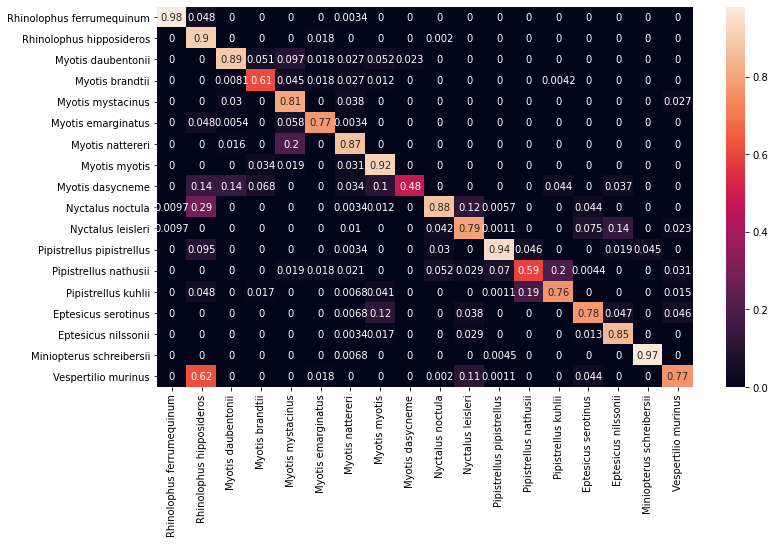

In [18]:
# Build confusion matrix
cf_matrix = confusion_matrix(Y_true, Y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=-1), index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (12, 7))
sn.heatmap(df_cm, annot=True)
plt.savefig('BigBAT.png')

In [19]:
corrects = np.equal(Y_pred, Y_true).sum()
single_test_acc = corrects / len(Y_pred)
single_f1 = f1_score(Y_true, Y_pred, average=None).mean()

print("Single test accuracy:", single_test_acc)
print("Single F1-score:", single_f1)

Single test accuracy: 0.815137987012987
Single F1-score: 0.7915907018634268


In [20]:
wandb.log({
    "mixed_test_acc": mixed_test_acc,
    "mixed_f1_micro": mixed_f1_micro,
    "mixed_f1_macro": mixed_f1_macro,
    "single_test_acc": single_test_acc,
    "single_f1_micro": single_f1,
    "num_params": pytorch_total_params,
})

wandb.finish()

mixed_f1_macro,▁
mixed_f1_micro,▁
mixed_test_acc,▁
num_params,▁
single_f1_micro,▁
single_test_acc,▁
train_acc,▁▃▃▄▄▄▅▅▆▆▆▆▆▇▇▇█▇▇▇███
train_loss,█▆▅▄▄▄▄▃▃▂▂▃▂▂▂▂▁▂▂▂▁▁▁
val_acc,▁▃▄▄▄▅▆▆▇▇▇▆▇▇███▇▇████
val_loss,█▇▆▅▅▄▄▃▂▂▂▄▃▃▂▁▁▃▃▂▂▁▁
mixed_f1_macro,0.6779
